In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

import torch
import torchvision
from torch import nn
from torch.distributions import MultivariateNormal
import math

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [ ]:
def pdf(inputs, mean, covariance=None):
    assert type(inputs) == torch.Tensor
    id_matrix = torch.eye(inputs.size()[1])
    if covariance is None:
        convariance = id_matrix
        k = inputs.size()[1]
        assert convariance.size()[0] == inputs.size()[1]
        expo = (inputs - mean).mm(convariance).mm((inputs - mean).transpose(0, 1))
        p = torch.exp(expo.squeeze() / (-2))
        t = 1 / math.sqrt(math.pow(2 * math.pi, k))
        return t * p
    else:
        pass
    
def js_divergence(mu_1: torch.tensor, cov_1: torch.tensor, 
                 mu_2: torch.tensor, cov_2: torch.tensor):
    assert mu_1.shape == mu_2.shape, 'mu shape mismatch'
    assert cov_1.shape == cov_2.shape, 'cov shape mismatch'
    
    # Monte Carlo samples
    MC_samples = 1000
    
    Pd = MultivariateNormal(loc = mu_1, covariance_matrix=cov_1)
    Qd = MultivariateNormal(loc = mu_2, covariance_matrix=cov_2)
    P_samples = Pd.sample((MC_samples,))
    Q_samples = Qd.sample((MC_samples,))
    
#     print(Pd.log_prob(torch.tensor([1.,1.])).type())
    P = lambda x: torch.tensor(np.power(2, Pd.log_prob(x).numpy()))
    Q = lambda x: torch.tensor(np.power(2, Qd.log_prob(x).numpy()))
    M = lambda x: 0.5 * P(x) + 0.5 * Q(x)
    
    P_div_M = lambda x: P(x) / M(x)
    Q_div_M = lambda x: Q(x) / M(x)

    D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(torch.log2(P_div_M(x)))
    D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(torch.log2(Q_div_M(x)))

    return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)
    

def get_new_gaussian_mixture(p, q):
    mean = (p.mean + q.mean) / 2
    cov = (p.covariance_matrix + q.covariance_matrix) / 4
    m = distr.MultivariateNormal(loc=mean, covariance_matrix=cov)
    print(m.sample())
    return m



class GMM_Simplified(object):
    def __init__(self, init_components, max_components, gamma = 0.001, pi_threshold = 0.01, jsd_threshold = 1e-4, covariance_type = None):
        assert covariance_type is None, 'Not implemented!'
        self.n_components = init_components
        self.max_components = max_components
        self.components = []
        self.gamma = gamma
        self.dataloader = None
        self.var_size = None
        self.covariance_matrix = None
        self.pi_threshold = pi_threshold
        self.jsd_threshold = jsd_threshold
    
    def fit(self, data, var_size):
        self.data = data
        self.var_size = var_size
        self.covariance_matrix = torch.eye(var_size, dtype=torch.float)
        self.initialization(data)
    
    def update_weight(self, pi_new):
        for item in self.components:
            item['pi'] = item['pi'] / (1 + pi_new)
    def restore_weight(self, pi_new):
        for item in self.components:
            item['pi'] = item['pi'] / (1 - pi_new)
    def __insert(self, new_component):
        self.components.append(new_component)
        self.update_weight(new_component['pi'])
        self.n_components += 1
        
    def __drop(self, idx):
        pi = self.components[idx]['pi']
        self.restore_weight(pi)
        self.components.pop(idx)
        self.n_components -= 1
        
    def __merge(self, l, r):
        c_1 = self.components[l]
        c_2 = self.components[r]
        pi_new = c_1['pi'] + c_2['pi']
        u_new = (c_1['pi'] * c_1['u'] + c_2['pi'] * c_2['u']) / pi_new
        
        self.components.pop(r if r > l else l)
        self.components.pop(l if l < r else r)
        self.components.append({'pi': pi_new, 'u': u_new, 'cov': self.covariance_matrix})
        
        self.n_components -= 1
    
    def __simplify(self, idx):
        j, m = 0, np.inf
        for i in range(self.n_components):
            if i != idx:
                d = self.dis(self.components[i]['u'], self.components[idx]['u'])
                if d.item() < m:
                    m = d.item()
                    j = i
        print(m)
        if m / self.var_size < self.jsd_threshold:
            print(j, idx, m)
            self.__merge(j, idx)
            self.__simplify(self.n_components - 1)
    
    #GMM.update:
    #simplified version
    #initialize a component with pi = gamma and u = x where x is a sample
    #merge two components if jsd is less than a threshold
    #otherwise if number of components exceeds n_threshold then discard one whose pi is less than threshold
    def update(self, var):
        r = {'pi': torch.tensor(self.gamma, dtype=torch.float), 'u': var, 'cov': self.covariance_matrix}
#         self.__insert(r)
#         self.__simplify(self.n_components - 1)
        rIdx, m = 0, np.inf
        for i in range(self.n_components):
#             jsd = self.js_divergence(mu_1=self.components[i]['u'], cov_1 = self.components[i]['cov'],
#                                 mu_2 = r['u'], cov_2 = r['cov'])
            jsd = self.dis(self.components[i]['u'], r['u'])
            if jsd.item() < m:
                rIdx, m = i, jsd.item()
        print(m)
        if m / self.var_size < self.jsd_threshold:
            self.components[rIdx]['pi'] += r['pi']
            self.components[rIdx]['u'] = (self.components[rIdx]['pi'] * self.components[rIdx]['u'] + r['pi'] * r['u']) / self.components[rIdx]['pi']
            self.update_weight(r['pi'])
        else:
            self.__insert(r)
        if self.n_components > self.max_components:
            for idx in range(len(self.components)):
                if self.components[idx]['pi'] < self.pi_threshold:
                    self.__drop(idx)
                    return
            l, r, m = 0, 0, np.inf
            for i in range(len(self.components)):
                for j in range(i+1, len(self.components)):
#                     jsd = self.js_divergence(mu_1=self.components[i]['u'], cov_1=self.components[i]['cov'],
#                                         mu_2=self.components[j]['u'], cov_2=self.components[j]['cov'])
                    jsd = self.dis(self.components[i]['u'], self.components[j]['u'])
#                     print(jsd)
                    if jsd.item() < m:
                        l, r = i, j
                        m = jsd.item()
            self.__merge(l,r)   
        else:
            pass
        
    def predict(self, var):
        px = 0.0
        for item in self.components:
            px += item['pi'] * np.power(2, MultivariateNormal(loc = item['u'], covariance_matrix=item['cov']).log_prob(var).numpy())
        
        print(px)
        return px
    
    def js_divergence(self, mu_1, cov_1, mu_2, cov_2):
        assert mu_1.shape == mu_2.shape, 'mu shape mismatch'
        assert cov_1.shape == cov_2.shape, 'cov shape mismatch'

        # Monte Carlo samples
        MC_samples = 1000

        Pd = MultivariateNormal(loc = mu_1, covariance_matrix=cov_1)
        Qd = MultivariateNormal(loc = mu_2, covariance_matrix=cov_2)
        P_samples = Pd.sample((MC_samples,))
        Q_samples = Qd.sample((MC_samples,))

    #     print(Pd.log_prob(torch.tensor([1.,1.])).type())
        P = lambda x: torch.tensor(np.power(2, Pd.log_prob(x).numpy()))
        Q = lambda x: torch.tensor(np.power(2, Qd.log_prob(x).numpy()))
        M = lambda x: 0.5 * P(x) + 0.5 * Q(x)

        P_div_M = lambda x: P(x) / M(x)
        Q_div_M = lambda x: Q(x) / M(x)

        D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(torch.log2(P_div_M(x)))
        D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(torch.log2(Q_div_M(x)))

        return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)
    
    def dis(self, m, n):
        return torch.sqrt(((m - n)*(m - n)).sum().float())
    
    def initialization(self, data):
        gmm_sk = mixture.GaussianMixture(n_components=self.n_components, covariance_type='diag', max_iter=100)
        l = data.size()[0]
        if l > 1000 :
            gmm_sk.fit(data[np.random.choice(len(data), 1000, replace=False)].view(-1, 28 * 28).numpy())
        else:
            gmm_sk.fit(data.view(-1, 28 * 28).numpy())
            
        for i in range(self.n_components):
            print(gmm_sk.weights_[i])
            self.components.append({'pi': torch.tensor(gmm_sk.weights_[i], dtype=torch.float),  
                                    'u': torch.tensor(gmm_sk.means_[i], dtype=torch.float), 
                                    'cov': self.covariance_matrix}
                                  )
        

        
        
        

In [ ]:
inputs = torch.randn(1,3)
print(inputs)
print(inputs.size()[0])
id_ = torch.eye(3)
print((inputs - 0.5).mm(id_).mm(inputs.transpose(0, 1) - 0.5))
inputs.transpose(0, 1)
print()

print(pdf(inputs=inputs, mean=0.5))
print(math.sqrt(2))

In [ ]:
import matplotlib.pyplot as plt
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [ ]:
m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.tensor([[1,0],[0,1]],dtype=torch.float))
n = torch.distributions.MultivariateNormal(torch.zeros(2), torch.tensor([[1,0],[0,11000]], dtype=torch.float))

print(torch.distributions.kl_divergence(m, n))
print(m.log_prob(torch.tensor([0,1], dtype=torch.float)))

js_divergence(m.mean, m.covariance_matrix, n.mean, n.covariance_matrix)
# distr.kl_divergence(m, n)


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as MVN

def jsd(mu_1: np.array, sigma_1: np.ndarray, mu_2: np.array, sigma_2: np.ndarray):
    """
    Monte carlo approximation to jensen shannon divergence for multivariate Gaussians.
    """
    assert mu_1.shape == mu_2.shape, "Shape mismatch."
    assert sigma_1.shape == sigma_2.shape, "Shape mismatch."

    # Monte Carlo samples
    MC_samples = 1000

    # Take MC samples
    P_samples = MVN.rvs(mean=mu_1, cov=sigma_1, size=MC_samples)
    Q_samples = MVN.rvs(mean=mu_2, cov=sigma_2, size=MC_samples)

    P = lambda x: MVN.pdf(x, mean=mu_1, cov=sigma_1)
    Q = lambda x: MVN.pdf(x, mean=mu_2, cov=sigma_2)
    M = lambda x: 0.5 * P(x) + 0.5 * Q(x)

    P_div_M = lambda x: P(x) / M(x)
    Q_div_M = lambda x: Q(x) / M(x)

    D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(np.log2(P_div_M(x)))
    D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(np.log2(Q_div_M(x)))

    return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)

In [ ]:
mean = np.array(mean)
cov = np.array(cov)
jsd(mu_1=mean, sigma_1=cov, mu_2=mean, sigma_2=cov)

In [ ]:
t = [{'pi': None} for i in range(10)]
t.append({})
for i in range(2, len(t)):
    print(i)

In [15]:
def pdf(inputs, mean, covariance=None):
    assert type(inputs) == torch.Tensor
    id_matrix = torch.eye(inputs.size()[1])
    if covariance is None:
        convariance = id_matrix
        k = inputs.size()[1]
        assert convariance.size()[0] == inputs.size()[1]
        expo = (inputs - mean).mm(convariance).mm((inputs - mean).transpose(0, 1))
        p = torch.exp(expo.squeeze() / (-2))
        t = 1 / math.sqrt(math.pow(2 * math.pi, k))
        return t * p
    else:
        pass
    
def js_divergence(mu_1: torch.tensor, cov_1: torch.tensor, 
                 mu_2: torch.tensor, cov_2: torch.tensor):
    assert mu_1.shape == mu_2.shape, 'mu shape mismatch'
    assert cov_1.shape == cov_2.shape, 'cov shape mismatch'
    
    # Monte Carlo samples
    MC_samples = 1000
    
    Pd = MultivariateNormal(loc = mu_1, covariance_matrix=cov_1)
    Qd = MultivariateNormal(loc = mu_2, covariance_matrix=cov_2)
    P_samples = Pd.sample((MC_samples,))
    Q_samples = Qd.sample((MC_samples,))
    
#     print(Pd.log_prob(torch.tensor([1.,1.])).type())
    P = lambda x: torch.tensor(np.power(2, Pd.log_prob(x).numpy()))
    Q = lambda x: torch.tensor(np.power(2, Qd.log_prob(x).numpy()))
    M = lambda x: 0.5 * P(x) + 0.5 * Q(x)
    
    P_div_M = lambda x: P(x) / M(x)
    Q_div_M = lambda x: Q(x) / M(x)

    D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(torch.log2(P_div_M(x)))
    D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(torch.log2(Q_div_M(x)))

    return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)
    

def get_new_gaussian_mixture(p, q):
    mean = (p.mean + q.mean) / 2
    cov = (p.covariance_matrix + q.covariance_matrix) / 4
    m = distr.MultivariateNormal(loc=mean, covariance_matrix=cov)
    print(m.sample())
    return m



class GMM_ECO(object):
    def __init__(self, init_components, max_components, learning_rate = 0.001, pi_threshold = 0.01, jsd_threshold = 1e-4, covariance_type = None, init=True):
        assert covariance_type is None, 'Not implemented!'
        self.n_components = init_components
        self.max_components = max_components
        self.components = []
        self.learning_rate = learning_rate
        self.dataloader = None
        self.var_size = None
        self.covariance_matrix = None
        self.pi_threshold = pi_threshold
        self.jsd_threshold = jsd_threshold
        self.__init = init
        self.means_ = torch.tensor([], dtype=torch.float)
        self.weights_ = torch.tensor([], dtype=torch.float)
        self.distance_vector = torch.tensor([], dtype=torch.float)
        self.distance_matric = torch.tensor([], dtype=torch.float)
    
    def fit(self, data, var_size):
        self.data = data
        self.var_size = var_size
        self.covariance_matrix = torch.eye(var_size, dtype=torch.float)
        self.initialization(data)
            
    def __update_dis_vector(self, new_sample):
        if self.n_components == 0:
            pass
        else:
            t = self.means_ - new_sample
            self.distance_vector = torch.pow(t, 2).sum(1)

    def __update_dis_matric(self):
        if self.n_components == 0:
            pass
        else:
            a_sqr = torch.pow(self.means_, 2).sum(1)
#             print(a_sqr.shape)
            b_sqr = torch.pow(self.means_, 2).sum(1).unsqueeze(1)
#             print(b_sqr.shape)
            ab = torch.mm(self.means_, torch.transpose(self.means_, 0, 1))
            self.distance_matric = a_sqr + b_sqr - 2 * ab + 1e9 * torch.eye(self.means_.shape[0], dtype=torch.float)
    
    def __get_matric_min_ele_and_idx(self, mat):
        x = torch.min(torch.min(mat, 1)[0], 0)[1]
        y = torch.min(torch.min(mat, 0)[0], 0)[1]
        return mat[x,y], (x, y)
    
    def __get_vector_min_ele_and_idx(self, vec):
        return torch.min(vec, 0)[0], torch.min(vec, 0)[1]

        
    
    #GMM.update:
    #simplified version
    #initialize a component with pi = gamma and u = x where x is a sample
    #merge two components if jsd is less than a threshold
    #otherwise if number of components exceeds n_threshold then discard one whose pi is less than threshold
    def update(self, sample):
        pi_new = torch.tensor(self.learning_rate, dtype=torch.float)
        mean_new = torch.tensor(sample, dtype=torch.float)
        self.__update_dis_vector(mean_new)
#         if self.n_components == self.max_components and self.distance_vector.min() > 8 * 1e6:
#             print(self.distance_vector.min())
#             self.max_components += 1
        
        if self.n_components == self.max_components:
            min_val, min_idx = torch.min(self.weights_, 0)
            if min_val.item() < self.pi_threshold:
                self.weights_[min_idx.item()] = 0
                self.weights_ = self.weights_ * (1 - pi_new) / torch.sum(self.weights_)
                self.weights_[min_idx.item()] = pi_new
                self.means_[min_idx.item()] = mean_new
                self.components[min_idx.item()].clear()
                self.components[min_idx.item()].append(mean_new)
                
            else:
                new_sample_min_dist, closest_sample_to_new_sample = self.__get_vector_min_ele_and_idx(self.distance_vector)
                existing_samples_min_dist, closest_existing_sample_pair = self.__get_matric_min_ele_and_idx(self.distance_matric)
                if new_sample_min_dist < existing_samples_min_dist:
                    self.weights_ = self.weights_ * (1 - pi_new)
                    alpha1 = self.weights_[closest_sample_to_new_sample] / (self.weights_[closest_sample_to_new_sample] + pi_new)
                    alpha2 = 1 - alpha1
                    self.means_[closest_sample_to_new_sample] = alpha1 * self.means_[closest_sample_to_new_sample] + alpha2 * mean_new
                    self.weights_[closest_sample_to_new_sample] += pi_new
                    self.components[closest_sample_to_new_sample].append(mean_new)
                else:
                    s_1, s_2 = closest_existing_sample_pair
                    self.weights_ = self.weights_ * (1 - pi_new)
                    alpha1 = self.weights_[s_1] / (self.weights_[s_1] + self.weights_[s_2])
                    alpha2 = 1 - alpha1
                    self.means_[s_1] = alpha1 * self.means_[s_1] + alpha2 * self.means_[s_2]
                    self.weights_[s_1] += self.weights_[s_2]
                    self.components[s_1].extend(self.components[s_2])
                    
                    self.weights_[s_2] = pi_new
                    self.means_[s_2] = mean_new
                    self.components[s_2].clear()
                    self.components[s_2].append(mean_new)
        else:
            if self.n_components == 0:
                self.weights_ = torch.tensor(1.).unsqueeze(0)
                self.means_ = mean_new.unsqueeze(0)
                self.components.append([mean_new])
                self.n_components = 1
            else:
                self.weights_ = self.weights_ * (1 - pi_new)
                self.weights_ = torch.cat((self.weights_, pi_new.unsqueeze(0)))
                self.means_ = torch.cat((self.means_, mean_new.unsqueeze(0)))
                self.components.append([mean_new])
                self.n_components += 1

        self.__update_dis_matric()
        
    def predict(self, var):
        px = 0.0
        t = self.means_ - var
        p = (-1 / 2) * torch.pow(t / 255, 2).sum(1)
        p = torch.exp(p)
        for i in range(self.n_components):
            p[i] = self.weights_[i] * p[i]
#         print(p / p.sum())
        t = p / p.sum()
                
        return t.max(0)
    
    def js_divergence(self, mu_1, cov_1, mu_2, cov_2):
        assert mu_1.shape == mu_2.shape, 'mu shape mismatch'
        assert cov_1.shape == cov_2.shape, 'cov shape mismatch'

        # Monte Carlo samples
        MC_samples = 1000

        Pd = MultivariateNormal(loc = mu_1, covariance_matrix=cov_1)
        Qd = MultivariateNormal(loc = mu_2, covariance_matrix=cov_2)
        P_samples = Pd.sample((MC_samples,))
        Q_samples = Qd.sample((MC_samples,))

    #     print(Pd.log_prob(torch.tensor([1.,1.])).type())
        P = lambda x: torch.tensor(np.power(2, Pd.log_prob(x).numpy()))
        Q = lambda x: torch.tensor(np.power(2, Qd.log_prob(x).numpy()))
        M = lambda x: 0.5 * P(x) + 0.5 * Q(x)

        P_div_M = lambda x: P(x) / M(x)
        Q_div_M = lambda x: Q(x) / M(x)

        D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(torch.log2(P_div_M(x)))
        D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(torch.log2(Q_div_M(x)))

        return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)

    
    def initialization(self, data):
        if self.__init:
            gmm_sk = mixture.GaussianMixture(n_components=self.n_components, covariance_type='diag', max_iter=100)
            l = data.size()[0]
            if l > 1000 :
                gmm_sk.fit(data[np.random.choice(len(data), 1000, replace=False)].view(-1, 28 * 28).numpy())
            else:
                gmm_sk.fit(data.view(-1, 28 * 28).numpy())
            
            self.means_ = torch.tensor(gmm_sk.means_, dtype=torch.float)
            self.weights_ = torch.tensor(gmm_sk.weights_, dtype=torch.float)
            print(self.means_.shape)
            self.__update_dis_matric()
        else:
            self.n_components = 0
        

        
        
        

In [ ]:
t = torch.tensor([[1.,2,0],[1,2,3], [1,1,1]])
print(torch.mm(t, torch.transpose(t, 0,1)))
s = torch.tensor([1., 2, 3])
print(torch.pow(t,2).sum(1) + torch.pow(t, 2).sum(1).unsqueeze(1) - 2 * torch.mm(t, torch.transpose(t, 0,1)))
# print(s.unsqueeze(1) + s)
# print(torch.pow(t- s, 2).sum(1))
print(torch.max(torch.max(t, 1)[0], 0)[1])
print(torch.max(torch.max(t, 1)[0], 0)[1], torch.max(torch.max(t, 0)[0], 0)[1])
t[torch.tensor(1), torch.tensor(2)]
s[0] = torch.tensor(2.)
print(s)
print(1e9 * torch.eye(3, dtype=torch.float))
print(torch.cat((t, s.unsqueeze(0))))
torch.cat((s, torch.tensor(1.).unsqueeze(0)))

torch.Size([1, 28, 28])
    9


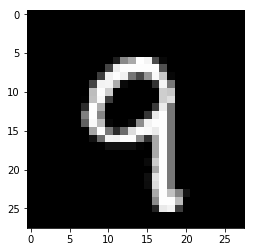

In [16]:
root_path = './data'
transform = transforms.ToTensor()
trainset = MNIST(root=root_path, train=True, download=True, transform=transform)
testet = MNIST(root=root_path, train=False, download=True, transform=transform)
trainloader = DataLoader(dataset=trainset, shuffle=True, 
                         batch_size=1, num_workers=6)
testloader = DataLoader(dataset=testet, shuffle=False, 
                        batch_size=1, num_workers=6)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0].shape)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(1)))

In [ ]:
gmm = GMM_Simplified(max_components=10, init_components=10, gamma=1e-3, pi_threshold=0.00001,jsd_threshold=4)
var_size = trainset.train_data.size()
print(trainset.train_data[np.random.choice(var_size[0], 1000, replace=False)].shape)
gmm.fit(trainset.train_data, var_size=var_size[1] * var_size[2])
plt.figure(figsize=(40,10))
for i in range(gmm.n_components):
    plt_idx = i + 1
    plt.subplot(2,5,plt_idx)
    plt.imshow(gmm.components[i]['u'].view(28, 28))
    plt.axis("off")
plt.show()


In [17]:
gmm_eco = GMM_ECO(learning_rate=0.006, init=False, init_components=10, max_components=10, pi_threshold=0.001)
var_size = trainset.train_data.size()
gmm_eco.fit(trainset.train_data, var_size=var_size[1] * var_size[2])
plt.figure(figsize=(40,10))
for i in range(gmm_eco.n_components):
    plt_idx = i + 1
    plt.subplot(2,5,plt_idx)
    plt.imshow(gmm_eco.means_[i].view(28, 28))
    plt.axis("off")
plt.show()

<Figure size 2880x720 with 0 Axes>

tensor(73.0760)
(tensor(0.6458), tensor(6))
torch.Size([5958, 28, 28])
tensor([   33,  2190,    72,    24,     5,   116,   488,    90,  2672,
          233])
tensor([   11,     0,     5,  3870,  2808,    20,     3,    12,     0,
           13])
tensor([   94,   177,     0,   370,   612,  2430,   284,   273,    11,
         1707])
tensor([  108,    42,    18,   486,    26,   956,  4110,   294,     7,
           84])
tensor([ 2227,    13,     2,   213,   174,    19,     0,  3029,     2,
          163])
tensor([  104,    88,  1983,   407,   351,    89,  2006,   274,    23,
           96])
tensor([    4,   131,   168,   369,    80,    14,    56,    71,    33,
         4992])
tensor([ 3714,     9,     0,   346,   171,    58,     4,  1950,     4,
            9])
tensor([  500,    21,   203,   644,   231,  2414,  1299,   451,    22,
           66])
tensor([ 2630,    17,     8,   324,    44,    23,    94,  2771,    24,
           14])


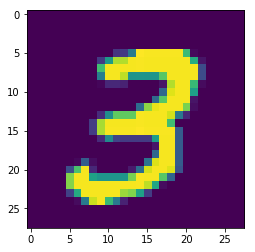

In [6]:
plt.imshow(trainset.train_data[7])
print(torch.pow(trainset.train_data[7].view(28 * 28).float() / 255 - gmm_eco.means_[7] / 255, 2).sum())
print(gmm_eco.predict(trainset.train_data[0].float().view(28 * 28)))
print(trainset.train_data[trainset.train_labels == 2].shape)


for i in range(10):
    testdata = trainset.train_data[trainset.train_labels == i].float().view(-1, 28 * 28)
    rec = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for j in range(testdata.shape[0]):
        idx = gmm_eco.predict(testdata[j])[1]
        rec[idx] += 1
    print(rec)
    

In [20]:
for _ in range(5000):
    idx = np.random.randint(var_size[0])
    gmm_eco.update(sample=trainset.train_data[idx].float().view(28 * 28))
    for i in range(gmm_eco.n_components):
        print(gmm_eco.weights_[i])
    print('------------------')

tensor(1.00000e-02 *
       2.0312)
tensor(1.00000e-02 *
       8.6392)
tensor(0.1411)
tensor(1.00000e-02 *
       7.5328)
tensor(0.1594)
tensor(0.1258)
tensor(0.1399)
tensor(0.1903)
tensor(1.00000e-03 *
       3.0213)
tensor(1.00000e-02 *
       5.8483)
------------------
tensor(1.00000e-02 *
       2.0190)
tensor(1.00000e-02 *
       9.1874)
tensor(0.1402)
tensor(1.00000e-02 *
       7.4876)
tensor(0.1584)
tensor(0.1251)
tensor(0.1390)
tensor(0.1892)
tensor(1.00000e-03 *
       3.0032)
tensor(1.00000e-02 *
       5.8132)
------------------
tensor(1.00000e-02 *
       2.0069)
tensor(1.00000e-02 *
       9.1323)
tensor(0.1394)
tensor(1.00000e-02 *
       7.4426)
tensor(0.1575)
tensor(0.1243)
tensor(0.1382)
tensor(0.1940)
tensor(1.00000e-03 *
       2.9852)
tensor(1.00000e-02 *
       5.7784)
------------------
tensor(1.00000e-02 *
       1.9948)
tensor(1.00000e-02 *
       9.0775)
tensor(0.1385)
tensor(1.00000e-02 *
       7.3980)
tensor(0.1566)
tensor(0.1236)
tensor(0.1373)
tensor(0.1

tensor(0.1506)
tensor(0.1225)
tensor(0.1396)
tensor(0.1887)
tensor(1.00000e-03 *
       2.4182)
tensor(1.00000e-02 *
       6.8320)
------------------
tensor(1.00000e-02 *
       2.1576)
tensor(1.00000e-02 *
       8.4065)
tensor(0.1389)
tensor(1.00000e-02 *
       8.1352)
tensor(0.1497)
tensor(0.1217)
tensor(0.1388)
tensor(0.1876)
tensor(1.00000e-03 *
       2.4037)
tensor(1.00000e-02 *
       7.3910)
------------------
tensor(1.00000e-02 *
       2.1447)
tensor(1.00000e-02 *
       8.3561)
tensor(0.1381)
tensor(1.00000e-02 *
       8.6864)
tensor(0.1488)
tensor(0.1210)
tensor(0.1379)
tensor(0.1865)
tensor(1.00000e-03 *
       2.3893)
tensor(1.00000e-02 *
       7.3466)
------------------
tensor(1.00000e-02 *
       2.1318)
tensor(1.00000e-02 *
       8.3059)
tensor(0.1373)
tensor(1.00000e-02 *
       8.6343)
tensor(0.1479)
tensor(0.1203)
tensor(0.1431)
tensor(0.1854)
tensor(1.00000e-03 *
       2.3750)
tensor(1.00000e-02 *
       7.3026)
------------------
tensor(1.00000e-02 *
      

tensor(0.1499)
tensor(1.00000e-02 *
       8.8369)
tensor(0.1379)
tensor(0.1316)
tensor(0.1232)
tensor(0.1772)
tensor(1.00000e-03 *
       1.8557)
tensor(1.00000e-02 *
       8.3139)
------------------
tensor(1.00000e-02 *
       1.6557)
tensor(1.00000e-02 *
       8.9675)
tensor(0.1490)
tensor(1.00000e-02 *
       8.7839)
tensor(0.1431)
tensor(0.1308)
tensor(0.1224)
tensor(0.1761)
tensor(1.00000e-03 *
       1.8445)
tensor(1.00000e-02 *
       8.2640)
------------------
tensor(1.00000e-02 *
       1.6457)
tensor(1.00000e-02 *
       8.9137)
tensor(0.1481)
tensor(1.00000e-02 *
       8.7312)
tensor(0.1422)
tensor(0.1301)
tensor(0.1277)
tensor(0.1751)
tensor(1.00000e-03 *
       1.8335)
tensor(1.00000e-02 *
       8.2144)
------------------
tensor(1.00000e-02 *
       1.6359)
tensor(1.00000e-02 *
       8.8603)
tensor(0.1472)
tensor(1.00000e-02 *
       9.2788)
tensor(0.1414)
tensor(0.1293)
tensor(0.1269)
tensor(0.1740)
tensor(1.00000e-03 *
       1.8225)
tensor(1.00000e-02 *
       8.1

tensor(1.00000e-02 *
       2.8989)
tensor(1.00000e-02 *
       8.3881)
tensor(0.1320)
tensor(1.00000e-02 *
       8.6291)
tensor(0.1493)
tensor(0.1312)
tensor(0.1174)
tensor(0.1862)
tensor(1.00000e-03 *
       6.4903)
tensor(1.00000e-02 *
       7.8355)
------------------
tensor(1.00000e-02 *
       2.8815)
tensor(1.00000e-02 *
       8.3378)
tensor(0.1312)
tensor(1.00000e-02 *
       8.5773)
tensor(0.1484)
tensor(0.1364)
tensor(0.1167)
tensor(0.1851)
tensor(1.00000e-03 *
       6.4513)
tensor(1.00000e-02 *
       7.7885)
------------------
tensor(1.00000e-02 *
       2.8642)
tensor(1.00000e-02 *
       8.2877)
tensor(0.1364)
tensor(1.00000e-02 *
       8.5259)
tensor(0.1475)
tensor(0.1356)
tensor(0.1160)
tensor(0.1840)
tensor(1.00000e-03 *
       6.4126)
tensor(1.00000e-02 *
       7.7417)
------------------
tensor(1.00000e-02 *
       2.8470)
tensor(1.00000e-02 *
       8.2380)
tensor(0.1356)
tensor(1.00000e-02 *
       8.4747)
tensor(0.1466)
tensor(0.1347)
tensor(0.1153)
tensor(0.1

       4.9505)
tensor(1.00000e-02 *
       7.5411)
------------------
tensor(1.00000e-02 *
       2.1979)
tensor(1.00000e-02 *
       8.3829)
tensor(0.1313)
tensor(1.00000e-02 *
       8.7808)
tensor(0.1679)
tensor(0.1258)
tensor(0.1294)
tensor(0.1721)
tensor(1.00000e-03 *
       4.9208)
tensor(1.00000e-02 *
       7.4958)
------------------
tensor(1.00000e-02 *
       2.1847)
tensor(1.00000e-02 *
       8.3326)
tensor(0.1365)
tensor(1.00000e-02 *
       8.7281)
tensor(0.1669)
tensor(0.1251)
tensor(0.1286)
tensor(0.1711)
tensor(1.00000e-03 *
       4.8913)
tensor(1.00000e-02 *
       7.4509)
------------------
tensor(1.00000e-02 *
       2.1716)
tensor(1.00000e-02 *
       8.2826)
tensor(0.1357)
tensor(1.00000e-02 *
       9.2758)
tensor(0.1659)
tensor(0.1243)
tensor(0.1278)
tensor(0.1700)
tensor(1.00000e-03 *
       4.8619)
tensor(1.00000e-02 *
       7.4062)
------------------
tensor(1.00000e-02 *
       2.7586)
tensor(1.00000e-02 *
       8.2329)
tensor(0.1349)
tensor(1.00000e-02 *


tensor(1.00000e-02 *
       2.8115)
tensor(1.00000e-02 *
       8.9859)
tensor(0.1396)
tensor(1.00000e-02 *
       8.7980)
tensor(0.1479)
tensor(0.1307)
tensor(0.1160)
tensor(0.1722)
tensor(1.00000e-03 *
       9.6259)
tensor(1.00000e-02 *
       7.7984)
------------------
tensor(1.00000e-02 *
       2.7947)
tensor(1.00000e-02 *
       8.9320)
tensor(0.1388)
tensor(1.00000e-02 *
       8.7452)
tensor(0.1470)
tensor(0.1300)
tensor(0.1213)
tensor(0.1711)
tensor(1.00000e-03 *
       9.5682)
tensor(1.00000e-02 *
       7.7516)
------------------
tensor(1.00000e-02 *
       2.7779)
tensor(1.00000e-02 *
       9.4784)
tensor(0.1380)
tensor(1.00000e-02 *
       8.6927)
tensor(0.1461)
tensor(0.1292)
tensor(0.1206)
tensor(0.1701)
tensor(1.00000e-03 *
       9.5108)
tensor(1.00000e-02 *
       7.7051)
------------------
tensor(1.00000e-02 *
       2.7612)
tensor(1.00000e-02 *
       9.4215)
tensor(0.1431)
tensor(1.00000e-02 *
       8.6406)
tensor(0.1452)
tensor(0.1284)
tensor(0.1199)
tensor(0.1

tensor(0.1099)
tensor(0.1870)
tensor(1.00000e-03 *
       7.3866)
tensor(1.00000e-02 *
       8.5019)
------------------
tensor(1.00000e-02 *
       2.6162)
tensor(1.00000e-02 *
       9.9319)
tensor(0.1377)
tensor(1.00000e-02 *
       9.4095)
tensor(0.1346)
tensor(0.1152)
tensor(0.1152)
tensor(0.1859)
tensor(1.00000e-03 *
       7.3423)
tensor(1.00000e-02 *
       8.4509)
------------------
tensor(1.00000e-02 *
       2.6005)
tensor(1.00000e-02 *
       9.8723)
tensor(0.1428)
tensor(1.00000e-02 *
       9.3531)
tensor(0.1337)
tensor(0.1146)
tensor(0.1145)
tensor(0.1848)
tensor(1.00000e-03 *
       7.2982)
tensor(1.00000e-02 *
       8.4002)
------------------
tensor(1.00000e-02 *
       2.5849)
tensor(1.00000e-02 *
       9.8131)
tensor(0.1480)
tensor(1.00000e-02 *
       9.2970)
tensor(0.1329)
tensor(0.1139)
tensor(0.1138)
tensor(0.1837)
tensor(1.00000e-03 *
       7.2544)
tensor(1.00000e-02 *
       8.3498)
------------------
tensor(1.00000e-02 *
       2.5694)
tensor(1.00000e-02 *


tensor(1.00000e-02 *
       2.7065)
tensor(0.1038)
tensor(0.1552)
tensor(1.00000e-02 *
       8.8273)
tensor(0.1379)
tensor(0.1053)
tensor(0.1158)
tensor(0.1913)
tensor(1.00000e-03 *
       6.0198)
tensor(1.00000e-02 *
       6.9287)
------------------
tensor(1.00000e-02 *
       2.6903)
tensor(0.1032)
tensor(0.1543)
tensor(1.00000e-02 *
       8.7743)
tensor(0.1371)
tensor(0.1047)
tensor(0.1151)
tensor(0.1961)
tensor(1.00000e-03 *
       5.9837)
tensor(1.00000e-02 *
       6.8871)
------------------
tensor(1.00000e-02 *
       2.6741)
tensor(0.1026)
tensor(0.1533)
tensor(1.00000e-02 *
       8.7217)
tensor(0.1363)
tensor(0.1040)
tensor(0.1145)
tensor(0.1949)
tensor(1.00000e-03 *
       5.9478)
tensor(1.00000e-02 *
       7.4458)
------------------
tensor(1.00000e-02 *
       2.6581)
tensor(0.1020)
tensor(0.1524)
tensor(1.00000e-02 *
       8.6694)
tensor(0.1355)
tensor(0.1034)
tensor(0.1198)
tensor(0.1938)
tensor(1.00000e-03 *
       5.9121)
tensor(1.00000e-02 *
       7.4011)
-------

tensor(1.00000e-02 *
       2.1403)
tensor(0.1034)
tensor(0.1388)
tensor(1.00000e-02 *
       8.0444)
tensor(0.1256)
tensor(0.1213)
tensor(0.1348)
tensor(0.1942)
tensor(1.00000e-03 *
       9.7694)
tensor(1.00000e-02 *
       7.0366)
------------------
tensor(1.00000e-02 *
       2.1275)
tensor(0.1027)
tensor(0.1380)
tensor(1.00000e-02 *
       7.9961)
tensor(0.1248)
tensor(0.1205)
tensor(0.1340)
tensor(0.1991)
tensor(1.00000e-03 *
       9.7108)
tensor(1.00000e-02 *
       6.9944)
------------------
tensor(1.00000e-02 *
       2.1147)
tensor(0.1081)
tensor(0.1372)
tensor(1.00000e-02 *
       7.9481)
tensor(0.1241)
tensor(0.1198)
tensor(0.1332)
tensor(0.1979)
tensor(1.00000e-03 *
       9.6525)
tensor(1.00000e-02 *
       6.9524)
------------------
tensor(1.00000e-02 *
       2.1020)
tensor(0.1135)
tensor(0.1363)
tensor(1.00000e-02 *
       7.9005)
tensor(0.1233)
tensor(0.1191)
tensor(0.1324)
tensor(0.1967)
tensor(1.00000e-03 *
       9.5946)
tensor(1.00000e-02 *
       6.9107)
-------

tensor(1.00000e-03 *
       7.7723)
tensor(1.00000e-02 *
       6.6030)
------------------
tensor(1.00000e-02 *
       2.7727)
tensor(0.1202)
tensor(0.1254)
tensor(1.00000e-02 *
       7.9969)
tensor(0.1212)
tensor(0.1274)
tensor(0.1297)
tensor(0.1951)
tensor(1.00000e-03 *
       7.7257)
tensor(1.00000e-02 *
       6.5634)
------------------
tensor(1.00000e-02 *
       2.7560)
tensor(0.1255)
tensor(0.1246)
tensor(1.00000e-02 *
       7.9489)
tensor(0.1205)
tensor(0.1266)
tensor(0.1289)
tensor(0.1939)
tensor(1.00000e-03 *
       7.6793)
tensor(1.00000e-02 *
       6.5240)
------------------
tensor(1.00000e-02 *
       2.7395)
tensor(0.1247)
tensor(0.1239)
tensor(1.00000e-02 *
       7.9012)
tensor(0.1198)
tensor(0.1258)
tensor(0.1281)
tensor(0.1927)
tensor(1.00000e-03 *
       7.6333)
tensor(1.00000e-02 *
       7.0848)
------------------
tensor(1.00000e-02 *
       2.7231)
tensor(0.1240)
tensor(0.1232)
tensor(1.00000e-02 *
       7.8538)
tensor(0.1191)
tensor(0.1251)
tensor(0.1274)
ten

tensor(1.00000e-02 *
       2.1664)
tensor(0.1367)
tensor(0.1296)
tensor(1.00000e-02 *
       6.7803)
tensor(0.1274)
tensor(0.1164)
tensor(0.1498)
tensor(0.1631)
tensor(1.00000e-02 *
       1.0956)
tensor(1.00000e-02 *
       7.6571)
------------------
tensor(1.00000e-02 *
       2.1534)
tensor(0.1359)
tensor(0.1349)
tensor(1.00000e-02 *
       6.7396)
tensor(0.1266)
tensor(0.1157)
tensor(0.1489)
tensor(0.1622)
tensor(1.00000e-02 *
       1.0890)
tensor(1.00000e-02 *
       7.6112)
------------------
tensor(1.00000e-02 *
       2.1405)
tensor(0.1350)
tensor(0.1341)
tensor(1.00000e-02 *
       6.6992)
tensor(0.1259)
tensor(0.1150)
tensor(0.1480)
tensor(0.1612)
tensor(1.00000e-02 *
       1.0825)
tensor(1.00000e-02 *
       8.1655)
------------------
tensor(1.00000e-02 *
       2.1276)
tensor(0.1342)
tensor(0.1392)
tensor(1.00000e-02 *
       6.6590)
tensor(0.1251)
tensor(0.1143)
tensor(0.1471)
tensor(0.1602)
tensor(1.00000e-02 *
       1.0760)
tensor(1.00000e-02 *
       8.1165)
-------

tensor(1.00000e-02 *
       2.8591)
tensor(0.1525)
tensor(0.1250)
tensor(1.00000e-02 *
       6.6161)
tensor(0.1292)
tensor(0.1039)
tensor(0.1617)
tensor(0.1524)
tensor(1.00000e-03 *
       8.7687)
tensor(1.00000e-02 *
       7.1830)
------------------
tensor(1.00000e-02 *
       2.8420)
tensor(0.1516)
tensor(0.1242)
tensor(1.00000e-02 *
       6.5764)
tensor(0.1284)
tensor(0.1033)
tensor(0.1607)
tensor(0.1514)
tensor(1.00000e-03 *
       8.7161)
tensor(1.00000e-02 *
       7.7399)
------------------
tensor(1.00000e-02 *
       2.8249)
tensor(0.1507)
tensor(0.1295)
tensor(1.00000e-02 *
       6.5369)
tensor(0.1276)
tensor(0.1027)
tensor(0.1598)
tensor(0.1505)
tensor(1.00000e-03 *
       8.6638)
tensor(1.00000e-02 *
       7.6935)
------------------
tensor(1.00000e-02 *
       2.8080)
tensor(0.1498)
tensor(0.1287)
tensor(1.00000e-02 *
       6.4977)
tensor(0.1269)
tensor(0.1081)
tensor(0.1588)
tensor(0.1496)
tensor(1.00000e-03 *
       8.6118)
tensor(1.00000e-02 *
       7.6473)
-------

tensor(1.00000e-02 *
       7.3013)
------------------
tensor(1.00000e-02 *
       3.3650)
tensor(0.1312)
tensor(0.1361)
tensor(1.00000e-02 *
       5.2320)
tensor(0.1185)
tensor(0.1202)
tensor(0.1608)
tensor(0.1571)
tensor(1.00000e-02 *
       1.7575)
tensor(1.00000e-02 *
       7.2575)
------------------
tensor(1.00000e-02 *
       3.3448)
tensor(0.1304)
tensor(0.1353)
tensor(1.00000e-02 *
       5.2006)
tensor(0.1178)
tensor(0.1194)
tensor(0.1659)
tensor(0.1562)
tensor(1.00000e-02 *
       1.7470)
tensor(1.00000e-02 *
       7.2139)
------------------
tensor(1.00000e-02 *
       3.3248)
tensor(0.1296)
tensor(0.1345)
tensor(1.00000e-02 *
       5.1694)
tensor(0.1171)
tensor(0.1187)
tensor(0.1649)
tensor(0.1613)
tensor(1.00000e-02 *
       1.7365)
tensor(1.00000e-02 *
       7.1707)
------------------
tensor(1.00000e-02 *
       3.3048)
tensor(0.1288)
tensor(0.1337)
tensor(1.00000e-02 *
       5.1384)
tensor(0.1164)
tensor(0.1240)
tensor(0.1639)
tensor(0.1603)
tensor(1.00000e-02 *
   

tensor(0.1196)
tensor(0.1425)
tensor(0.1602)
tensor(0.1668)
tensor(1.00000e-02 *
       1.4497)
tensor(1.00000e-02 *
       5.9862)
------------------
tensor(1.00000e-02 *
       3.2689)
tensor(0.1246)
tensor(0.1405)
tensor(1.00000e-02 *
       4.2896)
tensor(0.1189)
tensor(0.1416)
tensor(0.1592)
tensor(0.1658)
tensor(1.00000e-02 *
       1.4410)
tensor(1.00000e-02 *
       5.9503)
------------------
tensor(1.00000e-02 *
       3.2493)
tensor(0.1238)
tensor(0.1396)
tensor(1.00000e-02 *
       4.2639)
tensor(0.1182)
tensor(0.1408)
tensor(0.1582)
tensor(0.1648)
tensor(1.00000e-02 *
       1.4323)
tensor(1.00000e-02 *
       6.5146)
------------------
tensor(1.00000e-02 *
       3.2298)
tensor(0.1231)
tensor(0.1388)
tensor(1.00000e-02 *
       4.2383)
tensor(0.1235)
tensor(0.1399)
tensor(0.1573)
tensor(0.1638)
tensor(1.00000e-02 *
       1.4237)
tensor(1.00000e-02 *
       6.4755)
------------------
tensor(1.00000e-02 *
       3.2104)
tensor(0.1223)
tensor(0.1379)
tensor(1.00000e-02 *
   

tensor(1.00000e-02 *
       4.9237)
tensor(0.1096)
tensor(0.1341)
tensor(0.1480)
tensor(0.1785)
tensor(1.00000e-02 *
       1.1395)
tensor(1.00000e-02 *
       7.3478)
------------------
tensor(1.00000e-02 *
       3.1379)
tensor(0.1240)
tensor(0.1444)
tensor(1.00000e-02 *
       4.8941)
tensor(0.1090)
tensor(0.1333)
tensor(0.1471)
tensor(0.1775)
tensor(1.00000e-02 *
       1.1327)
tensor(1.00000e-02 *
       7.3037)
------------------
tensor(1.00000e-02 *
       3.1191)
tensor(0.1232)
tensor(0.1436)
tensor(1.00000e-02 *
       4.8648)
tensor(0.1083)
tensor(0.1325)
tensor(0.1463)
tensor(0.1764)
tensor(1.00000e-02 *
       1.1259)
tensor(1.00000e-02 *
       7.8599)
------------------
tensor(1.00000e-02 *
       3.1004)
tensor(0.1225)
tensor(0.1427)
tensor(1.00000e-02 *
       4.8356)
tensor(0.1077)
tensor(0.1377)
tensor(0.1454)
tensor(0.1753)
tensor(1.00000e-02 *
       1.1191)
tensor(1.00000e-02 *
       7.8127)
------------------
tensor(1.00000e-02 *
       3.0818)
tensor(0.1218)
ten

tensor(0.1674)
tensor(1.00000e-02 *
       1.4479)
tensor(1.00000e-02 *
       7.5982)
------------------
tensor(1.00000e-02 *
       3.9896)
tensor(0.1153)
tensor(0.1400)
tensor(1.00000e-02 *
       4.2075)
tensor(0.1327)
tensor(0.1341)
tensor(0.1396)
tensor(0.1664)
tensor(1.00000e-02 *
       1.4392)
tensor(1.00000e-02 *
       7.5527)
------------------
tensor(1.00000e-02 *
       3.9656)
tensor(0.1146)
tensor(0.1391)
tensor(1.00000e-02 *
       4.1823)
tensor(0.1319)
tensor(0.1333)
tensor(0.1448)
tensor(0.1654)
tensor(1.00000e-02 *
       1.4306)
tensor(1.00000e-02 *
       7.5073)
------------------
tensor(1.00000e-02 *
       3.9418)
tensor(0.1200)
tensor(0.1383)
tensor(1.00000e-02 *
       4.1572)
tensor(0.1311)
tensor(0.1325)
tensor(0.1439)
tensor(0.1644)
tensor(1.00000e-02 *
       1.4220)
tensor(1.00000e-02 *
       7.4623)
------------------
tensor(1.00000e-02 *
       3.9182)
tensor(0.1192)
tensor(0.1375)
tensor(1.00000e-02 *
       4.1322)
tensor(0.1303)
tensor(0.1317)
ten

tensor(1.00000e-02 *
       4.7418)
tensor(0.1381)
tensor(0.1322)
tensor(1.00000e-02 *
       7.6534)
tensor(0.1261)
tensor(0.1215)
tensor(0.1145)
tensor(0.1510)
tensor(1.00000e-02 *
       1.7277)
tensor(1.00000e-02 *
       7.5445)
------------------
tensor(1.00000e-02 *
       4.7133)
tensor(0.1373)
tensor(0.1314)
tensor(1.00000e-02 *
       7.6074)
tensor(0.1253)
tensor(0.1267)
tensor(0.1138)
tensor(0.1501)
tensor(1.00000e-02 *
       1.7173)
tensor(1.00000e-02 *
       7.4992)
------------------
tensor(1.00000e-02 *
       5.2851)
tensor(0.1365)
tensor(0.1306)
tensor(1.00000e-02 *
       7.5618)
tensor(0.1246)
tensor(0.1260)
tensor(0.1131)
tensor(0.1492)
tensor(1.00000e-02 *
       1.7070)
tensor(1.00000e-02 *
       7.4542)
------------------
tensor(1.00000e-02 *
       5.2534)
tensor(0.1357)
tensor(0.1298)
tensor(1.00000e-02 *
       7.5164)
tensor(0.1298)
tensor(0.1252)
tensor(0.1124)
tensor(0.1483)
tensor(1.00000e-02 *
       1.6968)
tensor(1.00000e-02 *
       7.4095)
-------

tensor(1.00000e-02 *
       4.8069)
tensor(0.1328)
tensor(0.1058)
tensor(1.00000e-02 *
       7.2078)
tensor(0.1325)
tensor(0.1286)
tensor(0.1134)
tensor(0.1590)
tensor(1.00000e-02 *
       2.4708)
tensor(1.00000e-02 *
       8.3055)
------------------
tensor(1.00000e-02 *
       4.7780)
tensor(0.1320)
tensor(0.1052)
tensor(1.00000e-02 *
       7.7646)
tensor(0.1317)
tensor(0.1278)
tensor(0.1127)
tensor(0.1581)
tensor(1.00000e-02 *
       2.4560)
tensor(1.00000e-02 *
       8.2556)
------------------
tensor(1.00000e-02 *
       4.7494)
tensor(0.1312)
tensor(0.1045)
tensor(1.00000e-02 *
       7.7180)
tensor(0.1369)
tensor(0.1270)
tensor(0.1120)
tensor(0.1571)
tensor(1.00000e-02 *
       2.4413)
tensor(1.00000e-02 *
       8.2061)
------------------
tensor(1.00000e-02 *
       4.7209)
tensor(0.1304)
tensor(0.1039)
tensor(1.00000e-02 *
       7.6717)
tensor(0.1361)
tensor(0.1263)
tensor(0.1113)
tensor(0.1622)
tensor(1.00000e-02 *
       2.4266)
tensor(1.00000e-02 *
       8.1569)
-------

tensor(1.00000e-02 *
       2.7138)
tensor(1.00000e-02 *
       8.1315)
------------------
tensor(1.00000e-02 *
       5.2818)
tensor(0.1050)
tensor(0.1320)
tensor(1.00000e-02 *
       8.0130)
tensor(0.1191)
tensor(0.1232)
tensor(0.1145)
tensor(0.1655)
tensor(1.00000e-02 *
       2.6976)
tensor(1.00000e-02 *
       8.0827)
------------------
tensor(1.00000e-02 *
       5.2501)
tensor(0.1044)
tensor(0.1312)
tensor(1.00000e-02 *
       7.9649)
tensor(0.1184)
tensor(0.1284)
tensor(0.1138)
tensor(0.1645)
tensor(1.00000e-02 *
       2.6814)
tensor(1.00000e-02 *
       8.0342)
------------------
tensor(1.00000e-02 *
       5.2186)
tensor(0.1038)
tensor(0.1365)
tensor(1.00000e-02 *
       7.9171)
tensor(0.1177)
tensor(0.1277)
tensor(0.1131)
tensor(0.1635)
tensor(1.00000e-02 *
       2.6653)
tensor(1.00000e-02 *
       7.9860)
------------------
tensor(1.00000e-02 *
       5.1873)
tensor(0.1032)
tensor(0.1356)
tensor(1.00000e-02 *
       7.8696)
tensor(0.1169)
tensor(0.1329)
tensor(0.1124)
ten

tensor(1.00000e-02 *
       3.3360)
tensor(1.00000e-02 *
       7.8356)
------------------
tensor(1.00000e-02 *
       4.3829)
tensor(1.00000e-02 *
       8.7156)
tensor(0.1311)
tensor(1.00000e-02 *
       7.1717)
tensor(0.1097)
tensor(0.1461)
tensor(0.1229)
tensor(0.1765)
tensor(1.00000e-02 *
       3.3160)
tensor(1.00000e-02 *
       7.7886)
------------------
tensor(1.00000e-02 *
       4.3566)
tensor(1.00000e-02 *
       8.6633)
tensor(0.1363)
tensor(1.00000e-02 *
       7.1287)
tensor(0.1090)
tensor(0.1452)
tensor(0.1221)
tensor(0.1754)
tensor(1.00000e-02 *
       3.2961)
tensor(1.00000e-02 *
       7.7419)
------------------
tensor(1.00000e-02 *
       4.3305)
tensor(1.00000e-02 *
       8.6113)
tensor(0.1355)
tensor(1.00000e-02 *
       7.0859)
tensor(0.1084)
tensor(0.1444)
tensor(0.1214)
tensor(0.1804)
tensor(1.00000e-02 *
       3.2763)
tensor(1.00000e-02 *
       7.6954)
------------------
tensor(1.00000e-02 *
       4.3045)
tensor(1.00000e-02 *
       8.5596)
tensor(0.1347)


tensor(0.1298)
tensor(1.00000e-02 *
       7.2632)
tensor(0.1073)
tensor(0.1261)
tensor(0.1226)
tensor(0.1591)
tensor(1.00000e-02 *
       5.8302)
tensor(1.00000e-02 *
       9.3900)
------------------
tensor(1.00000e-02 *
       4.5300)
tensor(1.00000e-02 *
       9.0139)
tensor(0.1290)
tensor(1.00000e-02 *
       7.2196)
tensor(0.1066)
tensor(0.1254)
tensor(0.1219)
tensor(0.1582)
tensor(1.00000e-02 *
       5.7952)
tensor(1.00000e-02 *
       9.3336)
------------------
tensor(1.00000e-02 *
       4.5028)
tensor(1.00000e-02 *
       8.9598)
tensor(0.1282)
tensor(1.00000e-02 *
       7.1763)
tensor(0.1060)
tensor(0.1306)
tensor(0.1211)
tensor(0.1572)
tensor(1.00000e-02 *
       5.7604)
tensor(1.00000e-02 *
       9.2776)
------------------
tensor(1.00000e-02 *
       4.4758)
tensor(1.00000e-02 *
       8.9060)
tensor(0.1275)
tensor(1.00000e-02 *
       7.1332)
tensor(0.1054)
tensor(0.1359)
tensor(0.1204)
tensor(0.1563)
tensor(1.00000e-02 *
       5.7259)
tensor(1.00000e-02 *
       9.2

tensor(1.00000e-02 *
       4.5692)
tensor(1.00000e-02 *
       8.6955)
tensor(0.1176)
tensor(1.00000e-02 *
       7.2253)
tensor(0.1320)
tensor(0.1419)
tensor(0.1064)
tensor(0.1505)
tensor(1.00000e-02 *
       6.2726)
tensor(1.00000e-02 *
       8.4005)
------------------
tensor(1.00000e-02 *
       4.5417)
tensor(1.00000e-02 *
       8.6433)
tensor(0.1169)
tensor(1.00000e-02 *
       7.1820)
tensor(0.1372)
tensor(0.1410)
tensor(0.1058)
tensor(0.1496)
tensor(1.00000e-02 *
       6.2350)
tensor(1.00000e-02 *
       8.3501)
------------------
tensor(1.00000e-02 *
       4.5145)
tensor(1.00000e-02 *
       8.5914)
tensor(0.1162)
tensor(1.00000e-02 *
       7.1389)
tensor(0.1363)
tensor(0.1402)
tensor(0.1112)
tensor(0.1487)
tensor(1.00000e-02 *
       6.1976)
tensor(1.00000e-02 *
       8.3000)
------------------
tensor(1.00000e-02 *
       4.4874)
tensor(1.00000e-02 *
       8.5399)
tensor(0.1215)
tensor(1.00000e-02 *
       7.0960)
tensor(0.1355)
tensor(0.1393)
tensor(0.1105)
tensor(0.1

tensor(0.1152)
tensor(1.00000e-02 *
       6.2869)
tensor(0.1554)
tensor(0.1186)
tensor(0.1174)
tensor(0.1419)
tensor(1.00000e-02 *
       6.6264)
tensor(1.00000e-02 *
       7.8138)
------------------
tensor(1.00000e-02 *
       5.2121)
tensor(1.00000e-02 *
       9.1137)
tensor(0.1146)
tensor(1.00000e-02 *
       6.2492)
tensor(0.1545)
tensor(0.1179)
tensor(0.1167)
tensor(0.1411)
tensor(1.00000e-02 *
       6.5866)
tensor(1.00000e-02 *
       8.3669)
------------------
tensor(1.00000e-02 *
       5.1808)
tensor(1.00000e-02 *
       9.0590)
tensor(0.1139)
tensor(1.00000e-02 *
       6.2117)
tensor(0.1535)
tensor(0.1172)
tensor(0.1160)
tensor(0.1402)
tensor(1.00000e-02 *
       7.1471)
tensor(1.00000e-02 *
       8.3167)
------------------
tensor(1.00000e-02 *
       5.1497)
tensor(1.00000e-02 *
       9.6046)
tensor(0.1132)
tensor(1.00000e-02 *
       6.1744)
tensor(0.1526)
tensor(0.1165)
tensor(0.1153)
tensor(0.1394)
tensor(1.00000e-02 *
       7.1042)
tensor(1.00000e-02 *
       8.2

tensor(0.1167)
tensor(0.1402)
tensor(1.00000e-02 *
       7.2885)
tensor(1.00000e-02 *
       7.7854)
------------------
tensor(1.00000e-02 *
       5.7840)
tensor(1.00000e-02 *
       9.2990)
tensor(0.1016)
tensor(1.00000e-02 *
       6.1263)
tensor(0.1493)
tensor(0.1258)
tensor(0.1160)
tensor(0.1393)
tensor(1.00000e-02 *
       7.8448)
tensor(1.00000e-02 *
       7.7387)
------------------
tensor(1.00000e-02 *
       5.7493)
tensor(1.00000e-02 *
       9.8432)
tensor(0.1010)
tensor(1.00000e-02 *
       6.0896)
tensor(0.1484)
tensor(0.1251)
tensor(0.1153)
tensor(0.1385)
tensor(1.00000e-02 *
       7.7977)
tensor(1.00000e-02 *
       7.6923)
------------------
tensor(1.00000e-02 *
       5.7148)
tensor(1.00000e-02 *
       9.7841)
tensor(0.1004)
tensor(1.00000e-02 *
       6.0530)
tensor(0.1535)
tensor(0.1243)
tensor(0.1147)
tensor(0.1377)
tensor(1.00000e-02 *
       7.7509)
tensor(1.00000e-02 *
       7.6461)
------------------
tensor(1.00000e-02 *
       5.6805)
tensor(1.00000e-02 *


tensor(1.00000e-02 *
       7.0157)
tensor(1.00000e-02 *
       8.5990)
tensor(1.00000e-02 *
       9.9268)
tensor(1.00000e-02 *
       5.5311)
tensor(0.1630)
tensor(0.1302)
tensor(0.1166)
tensor(0.1307)
tensor(1.00000e-02 *
       8.5685)
tensor(1.00000e-02 *
       6.3068)
------------------
tensor(1.00000e-02 *
       6.9736)
tensor(1.00000e-02 *
       8.5474)
tensor(1.00000e-02 *
       9.8672)
tensor(1.00000e-02 *
       5.4979)
tensor(0.1620)
tensor(0.1354)
tensor(0.1159)
tensor(0.1299)
tensor(1.00000e-02 *
       8.5171)
tensor(1.00000e-02 *
       6.2689)
------------------
tensor(1.00000e-02 *
       6.9318)
tensor(1.00000e-02 *
       8.4961)
tensor(1.00000e-02 *
       9.8080)
tensor(1.00000e-02 *
       6.0650)
tensor(0.1611)
tensor(0.1346)
tensor(0.1152)
tensor(0.1291)
tensor(1.00000e-02 *
       8.4660)
tensor(1.00000e-02 *
       6.2313)
------------------
tensor(1.00000e-02 *
       6.8902)
tensor(1.00000e-02 *
       8.4452)
tensor(1.00000e-02 *
       9.7492)
tensor(

tensor(1.00000e-02 *
       5.7520)
tensor(1.00000e-02 *
       8.7440)
tensor(0.1031)
tensor(1.00000e-02 *
       8.3721)
tensor(0.1671)
tensor(0.1343)
tensor(0.1271)
tensor(0.1127)
tensor(1.00000e-02 *
       7.0252)
tensor(1.00000e-02 *
       5.6778)
------------------
tensor(1.00000e-02 *
       5.7175)
tensor(1.00000e-02 *
       8.6915)
tensor(0.1025)
tensor(1.00000e-02 *
       8.3219)
tensor(0.1721)
tensor(0.1335)
tensor(0.1264)
tensor(0.1120)
tensor(1.00000e-02 *
       6.9830)
tensor(1.00000e-02 *
       5.6437)
------------------
tensor(1.00000e-02 *
       5.6832)
tensor(1.00000e-02 *
       8.6393)
tensor(0.1019)
tensor(1.00000e-02 *
       8.2719)
tensor(0.1711)
tensor(0.1327)
tensor(0.1256)
tensor(0.1174)
tensor(1.00000e-02 *
       6.9411)
tensor(1.00000e-02 *
       5.6098)
------------------
tensor(1.00000e-02 *
       5.6491)
tensor(1.00000e-02 *
       8.5875)
tensor(0.1013)
tensor(1.00000e-02 *
       8.2223)
tensor(0.1760)
tensor(0.1319)
tensor(0.1248)
tensor(0.1

tensor(1.00000e-02 *
       5.3912)
tensor(1.00000e-02 *
       9.4612)
tensor(0.1030)
tensor(1.00000e-02 *
       6.9892)
tensor(0.1890)
tensor(0.1235)
tensor(0.1167)
tensor(0.1161)
tensor(1.00000e-02 *
       6.3778)
tensor(1.00000e-02 *
       6.9570)
------------------
tensor(1.00000e-02 *
       5.3588)
tensor(1.00000e-02 *
       9.4045)
tensor(0.1023)
tensor(1.00000e-02 *
       6.9472)
tensor(0.1879)
tensor(0.1227)
tensor(0.1160)
tensor(0.1154)
tensor(1.00000e-02 *
       6.3396)
tensor(1.00000e-02 *
       7.5152)
------------------
tensor(1.00000e-02 *
       5.3267)
tensor(1.00000e-02 *
       9.3480)
tensor(0.1017)
tensor(1.00000e-02 *
       6.9056)
tensor(0.1867)
tensor(0.1220)
tensor(0.1213)
tensor(0.1147)
tensor(1.00000e-02 *
       6.3015)
tensor(1.00000e-02 *
       7.4701)
------------------
tensor(1.00000e-02 *
       5.2947)
tensor(1.00000e-02 *
       9.2919)
tensor(0.1011)
tensor(1.00000e-02 *
       6.8641)
tensor(0.1916)
tensor(0.1213)
tensor(0.1206)
tensor(0.1

tensor(0.1754)
tensor(0.1344)
tensor(0.1166)
tensor(0.1054)
tensor(1.00000e-02 *
       6.2304)
tensor(1.00000e-02 *
       7.2033)
------------------
tensor(1.00000e-02 *
       5.9961)
tensor(1.00000e-02 *
       9.3566)
tensor(0.1168)
tensor(1.00000e-02 *
       6.1657)
tensor(0.1803)
tensor(0.1336)
tensor(0.1159)
tensor(0.1047)
tensor(1.00000e-02 *
       6.1930)
tensor(1.00000e-02 *
       7.1601)
------------------
tensor(1.00000e-02 *
       5.9601)
tensor(1.00000e-02 *
       9.3005)
tensor(0.1161)
tensor(1.00000e-02 *
       6.1287)
tensor(0.1792)
tensor(0.1388)
tensor(0.1152)
tensor(0.1041)
tensor(1.00000e-02 *
       6.1558)
tensor(1.00000e-02 *
       7.1171)
------------------
tensor(1.00000e-02 *
       5.9244)
tensor(1.00000e-02 *
       9.2447)
tensor(0.1154)
tensor(1.00000e-02 *
       6.0919)
tensor(0.1781)
tensor(0.1380)
tensor(0.1145)
tensor(0.1035)
tensor(1.00000e-02 *
       6.1189)
tensor(1.00000e-02 *
       7.6744)
------------------
tensor(1.00000e-02 *
      

       5.7778)
tensor(1.00000e-02 *
       7.4469)
------------------
tensor(1.00000e-02 *
       5.6733)
tensor(1.00000e-02 *
       9.3531)
tensor(0.1206)
tensor(1.00000e-02 *
       7.9270)
tensor(0.1690)
tensor(0.1384)
tensor(0.1154)
tensor(1.00000e-02 *
       9.5647)
tensor(1.00000e-02 *
       5.7432)
tensor(1.00000e-02 *
       7.4023)
------------------
tensor(1.00000e-02 *
       5.6393)
tensor(1.00000e-02 *
       9.2970)
tensor(0.1259)
tensor(1.00000e-02 *
       7.8795)
tensor(0.1680)
tensor(0.1376)
tensor(0.1147)
tensor(1.00000e-02 *
       9.5073)
tensor(1.00000e-02 *
       5.7087)
tensor(1.00000e-02 *
       7.3579)
------------------
tensor(1.00000e-02 *
       5.6054)
tensor(1.00000e-02 *
       9.2412)
tensor(0.1251)
tensor(1.00000e-02 *
       7.8322)
tensor(0.1670)
tensor(0.1368)
tensor(0.1140)
tensor(0.1005)
tensor(1.00000e-02 *
       5.6744)
tensor(1.00000e-02 *
       7.3137)
------------------
tensor(1.00000e-02 *
       5.5718)
tensor(1.00000e-02 *
       9.

tensor(1.00000e-02 *
       6.7100)
------------------
tensor(1.00000e-02 *
       7.2938)
tensor(1.00000e-02 *
       9.7509)
tensor(0.1345)
tensor(1.00000e-02 *
       8.3295)
tensor(0.1604)
tensor(0.1184)
tensor(1.00000e-02 *
       9.9558)
tensor(1.00000e-02 *
       9.2576)
tensor(1.00000e-02 *
       7.4184)
tensor(1.00000e-02 *
       6.6698)
------------------
tensor(1.00000e-02 *
       7.2500)
tensor(1.00000e-02 *
       9.6924)
tensor(0.1397)
tensor(1.00000e-02 *
       8.2795)
tensor(0.1594)
tensor(0.1177)
tensor(1.00000e-02 *
       9.8960)
tensor(1.00000e-02 *
       9.2021)
tensor(1.00000e-02 *
       7.3739)
tensor(1.00000e-02 *
       6.6297)
------------------
tensor(1.00000e-02 *
       7.2065)
tensor(1.00000e-02 *
       9.6343)
tensor(0.1388)
tensor(1.00000e-02 *
       8.2298)
tensor(0.1584)
tensor(0.1170)
tensor(1.00000e-02 *
       9.8366)
tensor(1.00000e-02 *
       9.7469)
tensor(1.00000e-02 *
       7.3296)
tensor(1.00000e-02 *
       6.5900)
----------------

tensor(1.00000e-02 *
       7.2885)
tensor(1.00000e-02 *
       9.2701)
tensor(0.1266)
tensor(1.00000e-02 *
       9.3180)
tensor(0.1556)
tensor(0.1138)
tensor(1.00000e-02 *
       8.8429)
tensor(1.00000e-02 *
       9.3408)
tensor(1.00000e-02 *
       6.9018)
tensor(1.00000e-02 *
       9.4266)
------------------
tensor(1.00000e-02 *
       7.2448)
tensor(1.00000e-02 *
       9.2145)
tensor(0.1259)
tensor(1.00000e-02 *
       9.8621)
tensor(0.1547)
tensor(0.1132)
tensor(1.00000e-02 *
       8.7898)
tensor(1.00000e-02 *
       9.2847)
tensor(1.00000e-02 *
       6.8604)
tensor(1.00000e-02 *
       9.3701)
------------------
tensor(1.00000e-02 *
       7.2013)
tensor(1.00000e-02 *
       9.1592)
tensor(0.1251)
tensor(1.00000e-02 *
       9.8029)
tensor(0.1598)
tensor(0.1125)
tensor(1.00000e-02 *
       8.7371)
tensor(1.00000e-02 *
       9.2290)
tensor(1.00000e-02 *
       6.8192)
tensor(1.00000e-02 *
       9.3139)
------------------
tensor(1.00000e-02 *
       7.1581)
tensor(1.00000e-

tensor(1.00000e-02 *
       6.0252)
tensor(1.00000e-02 *
       7.9647)
------------------
tensor(1.00000e-02 *
       9.4427)
tensor(1.00000e-02 *
       9.2801)
tensor(0.1145)
tensor(1.00000e-02 *
       9.9629)
tensor(0.1431)
tensor(0.1169)
tensor(1.00000e-02 *
       9.5070)
tensor(0.1045)
tensor(1.00000e-02 *
       5.9891)
tensor(1.00000e-02 *
       7.9170)
------------------
tensor(1.00000e-02 *
       9.9861)
tensor(1.00000e-02 *
       9.2245)
tensor(0.1138)
tensor(1.00000e-02 *
       9.9031)
tensor(0.1423)
tensor(0.1162)
tensor(1.00000e-02 *
       9.4499)
tensor(0.1039)
tensor(1.00000e-02 *
       5.9531)
tensor(1.00000e-02 *
       7.8695)
------------------
tensor(1.00000e-02 *
       9.9261)
tensor(1.00000e-02 *
       9.1691)
tensor(0.1131)
tensor(1.00000e-02 *
       9.8437)
tensor(0.1474)
tensor(0.1155)
tensor(1.00000e-02 *
       9.3932)
tensor(0.1033)
tensor(1.00000e-02 *
       5.9174)
tensor(1.00000e-02 *
       7.8222)
------------------
tensor(1.00000e-02 *
   

tensor(0.1009)
tensor(1.00000e-02 *
       6.1408)
tensor(1.00000e-02 *
       8.7824)
------------------
tensor(0.1079)
tensor(1.00000e-02 *
       7.0785)
tensor(0.1192)
tensor(0.1089)
tensor(0.1449)
tensor(0.1061)
tensor(1.00000e-02 *
       9.3658)
tensor(0.1003)
tensor(1.00000e-02 *
       6.1040)
tensor(1.00000e-02 *
       8.7297)
------------------
tensor(0.1072)
tensor(1.00000e-02 *
       7.0360)
tensor(0.1184)
tensor(0.1082)
tensor(0.1500)
tensor(0.1055)
tensor(1.00000e-02 *
       9.3096)
tensor(1.00000e-02 *
       9.9676)
tensor(1.00000e-02 *
       6.0674)
tensor(1.00000e-02 *
       8.6773)
------------------
tensor(0.1066)
tensor(1.00000e-02 *
       6.9938)
tensor(0.1177)
tensor(0.1076)
tensor(0.1491)
tensor(0.1048)
tensor(1.00000e-02 *
       9.2538)
tensor(0.1051)
tensor(1.00000e-02 *
       6.0310)
tensor(1.00000e-02 *
       8.6252)
------------------
tensor(0.1060)
tensor(1.00000e-02 *
       6.9519)
tensor(0.1230)
tensor(0.1070)
tensor(0.1482)
tensor(0.1042)
ten

tensor(0.1092)
tensor(0.1090)
tensor(1.00000e-02 *
       6.3391)
tensor(1.00000e-02 *
       6.7393)
------------------
tensor(1.00000e-02 *
       9.7348)
tensor(1.00000e-02 *
       6.5229)
tensor(0.1229)
tensor(0.1221)
tensor(0.1485)
tensor(1.00000e-02 *
       9.7144)
tensor(0.1085)
tensor(0.1084)
tensor(1.00000e-02 *
       6.3011)
tensor(1.00000e-02 *
       6.6988)
------------------
tensor(1.00000e-02 *
       9.6764)
tensor(1.00000e-02 *
       7.0838)
tensor(0.1221)
tensor(0.1213)
tensor(0.1476)
tensor(1.00000e-02 *
       9.6561)
tensor(0.1079)
tensor(0.1077)
tensor(1.00000e-02 *
       6.2633)
tensor(1.00000e-02 *
       6.6586)
------------------
tensor(0.1022)
tensor(1.00000e-02 *
       7.0413)
tensor(0.1214)
tensor(0.1206)
tensor(0.1467)
tensor(1.00000e-02 *
       9.5982)
tensor(0.1072)
tensor(0.1071)
tensor(1.00000e-02 *
       6.2257)
tensor(1.00000e-02 *
       6.6187)
------------------
tensor(0.1016)
tensor(1.00000e-02 *
       6.9990)
tensor(0.1207)
tensor(0.119

tensor(1.00000e-02 *
       6.1687)
tensor(1.00000e-02 *
       6.4530)
------------------
tensor(1.00000e-02 *
       8.9276)
tensor(1.00000e-02 *
       7.4005)
tensor(0.1043)
tensor(0.1092)
tensor(0.1411)
tensor(0.1054)
tensor(0.1207)
tensor(0.1307)
tensor(1.00000e-02 *
       6.1317)
tensor(1.00000e-02 *
       6.4143)
------------------
tensor(1.00000e-02 *
       8.8740)
tensor(1.00000e-02 *
       7.9560)
tensor(0.1036)
tensor(0.1085)
tensor(0.1402)
tensor(0.1047)
tensor(0.1200)
tensor(0.1299)
tensor(1.00000e-02 *
       6.0949)
tensor(1.00000e-02 *
       6.3758)
------------------
tensor(1.00000e-02 *
       8.8208)
tensor(1.00000e-02 *
       7.9083)
tensor(0.1030)
tensor(0.1079)
tensor(0.1394)
tensor(0.1041)
tensor(0.1252)
tensor(0.1291)
tensor(1.00000e-02 *
       6.0584)
tensor(1.00000e-02 *
       6.3376)
------------------
tensor(1.00000e-02 *
       9.3678)
tensor(1.00000e-02 *
       7.8609)
tensor(0.1024)
tensor(0.1072)
tensor(0.1386)
tensor(0.1035)
tensor(0.1245)
ten

tensor(1.00000e-02 *
       6.6613)
------------------
tensor(0.1025)
tensor(1.00000e-02 *
       7.3212)
tensor(1.00000e-02 *
       9.7288)
tensor(0.1127)
tensor(0.1223)
tensor(1.00000e-02 *
       9.3202)
tensor(0.1432)
tensor(0.1187)
tensor(1.00000e-02 *
       6.4710)
tensor(1.00000e-02 *
       7.2213)
------------------
tensor(0.1019)
tensor(1.00000e-02 *
       7.2773)
tensor(1.00000e-02 *
       9.6705)
tensor(0.1120)
tensor(0.1215)
tensor(1.00000e-02 *
       9.2643)
tensor(0.1424)
tensor(0.1240)
tensor(1.00000e-02 *
       6.4321)
tensor(1.00000e-02 *
       7.1780)
------------------
tensor(0.1013)
tensor(1.00000e-02 *
       7.2336)
tensor(1.00000e-02 *
       9.6124)
tensor(0.1113)
tensor(0.1208)
tensor(1.00000e-02 *
       9.2087)
tensor(0.1415)
tensor(0.1292)
tensor(1.00000e-02 *
       6.3936)
tensor(1.00000e-02 *
       7.1349)
------------------
tensor(0.1007)
tensor(1.00000e-02 *
       7.1902)
tensor(1.00000e-02 *
       9.5548)
tensor(0.1106)
tensor(0.1201)
tensor

tensor(1.00000e-02 *
       8.5651)
tensor(0.1046)
tensor(1.00000e-02 *
       9.9161)
tensor(0.1077)
tensor(0.1097)
tensor(0.1265)
tensor(0.1285)
tensor(1.00000e-02 *
       6.1912)
tensor(1.00000e-02 *
       7.2318)
------------------
tensor(0.1033)
tensor(1.00000e-02 *
       8.5137)
tensor(0.1040)
tensor(1.00000e-02 *
       9.8566)
tensor(0.1070)
tensor(0.1150)
tensor(0.1257)
tensor(0.1277)
tensor(1.00000e-02 *
       6.1540)
tensor(1.00000e-02 *
       7.1884)
------------------
tensor(0.1027)
tensor(1.00000e-02 *
       8.4626)
tensor(0.1034)
tensor(1.00000e-02 *
       9.7974)
tensor(0.1064)
tensor(0.1203)
tensor(0.1250)
tensor(0.1270)
tensor(1.00000e-02 *
       6.1171)
tensor(1.00000e-02 *
       7.1453)
------------------
tensor(0.1021)
tensor(1.00000e-02 *
       8.4118)
tensor(0.1087)
tensor(1.00000e-02 *
       9.7386)
tensor(0.1058)
tensor(0.1196)
tensor(0.1242)
tensor(0.1262)
tensor(1.00000e-02 *
       6.0804)
tensor(1.00000e-02 *
       7.1024)
------------------
ten

tensor(0.1048)
tensor(1.00000e-02 *
       8.4050)
tensor(0.1224)
tensor(0.1108)
tensor(0.1183)
tensor(0.1186)
tensor(0.1193)
tensor(1.00000e-02 *
       9.4577)
tensor(1.00000e-02 *
       5.4717)
tensor(1.00000e-02 *
       7.2526)
------------------
tensor(0.1042)
tensor(1.00000e-02 *
       8.9546)
tensor(0.1216)
tensor(0.1101)
tensor(0.1175)
tensor(0.1179)
tensor(0.1186)
tensor(1.00000e-02 *
       9.4010)
tensor(1.00000e-02 *
       5.4388)
tensor(1.00000e-02 *
       7.2091)
------------------
tensor(0.1036)
tensor(1.00000e-02 *
       8.9009)
tensor(0.1209)
tensor(0.1155)
tensor(0.1168)
tensor(0.1172)
tensor(0.1179)
tensor(1.00000e-02 *
       9.3446)
tensor(1.00000e-02 *
       5.4062)
tensor(1.00000e-02 *
       7.1658)
------------------
tensor(0.1029)
tensor(1.00000e-02 *
       8.8475)
tensor(0.1202)
tensor(0.1148)
tensor(0.1221)
tensor(0.1165)
tensor(0.1172)
tensor(1.00000e-02 *
       9.2885)
tensor(1.00000e-02 *
       5.3738)
tensor(1.00000e-02 *
       7.1228)
-------

tensor(1.00000e-02 *
       8.3294)
tensor(0.1286)
tensor(1.00000e-02 *
       9.9234)
tensor(0.1343)
tensor(0.1319)
tensor(0.1179)
tensor(0.1024)
tensor(1.00000e-02 *
       5.5967)
tensor(1.00000e-02 *
       6.4171)
------------------
tensor(1.00000e-02 *
       8.1722)
tensor(1.00000e-02 *
       8.2794)
tensor(0.1278)
tensor(1.00000e-02 *
       9.8638)
tensor(0.1335)
tensor(0.1371)
tensor(0.1172)
tensor(0.1018)
tensor(1.00000e-02 *
       5.5631)
tensor(1.00000e-02 *
       6.3786)
------------------
tensor(1.00000e-02 *
       8.1232)
tensor(1.00000e-02 *
       8.2297)
tensor(0.1271)
tensor(0.1040)
tensor(0.1327)
tensor(0.1363)
tensor(0.1164)
tensor(0.1012)
tensor(1.00000e-02 *
       5.5297)
tensor(1.00000e-02 *
       6.3403)
------------------
tensor(1.00000e-02 *
       8.0744)
tensor(1.00000e-02 *
       8.1803)
tensor(0.1263)
tensor(0.1094)
tensor(0.1319)
tensor(0.1355)
tensor(0.1158)
tensor(0.1006)
tensor(1.00000e-02 *
       5.4965)
tensor(1.00000e-02 *
       6.3023)
-

tensor(1.00000e-02 *
       9.7850)
tensor(1.00000e-02 *
       8.2649)
tensor(0.1181)
tensor(0.1133)
tensor(0.1280)
tensor(0.1483)
tensor(0.1199)
tensor(1.00000e-02 *
       8.6393)
tensor(1.00000e-02 *
       5.4741)
tensor(1.00000e-02 *
       5.0747)
------------------
tensor(1.00000e-02 *
       9.7262)
tensor(1.00000e-02 *
       8.2153)
tensor(0.1234)
tensor(0.1127)
tensor(0.1272)
tensor(0.1474)
tensor(0.1192)
tensor(1.00000e-02 *
       8.5875)
tensor(1.00000e-02 *
       5.4413)
tensor(1.00000e-02 *
       5.0442)
------------------
tensor(1.00000e-02 *
       9.6679)
tensor(1.00000e-02 *
       8.1661)
tensor(0.1227)
tensor(0.1120)
tensor(0.1264)
tensor(0.1465)
tensor(0.1185)
tensor(1.00000e-02 *
       8.5359)
tensor(1.00000e-02 *
       6.0086)
tensor(1.00000e-02 *
       5.0139)
------------------
tensor(1.00000e-02 *
       9.6099)
tensor(1.00000e-02 *
       8.1171)
tensor(0.1279)
tensor(0.1113)
tensor(0.1257)
tensor(0.1456)
tensor(0.1178)
tensor(1.00000e-02 *
       8.4

tensor(0.1054)
tensor(1.00000e-02 *
       7.6885)
tensor(0.1313)
tensor(0.1130)
tensor(0.1234)
tensor(0.1234)
tensor(0.1216)
tensor(1.00000e-02 *
       9.5655)
tensor(1.00000e-02 *
       5.8524)
tensor(1.00000e-02 *
       5.0793)
------------------
tensor(0.1047)
tensor(1.00000e-02 *
       7.6424)
tensor(0.1366)
tensor(0.1123)
tensor(0.1226)
tensor(0.1227)
tensor(0.1209)
tensor(1.00000e-02 *
       9.5081)
tensor(1.00000e-02 *
       5.8173)
tensor(1.00000e-02 *
       5.0488)
------------------
tensor(0.1041)
tensor(1.00000e-02 *
       8.1965)
tensor(0.1357)
tensor(0.1117)
tensor(0.1219)
tensor(0.1219)
tensor(0.1202)
tensor(1.00000e-02 *
       9.4510)
tensor(1.00000e-02 *
       5.7824)
tensor(1.00000e-02 *
       5.0185)
------------------
tensor(0.1035)
tensor(1.00000e-02 *
       8.7473)
tensor(0.1349)
tensor(0.1110)
tensor(0.1212)
tensor(0.1212)
tensor(0.1194)
tensor(1.00000e-02 *
       9.3943)
tensor(1.00000e-02 *
       5.7477)
tensor(1.00000e-02 *
       4.9884)
-------

tensor(1.00000e-02 *
       5.6442)
------------------
tensor(1.00000e-02 *
       9.8613)
tensor(1.00000e-02 *
       8.9751)
tensor(0.1295)
tensor(0.1109)
tensor(0.1286)
tensor(0.1280)
tensor(0.1218)
tensor(1.00000e-02 *
       9.0949)
tensor(1.00000e-02 *
       4.5728)
tensor(1.00000e-02 *
       5.6103)
------------------
tensor(1.00000e-02 *
       9.8021)
tensor(1.00000e-02 *
       8.9213)
tensor(0.1287)
tensor(0.1102)
tensor(0.1279)
tensor(0.1273)
tensor(0.1211)
tensor(1.00000e-02 *
       9.0404)
tensor(1.00000e-02 *
       5.1453)
tensor(1.00000e-02 *
       5.5766)
------------------
tensor(1.00000e-02 *
       9.7433)
tensor(1.00000e-02 *
       8.8677)
tensor(0.1280)
tensor(0.1095)
tensor(0.1271)
tensor(0.1265)
tensor(0.1263)
tensor(1.00000e-02 *
       8.9861)
tensor(1.00000e-02 *
       5.1145)
tensor(1.00000e-02 *
       5.5432)
------------------
tensor(1.00000e-02 *
       9.6848)
tensor(1.00000e-02 *
       8.8145)
tensor(0.1272)
tensor(0.1089)
tensor(0.1263)
tensor

tensor(1.00000e-02 *
       8.4241)
tensor(1.00000e-02 *
       8.2881)
tensor(0.1387)
tensor(0.1212)
tensor(0.1187)
tensor(0.1300)
tensor(0.1290)
tensor(1.00000e-02 *
       8.8781)
tensor(1.00000e-02 *
       5.2084)
tensor(1.00000e-02 *
       5.4444)
------------------
tensor(1.00000e-02 *
       8.3736)
tensor(1.00000e-02 *
       8.2383)
tensor(0.1439)
tensor(0.1205)
tensor(0.1180)
tensor(0.1292)
tensor(0.1282)
tensor(1.00000e-02 *
       8.8248)
tensor(1.00000e-02 *
       5.1771)
tensor(1.00000e-02 *
       5.4117)
------------------
tensor(1.00000e-02 *
       8.3234)
tensor(1.00000e-02 *
       8.1889)
tensor(0.1430)
tensor(0.1198)
tensor(0.1173)
tensor(0.1344)
tensor(0.1274)
tensor(1.00000e-02 *
       8.7718)
tensor(1.00000e-02 *
       5.1461)
tensor(1.00000e-02 *
       5.3792)
------------------
tensor(1.00000e-02 *
       8.2734)
tensor(1.00000e-02 *
       8.1398)
tensor(0.1422)
tensor(0.1191)
tensor(0.1166)
tensor(0.1336)
tensor(0.1327)
tensor(1.00000e-02 *
       8.7

tensor(1.00000e-02 *
       8.8349)
tensor(1.00000e-02 *
       4.7039)
tensor(1.00000e-02 *
       6.0049)
------------------
tensor(1.00000e-02 *
       7.8046)
tensor(1.00000e-02 *
       7.6785)
tensor(0.1426)
tensor(0.1247)
tensor(0.1222)
tensor(0.1370)
tensor(0.1245)
tensor(1.00000e-02 *
       8.7819)
tensor(1.00000e-02 *
       4.6756)
tensor(1.00000e-02 *
       5.9689)
------------------
tensor(1.00000e-02 *
       7.7578)
tensor(1.00000e-02 *
       7.6324)
tensor(0.1417)
tensor(0.1240)
tensor(0.1274)
tensor(0.1362)
tensor(0.1237)
tensor(1.00000e-02 *
       8.7292)
tensor(1.00000e-02 *
       4.6476)
tensor(1.00000e-02 *
       5.9331)
------------------
tensor(1.00000e-02 *
       7.7113)
tensor(1.00000e-02 *
       7.5866)
tensor(0.1409)
tensor(0.1232)
tensor(0.1267)
tensor(0.1354)
tensor(0.1230)
tensor(1.00000e-02 *
       8.6768)
tensor(1.00000e-02 *
       5.2197)
tensor(1.00000e-02 *
       5.8975)
------------------
tensor(1.00000e-02 *
       7.6650)
tensor(1.00000e

tensor(1.00000e-02 *
       6.9962)
tensor(1.00000e-02 *
       8.3754)
tensor(0.1411)
tensor(0.1207)
tensor(0.1275)
tensor(0.1371)
tensor(0.1044)
tensor(1.00000e-02 *
       9.8083)
tensor(1.00000e-02 *
       4.5704)
tensor(1.00000e-02 *
       7.1747)
------------------
tensor(1.00000e-02 *
       6.9542)
tensor(1.00000e-02 *
       8.3251)
tensor(0.1403)
tensor(0.1200)
tensor(0.1267)
tensor(0.1423)
tensor(0.1037)
tensor(1.00000e-02 *
       9.7495)
tensor(1.00000e-02 *
       4.5429)
tensor(1.00000e-02 *
       7.1316)
------------------
tensor(1.00000e-02 *
       6.9125)
tensor(1.00000e-02 *
       8.2752)
tensor(0.1454)
tensor(0.1192)
tensor(0.1260)
tensor(0.1414)
tensor(0.1031)
tensor(1.00000e-02 *
       9.6910)
tensor(1.00000e-02 *
       4.5157)
tensor(1.00000e-02 *
       7.0888)
------------------
tensor(1.00000e-02 *
       6.8710)
tensor(1.00000e-02 *
       8.2255)
tensor(0.1445)
tensor(0.1185)
tensor(0.1252)
tensor(0.1406)
tensor(0.1025)
tensor(0.1023)
tensor(1.00000e-

tensor(1.00000e-02 *
       6.7218)
tensor(1.00000e-02 *
       9.0163)
tensor(0.1413)
tensor(0.1140)
tensor(0.1358)
tensor(0.1332)
tensor(1.00000e-02 *
       9.5908)
tensor(0.1112)
tensor(1.00000e-02 *
       4.2472)
tensor(1.00000e-02 *
       6.8672)
------------------
tensor(1.00000e-02 *
       6.6815)
tensor(1.00000e-02 *
       8.9622)
tensor(0.1405)
tensor(0.1133)
tensor(0.1350)
tensor(0.1384)
tensor(1.00000e-02 *
       9.5333)
tensor(0.1105)
tensor(1.00000e-02 *
       4.2218)
tensor(1.00000e-02 *
       6.8260)
------------------
tensor(1.00000e-02 *
       6.6414)
tensor(1.00000e-02 *
       8.9084)
tensor(0.1397)
tensor(0.1186)
tensor(0.1342)
tensor(0.1376)
tensor(1.00000e-02 *
       9.4761)
tensor(0.1099)
tensor(1.00000e-02 *
       4.1964)
tensor(1.00000e-02 *
       6.7850)
------------------
tensor(1.00000e-02 *
       6.6015)
tensor(1.00000e-02 *
       8.8550)
tensor(0.1388)
tensor(0.1179)
tensor(0.1334)
tensor(0.1427)
tensor(1.00000e-02 *
       9.4192)
tensor(0.1

tensor(0.1494)
tensor(0.1163)
tensor(0.1127)
tensor(0.1534)
tensor(0.1013)
tensor(1.00000e-02 *
       9.8244)
tensor(1.00000e-02 *
       4.1172)
tensor(1.00000e-02 *
       6.8561)
------------------
tensor(1.00000e-02 *
       8.3732)
tensor(1.00000e-02 *
       7.4369)
tensor(0.1485)
tensor(0.1156)
tensor(0.1121)
tensor(0.1524)
tensor(0.1007)
tensor(1.00000e-02 *
       9.7655)
tensor(1.00000e-02 *
       4.0925)
tensor(1.00000e-02 *
       7.4149)
------------------
tensor(1.00000e-02 *
       8.3230)
tensor(1.00000e-02 *
       7.3923)
tensor(0.1476)
tensor(0.1209)
tensor(0.1114)
tensor(0.1515)
tensor(0.1001)
tensor(1.00000e-02 *
       9.7069)
tensor(1.00000e-02 *
       4.0680)
tensor(1.00000e-02 *
       7.3704)
------------------
tensor(1.00000e-02 *
       8.8730)
tensor(1.00000e-02 *
       7.3479)
tensor(0.1467)
tensor(0.1201)
tensor(0.1107)
tensor(0.1506)
tensor(1.00000e-02 *
       9.9454)
tensor(1.00000e-02 *
       9.6487)
tensor(1.00000e-02 *
       4.0436)
tensor(1.0

tensor(0.1076)
tensor(1.00000e-02 *
       9.4605)
tensor(1.00000e-02 *
       4.3203)
tensor(1.00000e-02 *
       8.0221)
------------------
tensor(1.00000e-02 *
       8.2018)
tensor(1.00000e-02 *
       8.0266)
tensor(0.1336)
tensor(0.1123)
tensor(0.1140)
tensor(0.1482)
tensor(0.1129)
tensor(1.00000e-02 *
       9.4038)
tensor(1.00000e-02 *
       4.2944)
tensor(1.00000e-02 *
       7.9739)
------------------
tensor(1.00000e-02 *
       8.7526)
tensor(1.00000e-02 *
       7.9785)
tensor(0.1328)
tensor(0.1116)
tensor(0.1133)
tensor(0.1473)
tensor(0.1122)
tensor(1.00000e-02 *
       9.3473)
tensor(1.00000e-02 *
       4.2686)
tensor(1.00000e-02 *
       7.9261)
------------------
tensor(1.00000e-02 *
       8.7000)
tensor(1.00000e-02 *
       7.9306)
tensor(0.1320)
tensor(0.1109)
tensor(0.1126)
tensor(0.1464)
tensor(0.1116)
tensor(1.00000e-02 *
       9.8913)
tensor(1.00000e-02 *
       4.2430)
tensor(1.00000e-02 *
       7.8785)
------------------
tensor(1.00000e-02 *
       8.6478)


tensor(1.00000e-02 *
       9.0953)
tensor(0.1231)
tensor(0.1062)
tensor(0.1021)
tensor(0.1698)
tensor(0.1018)
tensor(0.1020)
tensor(1.00000e-02 *
       4.6125)
tensor(1.00000e-02 *
       6.9994)
------------------
tensor(1.00000e-02 *
       8.7484)
tensor(1.00000e-02 *
       9.0408)
tensor(0.1224)
tensor(0.1055)
tensor(0.1015)
tensor(0.1688)
tensor(0.1011)
tensor(0.1073)
tensor(1.00000e-02 *
       4.5848)
tensor(1.00000e-02 *
       6.9574)
------------------
tensor(1.00000e-02 *
       8.6959)
tensor(1.00000e-02 *
       8.9865)
tensor(0.1217)
tensor(0.1049)
tensor(0.1068)
tensor(0.1678)
tensor(0.1005)
tensor(0.1067)
tensor(1.00000e-02 *
       4.5573)
tensor(1.00000e-02 *
       6.9157)
------------------
tensor(1.00000e-02 *
       8.6437)
tensor(1.00000e-02 *
       9.5326)
tensor(0.1209)
tensor(0.1043)
tensor(0.1062)
tensor(0.1668)
tensor(1.00000e-02 *
       9.9933)
tensor(0.1061)
tensor(1.00000e-02 *
       4.5300)
tensor(1.00000e-02 *
       6.8742)
------------------
ten

tensor(1.00000e-02 *
       8.3912)
tensor(1.00000e-02 *
       9.5769)
tensor(0.1213)
tensor(1.00000e-02 *
       9.2080)
tensor(0.1034)
tensor(0.1942)
tensor(0.1050)
tensor(1.00000e-02 *
       9.8296)
tensor(1.00000e-02 *
       4.7040)
tensor(1.00000e-02 *
       5.9031)
------------------
tensor(1.00000e-02 *
       8.3409)
tensor(0.1012)
tensor(0.1206)
tensor(1.00000e-02 *
       9.1528)
tensor(0.1027)
tensor(0.1930)
tensor(0.1044)
tensor(1.00000e-02 *
       9.7706)
tensor(1.00000e-02 *
       4.6758)
tensor(1.00000e-02 *
       5.8676)
------------------
tensor(1.00000e-02 *
       8.2908)
tensor(0.1006)
tensor(0.1199)
tensor(1.00000e-02 *
       9.0979)
tensor(0.1021)
tensor(0.1919)
tensor(0.1037)
tensor(0.1031)
tensor(1.00000e-02 *
       4.6477)
tensor(1.00000e-02 *
       5.8324)
------------------
tensor(1.00000e-02 *
       8.2411)
tensor(1.00000e-02 *
       9.9984)
tensor(0.1192)
tensor(1.00000e-02 *
       9.0433)
tensor(0.1015)
tensor(0.1907)
tensor(0.1091)
tensor(0.1

tensor(1.00000e-02 *
       9.1573)
tensor(0.1073)
tensor(1.00000e-02 *
       7.8768)
tensor(0.1232)
tensor(0.1872)
tensor(0.1128)
tensor(1.00000e-02 *
       9.8506)
tensor(1.00000e-02 *
       4.6030)
tensor(1.00000e-02 *
       6.5702)
------------------
tensor(1.00000e-02 *
       8.8413)
tensor(1.00000e-02 *
       9.1023)
tensor(0.1067)
tensor(1.00000e-02 *
       8.4295)
tensor(0.1224)
tensor(0.1861)
tensor(0.1121)
tensor(1.00000e-02 *
       9.7915)
tensor(1.00000e-02 *
       4.5754)
tensor(1.00000e-02 *
       6.5308)
------------------
tensor(1.00000e-02 *
       8.7882)
tensor(1.00000e-02 *
       9.0477)
tensor(0.1061)
tensor(1.00000e-02 *
       8.3789)
tensor(0.1217)
tensor(0.1909)
tensor(0.1114)
tensor(1.00000e-02 *
       9.7328)
tensor(1.00000e-02 *
       4.5479)
tensor(1.00000e-02 *
       6.4916)
------------------
tensor(1.00000e-02 *
       8.7355)
tensor(1.00000e-02 *
       8.9934)
tensor(0.1054)
tensor(1.00000e-02 *
       8.3287)
tensor(0.1210)
tensor(0.1958

tensor(0.1206)
tensor(1.00000e-02 *
       8.0734)
tensor(0.1172)
tensor(0.1821)
tensor(0.1243)
tensor(1.00000e-02 *
       9.6698)
tensor(1.00000e-02 *
       3.5535)
tensor(1.00000e-02 *
       5.6074)
------------------
tensor(1.00000e-02 *
       8.3285)
tensor(0.1024)
tensor(0.1198)
tensor(1.00000e-02 *
       8.0250)
tensor(0.1165)
tensor(0.1810)
tensor(0.1235)
tensor(1.00000e-02 *
       9.6118)
tensor(1.00000e-02 *
       4.1322)
tensor(1.00000e-02 *
       5.5737)
------------------
tensor(1.00000e-02 *
       8.2785)
tensor(0.1017)
tensor(0.1191)
tensor(1.00000e-02 *
       7.9768)
tensor(0.1158)
tensor(0.1799)
tensor(0.1228)
tensor(0.1015)
tensor(1.00000e-02 *
       4.1074)
tensor(1.00000e-02 *
       5.5403)
------------------
tensor(1.00000e-02 *
       8.2288)
tensor(0.1071)
tensor(0.1184)
tensor(1.00000e-02 *
       7.9290)
tensor(0.1151)
tensor(0.1789)
tensor(0.1220)
tensor(0.1009)
tensor(1.00000e-02 *
       4.0827)
tensor(1.00000e-02 *
       5.5070)
----------------

tensor(0.1192)
tensor(0.1079)
tensor(1.00000e-02 *
       4.3493)
tensor(1.00000e-02 *
       6.4290)
------------------
tensor(1.00000e-02 *
       8.0356)
tensor(1.00000e-02 *
       8.9735)
tensor(0.1253)
tensor(1.00000e-02 *
       7.8382)
tensor(0.1236)
tensor(0.1697)
tensor(0.1185)
tensor(0.1073)
tensor(1.00000e-02 *
       4.3232)
tensor(1.00000e-02 *
       6.3904)
------------------
tensor(1.00000e-02 *
       7.9874)
tensor(1.00000e-02 *
       8.9197)
tensor(0.1245)
tensor(1.00000e-02 *
       7.7912)
tensor(0.1229)
tensor(0.1747)
tensor(0.1178)
tensor(0.1066)
tensor(1.00000e-02 *
       4.2973)
tensor(1.00000e-02 *
       6.3520)
------------------
tensor(1.00000e-02 *
       7.9394)
tensor(1.00000e-02 *
       8.8661)
tensor(0.1238)
tensor(1.00000e-02 *
       7.7445)
tensor(0.1222)
tensor(0.1736)
tensor(0.1171)
tensor(0.1120)
tensor(1.00000e-02 *
       4.2715)
tensor(1.00000e-02 *
       6.3139)
------------------
tensor(1.00000e-02 *
       7.8918)
tensor(1.00000e-02 *


tensor(0.1317)
tensor(0.1049)
tensor(1.00000e-02 *
       4.6905)
tensor(1.00000e-02 *
       6.9196)
------------------
tensor(1.00000e-02 *
       7.7717)
tensor(0.1016)
tensor(0.1147)
tensor(1.00000e-02 *
       7.5908)
tensor(0.1242)
tensor(0.1553)
tensor(0.1309)
tensor(0.1043)
tensor(1.00000e-02 *
       4.6623)
tensor(1.00000e-02 *
       6.8781)
------------------
tensor(1.00000e-02 *
       7.7250)
tensor(0.1010)
tensor(0.1200)
tensor(1.00000e-02 *
       7.5453)
tensor(0.1234)
tensor(0.1544)
tensor(0.1301)
tensor(0.1037)
tensor(1.00000e-02 *
       4.6344)
tensor(1.00000e-02 *
       6.8369)
------------------
tensor(1.00000e-02 *
       7.6787)
tensor(0.1004)
tensor(0.1192)
tensor(1.00000e-02 *
       7.5000)
tensor(0.1227)
tensor(0.1535)
tensor(0.1294)
tensor(0.1031)
tensor(1.00000e-02 *
       4.6066)
tensor(1.00000e-02 *
       7.3958)
------------------
tensor(1.00000e-02 *
       7.6326)
tensor(1.00000e-02 *
       9.9761)
tensor(0.1185)
tensor(1.00000e-02 *
       7.455

tensor(0.1263)
tensor(1.00000e-02 *
       9.7148)
tensor(1.00000e-02 *
       5.9356)
tensor(1.00000e-02 *
       5.7237)
------------------
tensor(1.00000e-02 *
       7.8662)
tensor(0.1111)
tensor(0.1139)
tensor(1.00000e-02 *
       7.3139)
tensor(0.1329)
tensor(0.1462)
tensor(0.1256)
tensor(1.00000e-02 *
       9.6565)
tensor(1.00000e-02 *
       6.5000)
tensor(1.00000e-02 *
       5.6893)
------------------
tensor(1.00000e-02 *
       7.8190)
tensor(0.1105)
tensor(0.1132)
tensor(1.00000e-02 *
       7.2700)
tensor(0.1321)
tensor(0.1453)
tensor(0.1248)
tensor(1.00000e-02 *
       9.5986)
tensor(1.00000e-02 *
       7.0610)
tensor(1.00000e-02 *
       5.6552)
------------------
tensor(1.00000e-02 *
       7.7721)
tensor(0.1098)
tensor(0.1186)
tensor(1.00000e-02 *
       7.2264)
tensor(0.1313)
tensor(0.1445)
tensor(0.1241)
tensor(1.00000e-02 *
       9.5410)
tensor(1.00000e-02 *
       7.0187)
tensor(1.00000e-02 *
       5.6213)
------------------
tensor(1.00000e-02 *
       7.7255)


tensor(0.1383)
tensor(0.1153)
tensor(1.00000e-02 *
       9.6536)
tensor(1.00000e-02 *
       6.3977)
tensor(1.00000e-02 *
       5.2058)
------------------
tensor(1.00000e-02 *
       8.0168)
tensor(0.1124)
tensor(0.1364)
tensor(1.00000e-02 *
       8.1764)
tensor(0.1259)
tensor(0.1375)
tensor(0.1146)
tensor(1.00000e-02 *
       9.5957)
tensor(1.00000e-02 *
       6.3593)
tensor(1.00000e-02 *
       5.1746)
------------------
tensor(1.00000e-02 *
       7.9687)
tensor(0.1117)
tensor(0.1356)
tensor(1.00000e-02 *
       8.1273)
tensor(0.1252)
tensor(0.1366)
tensor(0.1139)
tensor(1.00000e-02 *
       9.5381)
tensor(1.00000e-02 *
       6.3212)
tensor(1.00000e-02 *
       5.7436)
------------------
tensor(1.00000e-02 *
       7.9209)
tensor(0.1111)
tensor(0.1348)
tensor(1.00000e-02 *
       8.0785)
tensor(0.1244)
tensor(0.1358)
tensor(0.1132)
tensor(0.1008)
tensor(1.00000e-02 *
       6.2832)
tensor(1.00000e-02 *
       5.7091)
------------------
tensor(1.00000e-02 *
       7.8733)
tensor

tensor(0.1244)
tensor(1.00000e-02 *
       9.1255)
tensor(0.1379)
tensor(0.1431)
tensor(0.1011)
tensor(1.00000e-02 *
       9.0792)
tensor(1.00000e-02 *
       5.8313)
tensor(1.00000e-02 *
       5.8813)
------------------
tensor(1.00000e-02 *
       7.2276)
tensor(0.1208)
tensor(0.1237)
tensor(1.00000e-02 *
       9.6708)
tensor(0.1371)
tensor(0.1422)
tensor(0.1005)
tensor(1.00000e-02 *
       9.0247)
tensor(1.00000e-02 *
       5.7963)
tensor(1.00000e-02 *
       5.8460)
------------------
tensor(1.00000e-02 *
       7.1843)
tensor(0.1201)
tensor(0.1229)
tensor(1.00000e-02 *
       9.6128)
tensor(0.1363)
tensor(0.1414)
tensor(1.00000e-02 *
       9.9902)
tensor(1.00000e-02 *
       8.9705)
tensor(1.00000e-02 *
       6.3615)
tensor(1.00000e-02 *
       5.8110)
------------------
tensor(1.00000e-02 *
       7.1412)
tensor(0.1194)
tensor(0.1222)
tensor(1.00000e-02 *
       9.5551)
tensor(0.1355)
tensor(0.1405)
tensor(0.1053)
tensor(1.00000e-02 *
       8.9167)
tensor(1.00000e-02 *
    

tensor(1.00000e-02 *
       5.9972)
------------------
tensor(1.00000e-02 *
       7.5624)
tensor(0.1044)
tensor(0.1286)
tensor(1.00000e-02 *
       9.0197)
tensor(0.1341)
tensor(0.1429)
tensor(0.1090)
tensor(1.00000e-02 *
       8.5435)
tensor(1.00000e-02 *
       6.4151)
tensor(1.00000e-02 *
       6.5612)
------------------
tensor(1.00000e-02 *
       7.5170)
tensor(0.1037)
tensor(0.1278)
tensor(1.00000e-02 *
       8.9656)
tensor(0.1333)
tensor(0.1421)
tensor(0.1144)
tensor(1.00000e-02 *
       8.4922)
tensor(1.00000e-02 *
       6.3766)
tensor(1.00000e-02 *
       6.5219)
------------------
tensor(1.00000e-02 *
       7.4719)
tensor(0.1031)
tensor(0.1331)
tensor(1.00000e-02 *
       8.9118)
tensor(0.1325)
tensor(0.1412)
tensor(0.1137)
tensor(1.00000e-02 *
       8.4413)
tensor(1.00000e-02 *
       6.3384)
tensor(1.00000e-02 *
       6.4828)
------------------
tensor(1.00000e-02 *
       7.4271)
tensor(0.1085)
tensor(0.1323)
tensor(1.00000e-02 *
       8.8583)
tensor(0.1317)
tensor

tensor(1.00000e-02 *
       7.7220)
tensor(0.1059)
tensor(0.1308)
tensor(1.00000e-02 *
       7.8515)
tensor(0.1476)
tensor(0.1437)
tensor(0.1149)
tensor(1.00000e-02 *
       7.4187)
tensor(1.00000e-02 *
       6.3408)
tensor(1.00000e-02 *
       6.3897)
------------------
tensor(1.00000e-02 *
       7.6756)
tensor(0.1113)
tensor(0.1300)
tensor(1.00000e-02 *
       7.8044)
tensor(0.1467)
tensor(0.1428)
tensor(0.1142)
tensor(1.00000e-02 *
       7.3742)
tensor(1.00000e-02 *
       6.3028)
tensor(1.00000e-02 *
       6.3514)
------------------
tensor(1.00000e-02 *
       7.6296)
tensor(0.1106)
tensor(0.1292)
tensor(1.00000e-02 *
       8.3576)
tensor(0.1458)
tensor(0.1419)
tensor(0.1135)
tensor(1.00000e-02 *
       7.3300)
tensor(1.00000e-02 *
       6.2650)
tensor(1.00000e-02 *
       6.3133)
------------------
tensor(1.00000e-02 *
       7.5838)
tensor(0.1099)
tensor(0.1284)
tensor(1.00000e-02 *
       8.9074)
tensor(0.1449)
tensor(0.1411)
tensor(0.1128)
tensor(1.00000e-02 *
       7.2

tensor(1.00000e-02 *
       8.5907)
tensor(0.1278)
tensor(0.1113)
tensor(0.1244)
tensor(0.1684)
tensor(0.1051)
tensor(1.00000e-02 *
       8.8902)
tensor(1.00000e-02 *
       5.9747)
tensor(1.00000e-02 *
       6.9245)
------------------
tensor(1.00000e-02 *
       5.8900)
tensor(1.00000e-02 *
       8.5392)
tensor(0.1330)
tensor(0.1106)
tensor(0.1236)
tensor(0.1674)
tensor(0.1044)
tensor(1.00000e-02 *
       8.8368)
tensor(1.00000e-02 *
       5.9389)
tensor(1.00000e-02 *
       6.8830)
------------------
tensor(1.00000e-02 *
       5.8547)
tensor(1.00000e-02 *
       9.0880)
tensor(0.1322)
tensor(0.1100)
tensor(0.1229)
tensor(0.1664)
tensor(0.1038)
tensor(1.00000e-02 *
       8.7838)
tensor(1.00000e-02 *
       5.9033)
tensor(1.00000e-02 *
       6.8417)
------------------
tensor(1.00000e-02 *
       5.8195)
tensor(1.00000e-02 *
       9.0334)
tensor(0.1375)
tensor(0.1093)
tensor(0.1221)
tensor(0.1654)
tensor(0.1032)
tensor(1.00000e-02 *
       8.7311)
tensor(1.00000e-02 *
       5.8

tensor(0.1275)
tensor(1.00000e-02 *
       7.8235)
tensor(1.00000e-02 *
       8.2630)
tensor(1.00000e-02 *
       6.2403)
------------------
tensor(1.00000e-02 *
       5.5655)
tensor(1.00000e-02 *
       7.9523)
tensor(0.1317)
tensor(0.1157)
tensor(0.1048)
tensor(0.1639)
tensor(0.1267)
tensor(1.00000e-02 *
       7.7766)
tensor(1.00000e-02 *
       8.2134)
tensor(1.00000e-02 *
       6.2028)
------------------
tensor(1.00000e-02 *
       5.5322)
tensor(1.00000e-02 *
       7.9045)
tensor(0.1310)
tensor(0.1150)
tensor(0.1042)
tensor(0.1629)
tensor(0.1260)
tensor(1.00000e-02 *
       8.3299)
tensor(1.00000e-02 *
       8.1641)
tensor(1.00000e-02 *
       6.1656)
------------------
tensor(1.00000e-02 *
       6.0990)
tensor(1.00000e-02 *
       7.8571)
tensor(0.1302)
tensor(0.1143)
tensor(0.1036)
tensor(0.1619)
tensor(0.1252)
tensor(1.00000e-02 *
       8.2799)
tensor(1.00000e-02 *
       8.1151)
tensor(1.00000e-02 *
       6.1286)
------------------
tensor(1.00000e-02 *
       6.0624)


tensor(0.1223)
tensor(0.1250)
tensor(1.00000e-02 *
       9.6217)
tensor(0.1414)
tensor(0.1298)
tensor(1.00000e-02 *
       8.0090)
tensor(1.00000e-02 *
       6.7308)
tensor(1.00000e-02 *
       7.2509)
------------------
tensor(1.00000e-02 *
       8.2962)
tensor(1.00000e-02 *
       8.1470)
tensor(0.1276)
tensor(0.1243)
tensor(1.00000e-02 *
       9.5639)
tensor(0.1405)
tensor(0.1290)
tensor(1.00000e-02 *
       7.9610)
tensor(1.00000e-02 *
       6.6905)
tensor(1.00000e-02 *
       7.2074)
------------------
tensor(1.00000e-02 *
       8.2465)
tensor(1.00000e-02 *
       8.0982)
tensor(0.1268)
tensor(0.1235)
tensor(1.00000e-02 *
       9.5065)
tensor(0.1397)
tensor(0.1282)
tensor(1.00000e-02 *
       8.5132)
tensor(1.00000e-02 *
       6.6503)
tensor(1.00000e-02 *
       7.1642)
------------------
tensor(1.00000e-02 *
       8.1970)
tensor(1.00000e-02 *
       8.0496)
tensor(0.1260)
tensor(0.1228)
tensor(1.00000e-02 *
       9.4495)
tensor(0.1388)
tensor(0.1334)
tensor(1.00000e-02 

tensor(1.00000e-02 *
       9.0809)
tensor(0.1160)
tensor(0.1189)
tensor(1.00000e-02 *
       9.6666)
tensor(0.1364)
tensor(0.1316)
tensor(1.00000e-02 *
       8.8238)
tensor(1.00000e-02 *
       5.2275)
tensor(1.00000e-02 *
       8.3590)
------------------
tensor(1.00000e-02 *
       8.5016)
tensor(1.00000e-02 *
       9.0264)
tensor(0.1153)
tensor(0.1242)
tensor(1.00000e-02 *
       9.6086)
tensor(0.1356)
tensor(0.1308)
tensor(1.00000e-02 *
       8.7708)
tensor(1.00000e-02 *
       5.1962)
tensor(1.00000e-02 *
       8.3089)
------------------
tensor(1.00000e-02 *
       8.4505)
tensor(1.00000e-02 *
       8.9723)
tensor(0.1146)
tensor(0.1234)
tensor(1.00000e-02 *
       9.5510)
tensor(0.1408)
tensor(0.1300)
tensor(1.00000e-02 *
       8.7182)
tensor(1.00000e-02 *
       5.1650)
tensor(1.00000e-02 *
       8.2590)
------------------
tensor(1.00000e-02 *
       8.3998)
tensor(1.00000e-02 *
       8.9184)
tensor(0.1139)
tensor(0.1227)
tensor(0.1009)
tensor(0.1399)
tensor(0.1293)
tens

tensor(1.00000e-02 *
       8.3953)
tensor(1.00000e-02 *
       4.4888)
tensor(1.00000e-02 *
       7.5242)
------------------
tensor(0.1039)
tensor(1.00000e-02 *
       9.5196)
tensor(0.1081)
tensor(0.1064)
tensor(0.1153)
tensor(0.1471)
tensor(0.1213)
tensor(1.00000e-02 *
       8.3450)
tensor(1.00000e-02 *
       4.4618)
tensor(1.00000e-02 *
       7.4791)
------------------
tensor(0.1032)
tensor(1.00000e-02 *
       9.4625)
tensor(0.1134)
tensor(0.1058)
tensor(0.1146)
tensor(0.1462)
tensor(0.1205)
tensor(1.00000e-02 *
       8.2949)
tensor(1.00000e-02 *
       4.4351)
tensor(1.00000e-02 *
       7.4342)
------------------
tensor(0.1026)
tensor(1.00000e-02 *
       9.4057)
tensor(0.1127)
tensor(0.1051)
tensor(0.1139)
tensor(0.1513)
tensor(0.1198)
tensor(1.00000e-02 *
       8.2451)
tensor(1.00000e-02 *
       4.4085)
tensor(1.00000e-02 *
       7.3896)
------------------
tensor(0.1020)
tensor(1.00000e-02 *
       9.3493)
tensor(0.1121)
tensor(0.1045)
tensor(0.1132)
tensor(0.1504)
ten

tensor(0.1029)
tensor(0.1494)
tensor(0.1136)
tensor(1.00000e-02 *
       8.3449)
tensor(1.00000e-02 *
       5.7520)
tensor(1.00000e-02 *
       6.9282)
------------------
tensor(1.00000e-02 *
       9.1915)
tensor(0.1018)
tensor(0.1117)
tensor(0.1158)
tensor(0.1023)
tensor(0.1485)
tensor(0.1189)
tensor(1.00000e-02 *
       8.2949)
tensor(1.00000e-02 *
       5.7174)
tensor(1.00000e-02 *
       6.8866)
------------------
tensor(1.00000e-02 *
       9.1364)
tensor(0.1012)
tensor(0.1110)
tensor(0.1151)
tensor(0.1077)
tensor(0.1476)
tensor(0.1182)
tensor(1.00000e-02 *
       8.2451)
tensor(1.00000e-02 *
       5.6831)
tensor(1.00000e-02 *
       6.8453)
------------------
tensor(1.00000e-02 *
       9.0815)
tensor(0.1006)
tensor(0.1103)
tensor(0.1204)
tensor(0.1070)
tensor(0.1467)
tensor(0.1175)
tensor(1.00000e-02 *
       8.1956)
tensor(1.00000e-02 *
       5.6490)
tensor(1.00000e-02 *
       6.8042)
------------------
tensor(1.00000e-02 *
       9.0270)
tensor(0.1060)
tensor(0.1097)
ten

tensor(1.00000e-02 *
       9.3087)
tensor(1.00000e-02 *
       9.5159)
tensor(0.1088)
tensor(0.1121)
tensor(0.1009)
tensor(0.1565)
tensor(0.1268)
tensor(1.00000e-02 *
       8.5926)
tensor(1.00000e-02 *
       6.3603)
tensor(1.00000e-02 *
       5.7145)
------------------
tensor(1.00000e-02 *
       9.2528)
tensor(0.1006)
tensor(0.1081)
tensor(0.1114)
tensor(0.1003)
tensor(0.1556)
tensor(0.1260)
tensor(1.00000e-02 *
       8.5411)
tensor(1.00000e-02 *
       6.3222)
tensor(1.00000e-02 *
       5.6803)
------------------
tensor(1.00000e-02 *
       9.1973)
tensor(1.00000e-02 *
       9.9985)
tensor(0.1135)
tensor(0.1107)
tensor(1.00000e-02 *
       9.9707)
tensor(0.1547)
tensor(0.1253)
tensor(1.00000e-02 *
       8.4898)
tensor(1.00000e-02 *
       6.2842)
tensor(1.00000e-02 *
       5.6462)
------------------
tensor(1.00000e-02 *
       9.1421)
tensor(1.00000e-02 *
       9.9385)
tensor(0.1128)
tensor(0.1101)
tensor(1.00000e-02 *
       9.9109)
tensor(0.1537)
tensor(0.1245)
tensor(1.0

tensor(1.00000e-02 *
       8.7169)
tensor(0.1000)
tensor(0.1058)
tensor(0.1208)
tensor(0.1053)
tensor(0.1503)
tensor(0.1331)
tensor(1.00000e-02 *
       8.6785)
tensor(1.00000e-02 *
       6.3566)
tensor(1.00000e-02 *
       4.7135)
------------------
tensor(1.00000e-02 *
       8.6646)
tensor(1.00000e-02 *
       9.9410)
tensor(0.1052)
tensor(0.1201)
tensor(0.1046)
tensor(0.1494)
tensor(0.1323)
tensor(1.00000e-02 *
       8.6265)
tensor(1.00000e-02 *
       6.3185)
tensor(1.00000e-02 *
       5.2852)
------------------
tensor(1.00000e-02 *
       8.6126)
tensor(1.00000e-02 *
       9.8813)
tensor(0.1045)
tensor(0.1194)
tensor(0.1100)
tensor(0.1485)
tensor(0.1315)
tensor(1.00000e-02 *
       8.5747)
tensor(1.00000e-02 *
       6.2806)
tensor(1.00000e-02 *
       5.2535)
------------------
tensor(1.00000e-02 *
       8.5609)
tensor(1.00000e-02 *
       9.8220)
tensor(0.1039)
tensor(0.1187)
tensor(0.1153)
tensor(0.1476)
tensor(0.1307)
tensor(1.00000e-02 *
       8.5233)
tensor(1.00000e-

tensor(0.1165)
tensor(0.1244)
tensor(0.1606)
tensor(0.1325)
tensor(1.00000e-02 *
       8.8316)
tensor(1.00000e-02 *
       5.2431)
tensor(1.00000e-02 *
       5.5202)
------------------
tensor(1.00000e-02 *
       7.6950)
tensor(1.00000e-02 *
       9.3365)
tensor(1.00000e-02 *
       9.8089)
tensor(0.1158)
tensor(0.1237)
tensor(0.1597)
tensor(0.1317)
tensor(1.00000e-02 *
       8.7786)
tensor(1.00000e-02 *
       5.2117)
tensor(1.00000e-02 *
       6.0871)
------------------
tensor(1.00000e-02 *
       7.6488)
tensor(1.00000e-02 *
       9.2805)
tensor(1.00000e-02 *
       9.7501)
tensor(0.1151)
tensor(0.1229)
tensor(0.1647)
tensor(0.1309)
tensor(1.00000e-02 *
       8.7259)
tensor(1.00000e-02 *
       5.1804)
tensor(1.00000e-02 *
       6.0506)
------------------
tensor(1.00000e-02 *
       7.6029)
tensor(1.00000e-02 *
       9.2248)
tensor(1.00000e-02 *
       9.6916)
tensor(0.1144)
tensor(0.1222)
tensor(0.1697)
tensor(0.1302)
tensor(1.00000e-02 *
       8.6736)
tensor(1.00000e-02 

tensor(1.00000e-02 *
       7.4474)
------------------
tensor(1.00000e-02 *
       8.2141)
tensor(0.1003)
tensor(1.00000e-02 *
       9.8694)
tensor(0.1018)
tensor(0.1283)
tensor(0.1604)
tensor(0.1029)
tensor(0.1005)
tensor(1.00000e-02 *
       5.0901)
tensor(1.00000e-02 *
       7.4027)
------------------
tensor(1.00000e-02 *
       8.7648)
tensor(1.00000e-02 *
       9.9725)
tensor(1.00000e-02 *
       9.8102)
tensor(0.1012)
tensor(0.1276)
tensor(0.1594)
tensor(0.1023)
tensor(1.00000e-02 *
       9.9921)
tensor(1.00000e-02 *
       5.0596)
tensor(1.00000e-02 *
       7.3583)
------------------
tensor(1.00000e-02 *
       8.7122)
tensor(1.00000e-02 *
       9.9127)
tensor(1.00000e-02 *
       9.7513)
tensor(0.1005)
tensor(0.1328)
tensor(0.1585)
tensor(0.1017)
tensor(1.00000e-02 *
       9.9321)
tensor(1.00000e-02 *
       5.0292)
tensor(1.00000e-02 *
       7.3142)
------------------
tensor(1.00000e-02 *
       8.6599)
tensor(1.00000e-02 *
       9.8532)
tensor(1.00000e-02 *
       9.

tensor(0.1259)
tensor(0.1333)
tensor(0.1444)
tensor(0.1023)
tensor(1.00000e-02 *
       9.0502)
tensor(1.00000e-02 *
       5.1627)
tensor(1.00000e-02 *
       7.0133)
------------------
tensor(1.00000e-02 *
       7.9934)
tensor(0.1060)
tensor(0.1002)
tensor(0.1252)
tensor(0.1325)
tensor(0.1435)
tensor(0.1017)
tensor(1.00000e-02 *
       8.9959)
tensor(1.00000e-02 *
       5.1317)
tensor(1.00000e-02 *
       6.9712)
------------------
tensor(1.00000e-02 *
       7.9455)
tensor(0.1053)
tensor(1.00000e-02 *
       9.9615)
tensor(0.1244)
tensor(0.1317)
tensor(0.1487)
tensor(0.1011)
tensor(1.00000e-02 *
       8.9419)
tensor(1.00000e-02 *
       5.1009)
tensor(1.00000e-02 *
       6.9294)
------------------
tensor(1.00000e-02 *
       7.8978)
tensor(0.1047)
tensor(1.00000e-02 *
       9.9017)
tensor(0.1297)
tensor(0.1309)
tensor(0.1478)
tensor(0.1005)
tensor(1.00000e-02 *
       8.8883)
tensor(1.00000e-02 *
       5.0703)
tensor(1.00000e-02 *
       6.8878)
------------------
tensor(1.000

tensor(1.00000e-02 *
       6.8106)
tensor(1.00000e-02 *
       9.2789)
tensor(0.1060)
tensor(0.1298)
tensor(0.1305)
tensor(0.1588)
tensor(0.1062)
tensor(1.00000e-02 *
       8.5917)
tensor(1.00000e-02 *
       4.5545)
tensor(1.00000e-02 *
       7.6314)
------------------
tensor(1.00000e-02 *
       6.7697)
tensor(1.00000e-02 *
       9.2232)
tensor(0.1054)
tensor(0.1290)
tensor(0.1298)
tensor(0.1579)
tensor(0.1056)
tensor(1.00000e-02 *
       8.5402)
tensor(1.00000e-02 *
       4.5272)
tensor(1.00000e-02 *
       8.1856)
------------------
tensor(1.00000e-02 *
       6.7291)
tensor(1.00000e-02 *
       9.1678)
tensor(0.1047)
tensor(0.1282)
tensor(0.1290)
tensor(0.1569)
tensor(0.1109)
tensor(1.00000e-02 *
       8.4890)
tensor(1.00000e-02 *
       4.5000)
tensor(1.00000e-02 *
       8.1365)
------------------
tensor(1.00000e-02 *
       6.6887)
tensor(1.00000e-02 *
       9.7128)
tensor(0.1041)
tensor(0.1275)
tensor(0.1282)
tensor(0.1560)
tensor(0.1103)
tensor(1.00000e-02 *
       8.4

tensor(1.00000e-02 *
       7.5092)
tensor(1.00000e-02 *
       9.9381)
tensor(0.1117)
tensor(0.1247)
tensor(0.1300)
tensor(0.1584)
tensor(0.1154)
tensor(1.00000e-02 *
       6.7944)
tensor(1.00000e-02 *
       4.7284)
tensor(1.00000e-02 *
       7.0162)
------------------
tensor(1.00000e-02 *
       7.4641)
tensor(0.1048)
tensor(0.1110)
tensor(0.1239)
tensor(0.1292)
tensor(0.1575)
tensor(0.1147)
tensor(1.00000e-02 *
       6.7536)
tensor(1.00000e-02 *
       4.7000)
tensor(1.00000e-02 *
       6.9741)
------------------
tensor(1.00000e-02 *
       8.0193)
tensor(0.1042)
tensor(0.1103)
tensor(0.1232)
tensor(0.1285)
tensor(0.1565)
tensor(0.1140)
tensor(1.00000e-02 *
       6.7131)
tensor(1.00000e-02 *
       4.6718)
tensor(1.00000e-02 *
       6.9323)
------------------
tensor(1.00000e-02 *
       7.9712)
tensor(0.1035)
tensor(0.1097)
tensor(0.1224)
tensor(0.1337)
tensor(0.1556)
tensor(0.1133)
tensor(1.00000e-02 *
       6.6728)
tensor(1.00000e-02 *
       4.6438)
tensor(1.00000e-02 *
 

tensor(1.00000e-02 *
       7.7825)
tensor(1.00000e-02 *
       4.4719)
tensor(1.00000e-02 *
       6.3764)
------------------
tensor(1.00000e-02 *
       7.8437)
tensor(1.00000e-02 *
       9.7469)
tensor(0.1079)
tensor(0.1077)
tensor(0.1274)
tensor(0.1626)
tensor(0.1333)
tensor(1.00000e-02 *
       7.7358)
tensor(1.00000e-02 *
       4.4451)
tensor(1.00000e-02 *
       6.3382)
------------------
tensor(1.00000e-02 *
       7.7967)
tensor(1.00000e-02 *
       9.6884)
tensor(0.1073)
tensor(0.1130)
tensor(0.1266)
tensor(0.1616)
tensor(0.1325)
tensor(1.00000e-02 *
       7.6894)
tensor(1.00000e-02 *
       4.4184)
tensor(1.00000e-02 *
       6.3002)
------------------
tensor(1.00000e-02 *
       7.7499)
tensor(1.00000e-02 *
       9.6303)
tensor(0.1066)
tensor(0.1123)
tensor(0.1259)
tensor(0.1607)
tensor(0.1317)
tensor(1.00000e-02 *
       7.6433)
tensor(1.00000e-02 *
       4.9919)
tensor(1.00000e-02 *
       6.2624)
------------------
tensor(1.00000e-02 *
       7.7034)
tensor(1.00000e

tensor(0.1049)
tensor(0.1135)
tensor(0.1122)
tensor(0.1194)
tensor(0.1508)
tensor(0.1235)
tensor(1.00000e-02 *
       7.7868)
tensor(1.00000e-02 *
       6.2250)
tensor(1.00000e-02 *
       5.5923)
------------------
tensor(1.00000e-02 *
       7.9120)
tensor(0.1043)
tensor(0.1128)
tensor(0.1115)
tensor(0.1187)
tensor(0.1499)
tensor(0.1228)
tensor(1.00000e-02 *
       8.3401)
tensor(1.00000e-02 *
       6.1877)
tensor(1.00000e-02 *
       5.5587)
------------------
tensor(1.00000e-02 *
       7.8645)
tensor(0.1037)
tensor(0.1121)
tensor(0.1169)
tensor(0.1180)
tensor(0.1490)
tensor(0.1220)
tensor(1.00000e-02 *
       8.2900)
tensor(1.00000e-02 *
       6.1506)
tensor(1.00000e-02 *
       5.5254)
------------------
tensor(1.00000e-02 *
       7.8173)
tensor(0.1031)
tensor(0.1175)
tensor(0.1162)
tensor(0.1173)
tensor(0.1481)
tensor(0.1213)
tensor(1.00000e-02 *
       8.2403)
tensor(1.00000e-02 *
       6.1137)
tensor(1.00000e-02 *
       5.4922)
------------------
tensor(1.00000e-02 *
   

tensor(1.00000e-02 *
       5.5840)
tensor(1.00000e-02 *
       6.1165)
------------------
tensor(1.00000e-02 *
       7.2403)
tensor(1.00000e-02 *
       8.9922)
tensor(0.1165)
tensor(0.1049)
tensor(0.1476)
tensor(0.1563)
tensor(0.1248)
tensor(1.00000e-02 *
       7.1343)
tensor(1.00000e-02 *
       5.5505)
tensor(1.00000e-02 *
       6.0798)
------------------
tensor(1.00000e-02 *
       7.1968)
tensor(1.00000e-02 *
       8.9382)
tensor(0.1158)
tensor(0.1042)
tensor(0.1467)
tensor(0.1554)
tensor(0.1240)
tensor(1.00000e-02 *
       7.0915)
tensor(1.00000e-02 *
       6.1172)
tensor(1.00000e-02 *
       6.0433)
------------------
tensor(1.00000e-02 *
       7.1537)
tensor(1.00000e-02 *
       8.8846)
tensor(0.1211)
tensor(0.1036)
tensor(0.1458)
tensor(0.1544)
tensor(0.1233)
tensor(1.00000e-02 *
       7.0489)
tensor(1.00000e-02 *
       6.0805)
tensor(1.00000e-02 *
       6.0071)
------------------
tensor(1.00000e-02 *
       7.1107)
tensor(1.00000e-02 *
       8.8313)
tensor(0.1204)


tensor(0.1066)
tensor(1.00000e-02 *
       6.5949)
tensor(1.00000e-02 *
       6.3985)
tensor(1.00000e-02 *
       7.8804)
------------------
tensor(0.1055)
tensor(1.00000e-02 *
       6.2434)
tensor(0.1260)
tensor(0.1028)
tensor(0.1367)
tensor(0.1533)
tensor(0.1059)
tensor(1.00000e-02 *
       6.5554)
tensor(1.00000e-02 *
       6.3601)
tensor(1.00000e-02 *
       7.8331)
------------------
tensor(0.1048)
tensor(1.00000e-02 *
       6.2059)
tensor(0.1252)
tensor(0.1022)
tensor(0.1359)
tensor(0.1584)
tensor(0.1053)
tensor(1.00000e-02 *
       6.5160)
tensor(1.00000e-02 *
       6.3220)
tensor(1.00000e-02 *
       7.7861)
------------------
tensor(0.1042)
tensor(1.00000e-02 *
       6.1687)
tensor(0.1244)
tensor(0.1015)
tensor(0.1351)
tensor(0.1634)
tensor(0.1047)
tensor(1.00000e-02 *
       6.4769)
tensor(1.00000e-02 *
       6.2840)
tensor(1.00000e-02 *
       7.7394)
------------------
tensor(0.1036)
tensor(1.00000e-02 *
       6.1317)
tensor(0.1237)
tensor(0.1009)
tensor(0.1343)
ten

tensor(0.1126)
tensor(1.00000e-02 *
       6.5300)
tensor(0.1129)
tensor(0.1266)
tensor(0.1219)
tensor(0.1497)
tensor(1.00000e-02 *
       9.2869)
tensor(1.00000e-02 *
       7.6396)
tensor(1.00000e-02 *
       6.5765)
tensor(1.00000e-02 *
       7.6002)
------------------
tensor(0.1120)
tensor(1.00000e-02 *
       6.4908)
tensor(0.1122)
tensor(0.1259)
tensor(0.1212)
tensor(0.1488)
tensor(1.00000e-02 *
       9.8312)
tensor(1.00000e-02 *
       7.5938)
tensor(1.00000e-02 *
       6.5370)
tensor(1.00000e-02 *
       7.5546)
------------------
tensor(0.1173)
tensor(1.00000e-02 *
       6.4519)
tensor(0.1115)
tensor(0.1251)
tensor(0.1204)
tensor(0.1479)
tensor(1.00000e-02 *
       9.7722)
tensor(1.00000e-02 *
       7.5482)
tensor(1.00000e-02 *
       6.4978)
tensor(1.00000e-02 *
       7.5093)
------------------
tensor(0.1166)
tensor(1.00000e-02 *
       6.4132)
tensor(0.1108)
tensor(0.1243)
tensor(0.1197)
tensor(0.1470)
tensor(0.1031)
tensor(1.00000e-02 *
       7.5029)
tensor(1.00000e-

tensor(0.1067)
tensor(1.00000e-02 *
       8.3639)
tensor(0.1255)
tensor(0.1238)
tensor(0.1371)
tensor(0.1354)
tensor(1.00000e-02 *
       8.1071)
tensor(1.00000e-02 *
       7.0658)
tensor(1.00000e-02 *
       7.2360)
tensor(1.00000e-02 *
       6.3804)
------------------
tensor(0.1060)
tensor(1.00000e-02 *
       8.3137)
tensor(0.1248)
tensor(0.1231)
tensor(0.1423)
tensor(0.1345)
tensor(1.00000e-02 *
       8.0584)
tensor(1.00000e-02 *
       7.0234)
tensor(1.00000e-02 *
       7.1926)
tensor(1.00000e-02 *
       6.3421)
------------------
tensor(0.1054)
tensor(1.00000e-02 *
       8.2639)
tensor(0.1240)
tensor(0.1223)
tensor(0.1414)
tensor(0.1337)
tensor(1.00000e-02 *
       8.0101)
tensor(1.00000e-02 *
       6.9813)
tensor(1.00000e-02 *
       7.7494)
tensor(1.00000e-02 *
       6.3041)
------------------
tensor(0.1048)
tensor(1.00000e-02 *
       8.2143)
tensor(0.1233)
tensor(0.1216)
tensor(0.1406)
tensor(0.1329)
tensor(1.00000e-02 *
       7.9620)
tensor(1.00000e-02 *
       6.9

tensor(1.00000e-02 *
       9.3908)
tensor(1.00000e-02 *
       8.2498)
tensor(0.1095)
tensor(0.1192)
tensor(0.1505)
tensor(0.1222)
tensor(0.1183)
tensor(1.00000e-02 *
       7.1274)
tensor(1.00000e-02 *
       8.2366)
tensor(1.00000e-02 *
       5.0154)
------------------
tensor(1.00000e-02 *
       9.3345)
tensor(1.00000e-02 *
       8.2003)
tensor(0.1149)
tensor(0.1185)
tensor(0.1496)
tensor(0.1215)
tensor(0.1176)
tensor(1.00000e-02 *
       7.0846)
tensor(1.00000e-02 *
       8.1871)
tensor(1.00000e-02 *
       4.9853)
------------------
tensor(1.00000e-02 *
       9.2785)
tensor(1.00000e-02 *
       8.1511)
tensor(0.1142)
tensor(0.1178)
tensor(0.1487)
tensor(0.1207)
tensor(0.1229)
tensor(1.00000e-02 *
       7.0421)
tensor(1.00000e-02 *
       8.1380)
tensor(1.00000e-02 *
       4.9554)
------------------
tensor(1.00000e-02 *
       9.2228)
tensor(1.00000e-02 *
       8.1022)
tensor(0.1135)
tensor(0.1171)
tensor(0.1478)
tensor(0.1200)
tensor(0.1282)
tensor(1.00000e-02 *
       6.9

tensor(1.00000e-02 *
       8.0595)
tensor(1.00000e-02 *
       6.6428)
tensor(0.1261)
tensor(0.1180)
tensor(0.1750)
tensor(0.1147)
tensor(0.1268)
tensor(1.00000e-02 *
       6.2872)
tensor(1.00000e-02 *
       7.7315)
tensor(1.00000e-02 *
       5.2136)
------------------
tensor(1.00000e-02 *
       8.0111)
tensor(1.00000e-02 *
       6.6030)
tensor(0.1253)
tensor(0.1173)
tensor(0.1740)
tensor(0.1140)
tensor(0.1260)
tensor(1.00000e-02 *
       6.2495)
tensor(1.00000e-02 *
       7.6851)
tensor(1.00000e-02 *
       5.7823)
------------------
tensor(1.00000e-02 *
       7.9631)
tensor(1.00000e-02 *
       6.5633)
tensor(0.1246)
tensor(0.1166)
tensor(0.1789)
tensor(0.1133)
tensor(0.1253)
tensor(1.00000e-02 *
       6.2120)
tensor(1.00000e-02 *
       7.6390)
tensor(1.00000e-02 *
       5.7476)
------------------
tensor(1.00000e-02 *
       7.9153)
tensor(1.00000e-02 *
       6.5240)
tensor(0.1298)
tensor(0.1159)
tensor(0.1779)
tensor(0.1127)
tensor(0.1245)
tensor(1.00000e-02 *
       6.1

tensor(1.00000e-02 *
       8.1382)
tensor(0.1387)
tensor(1.00000e-02 *
       9.2205)
tensor(0.1695)
tensor(0.1468)
tensor(0.1063)
tensor(1.00000e-02 *
       5.7676)
tensor(1.00000e-02 *
       5.7125)
tensor(1.00000e-02 *
       5.5788)
------------------
tensor(1.00000e-02 *
       9.3940)
tensor(1.00000e-02 *
       8.0894)
tensor(0.1379)
tensor(1.00000e-02 *
       9.1651)
tensor(0.1685)
tensor(0.1519)
tensor(0.1057)
tensor(1.00000e-02 *
       5.7330)
tensor(1.00000e-02 *
       5.6782)
tensor(1.00000e-02 *
       5.5453)
------------------
tensor(1.00000e-02 *
       9.9377)
tensor(1.00000e-02 *
       8.0408)
tensor(0.1371)
tensor(1.00000e-02 *
       9.1102)
tensor(0.1675)
tensor(0.1510)
tensor(0.1051)
tensor(1.00000e-02 *
       5.6986)
tensor(1.00000e-02 *
       5.6441)
tensor(1.00000e-02 *
       5.5120)
------------------
tensor(0.1048)
tensor(1.00000e-02 *
       7.9926)
tensor(0.1362)
tensor(1.00000e-02 *
       9.0555)
tensor(0.1665)
tensor(0.1501)
tensor(0.1044)
tens

tensor(1.00000e-02 *
       9.9313)
tensor(1.00000e-02 *
       5.0783)
tensor(1.00000e-02 *
       5.6018)
tensor(1.00000e-02 *
       4.8941)
------------------
tensor(0.1041)
tensor(1.00000e-02 *
       9.0980)
tensor(0.1561)
tensor(1.00000e-02 *
       9.2149)
tensor(0.1630)
tensor(0.1401)
tensor(1.00000e-02 *
       9.8717)
tensor(1.00000e-02 *
       5.0478)
tensor(1.00000e-02 *
       5.5682)
tensor(1.00000e-02 *
       4.8647)
------------------
tensor(0.1035)
tensor(1.00000e-02 *
       9.0434)
tensor(0.1551)
tensor(1.00000e-02 *
       9.1596)
tensor(0.1621)
tensor(0.1393)
tensor(0.1041)
tensor(1.00000e-02 *
       5.0176)
tensor(1.00000e-02 *
       5.5348)
tensor(1.00000e-02 *
       4.8356)
------------------
tensor(0.1029)
tensor(1.00000e-02 *
       8.9891)
tensor(0.1542)
tensor(1.00000e-02 *
       9.1047)
tensor(0.1611)
tensor(0.1385)
tensor(0.1095)
tensor(1.00000e-02 *
       4.9875)
tensor(1.00000e-02 *
       5.5016)
tensor(1.00000e-02 *
       4.8065)
-------------

tensor(1.00000e-02 *
       9.6784)
tensor(1.00000e-02 *
       8.5114)
tensor(0.1391)
tensor(1.00000e-02 *
       8.7409)
tensor(0.1553)
tensor(0.1585)
tensor(0.1123)
tensor(1.00000e-02 *
       4.1386)
tensor(1.00000e-02 *
       6.7502)
tensor(1.00000e-02 *
       5.6689)
------------------
tensor(0.1022)
tensor(1.00000e-02 *
       8.4603)
tensor(0.1383)
tensor(1.00000e-02 *
       8.6884)
tensor(0.1543)
tensor(0.1575)
tensor(0.1116)
tensor(1.00000e-02 *
       4.1138)
tensor(1.00000e-02 *
       6.7097)
tensor(1.00000e-02 *
       5.6349)
------------------
tensor(0.1016)
tensor(1.00000e-02 *
       8.4096)
tensor(0.1375)
tensor(1.00000e-02 *
       8.6363)
tensor(0.1534)
tensor(0.1566)
tensor(0.1169)
tensor(1.00000e-02 *
       4.0891)
tensor(1.00000e-02 *
       6.6694)
tensor(1.00000e-02 *
       5.6011)
------------------
tensor(0.1070)
tensor(1.00000e-02 *
       8.3591)
tensor(0.1366)
tensor(1.00000e-02 *
       8.5845)
tensor(0.1525)
tensor(0.1556)
tensor(0.1162)
tensor(1.0

tensor(0.1533)
tensor(0.1133)
tensor(1.00000e-02 *
       7.0197)
tensor(1.00000e-02 *
       6.2502)
tensor(1.00000e-02 *
       5.4470)
------------------
tensor(1.00000e-02 *
       8.8876)
tensor(1.00000e-02 *
       8.2925)
tensor(0.1233)
tensor(1.00000e-02 *
       9.8028)
tensor(0.1559)
tensor(0.1523)
tensor(0.1126)
tensor(1.00000e-02 *
       6.9776)
tensor(1.00000e-02 *
       6.2127)
tensor(1.00000e-02 *
       5.4143)
------------------
tensor(1.00000e-02 *
       9.4343)
tensor(1.00000e-02 *
       8.2428)
tensor(0.1226)
tensor(1.00000e-02 *
       9.7440)
tensor(0.1550)
tensor(0.1514)
tensor(0.1119)
tensor(1.00000e-02 *
       6.9358)
tensor(1.00000e-02 *
       6.1754)
tensor(1.00000e-02 *
       5.3818)
------------------
tensor(1.00000e-02 *
       9.3777)
tensor(1.00000e-02 *
       8.1933)
tensor(0.1218)
tensor(1.00000e-02 *
       9.6855)
tensor(0.1600)
tensor(0.1505)
tensor(0.1112)
tensor(1.00000e-02 *
       6.8941)
tensor(1.00000e-02 *
       6.1384)
tensor(1.0000

tensor(1.00000e-02 *
       8.6018)
tensor(0.1685)
tensor(0.1530)
tensor(0.1038)
tensor(1.00000e-02 *
       7.4203)
tensor(1.00000e-02 *
       5.7066)
tensor(1.00000e-02 *
       4.4659)
------------------
tensor(1.00000e-02 *
       9.9455)
tensor(1.00000e-02 *
       8.4371)
tensor(0.1270)
tensor(1.00000e-02 *
       8.5502)
tensor(0.1735)
tensor(0.1521)
tensor(0.1031)
tensor(1.00000e-02 *
       7.3758)
tensor(1.00000e-02 *
       5.6724)
tensor(1.00000e-02 *
       4.4391)
------------------
tensor(1.00000e-02 *
       9.8858)
tensor(1.00000e-02 *
       8.3864)
tensor(0.1263)
tensor(1.00000e-02 *
       8.4989)
tensor(0.1725)
tensor(0.1512)
tensor(0.1025)
tensor(1.00000e-02 *
       7.9315)
tensor(1.00000e-02 *
       5.6384)
tensor(1.00000e-02 *
       4.4125)
------------------
tensor(1.00000e-02 *
       9.8265)
tensor(1.00000e-02 *
       8.3361)
tensor(0.1255)
tensor(1.00000e-02 *
       8.4479)
tensor(0.1774)
tensor(0.1503)
tensor(0.1019)
tensor(1.00000e-02 *
       7.8839

tensor(1.00000e-02 *
       7.5062)
tensor(1.00000e-02 *
       6.2772)
tensor(1.00000e-02 *
       6.3513)
------------------
tensor(1.00000e-02 *
       9.0605)
tensor(1.00000e-02 *
       7.2538)
tensor(0.1235)
tensor(1.00000e-02 *
       7.9413)
tensor(0.1750)
tensor(0.1378)
tensor(0.1210)
tensor(1.00000e-02 *
       7.4612)
tensor(1.00000e-02 *
       6.2395)
tensor(1.00000e-02 *
       6.3132)
------------------
tensor(1.00000e-02 *
       9.0061)
tensor(1.00000e-02 *
       7.8102)
tensor(0.1228)
tensor(1.00000e-02 *
       7.8937)
tensor(0.1740)
tensor(0.1369)
tensor(0.1203)
tensor(1.00000e-02 *
       7.4164)
tensor(1.00000e-02 *
       6.2021)
tensor(1.00000e-02 *
       6.2753)
------------------
tensor(1.00000e-02 *
       8.9521)
tensor(1.00000e-02 *
       7.7634)
tensor(0.1220)
tensor(1.00000e-02 *
       7.8463)
tensor(0.1789)
tensor(0.1361)
tensor(0.1195)
tensor(1.00000e-02 *
       7.3719)
tensor(1.00000e-02 *
       6.1649)
tensor(1.00000e-02 *
       6.2377)
-------

tensor(0.1725)
tensor(0.1230)
tensor(1.00000e-02 *
       9.8799)
tensor(1.00000e-02 *
       6.3770)
tensor(1.00000e-02 *
       5.8542)
tensor(1.00000e-02 *
       6.4585)
------------------
tensor(0.1172)
tensor(1.00000e-02 *
       9.4499)
tensor(0.1324)
tensor(1.00000e-02 *
       7.8208)
tensor(0.1714)
tensor(0.1222)
tensor(1.00000e-02 *
       9.8206)
tensor(1.00000e-02 *
       6.3387)
tensor(1.00000e-02 *
       5.8191)
tensor(1.00000e-02 *
       6.4197)
------------------
tensor(0.1165)
tensor(1.00000e-02 *
       9.3932)
tensor(0.1316)
tensor(1.00000e-02 *
       8.3738)
tensor(0.1704)
tensor(0.1215)
tensor(1.00000e-02 *
       9.7617)
tensor(1.00000e-02 *
       6.3007)
tensor(1.00000e-02 *
       5.7842)
tensor(1.00000e-02 *
       6.3812)
------------------
tensor(0.1218)
tensor(1.00000e-02 *
       9.3368)
tensor(0.1309)
tensor(1.00000e-02 *
       8.3236)
tensor(0.1694)
tensor(0.1208)
tensor(1.00000e-02 *
       9.7031)
tensor(1.00000e-02 *
       6.2629)
tensor(1.0000

tensor(0.1112)
tensor(1.00000e-02 *
       9.2127)
tensor(1.00000e-02 *
       8.6084)
tensor(1.00000e-02 *
       4.4654)
tensor(1.00000e-02 *
       5.4647)
------------------
tensor(0.1353)
tensor(1.00000e-02 *
       9.3837)
tensor(0.1330)
tensor(1.00000e-02 *
       8.4321)
tensor(0.1672)
tensor(0.1105)
tensor(1.00000e-02 *
       9.1574)
tensor(1.00000e-02 *
       8.5567)
tensor(1.00000e-02 *
       4.4386)
tensor(1.00000e-02 *
       5.4319)
------------------
tensor(0.1345)
tensor(1.00000e-02 *
       9.3274)
tensor(0.1322)
tensor(1.00000e-02 *
       8.3815)
tensor(0.1722)
tensor(0.1099)
tensor(1.00000e-02 *
       9.1025)
tensor(1.00000e-02 *
       8.5054)
tensor(1.00000e-02 *
       4.4120)
tensor(1.00000e-02 *
       5.3993)
------------------
tensor(0.1337)
tensor(1.00000e-02 *
       9.2715)
tensor(0.1314)
tensor(1.00000e-02 *
       8.3312)
tensor(0.1712)
tensor(0.1092)
tensor(1.00000e-02 *
       9.0478)
tensor(1.00000e-02 *
       8.4543)
tensor(1.00000e-02 *
       

tensor(0.1530)
tensor(1.00000e-02 *
       9.8401)
tensor(1.00000e-02 *
       8.4972)
tensor(1.00000e-02 *
       7.0500)
tensor(1.00000e-02 *
       4.7583)
tensor(1.00000e-02 *
       5.7334)
------------------
tensor(0.1321)
tensor(0.1098)
tensor(0.1634)
tensor(1.00000e-02 *
       8.5990)
tensor(0.1521)
tensor(1.00000e-02 *
       9.7810)
tensor(1.00000e-02 *
       8.4462)
tensor(1.00000e-02 *
       7.0077)
tensor(1.00000e-02 *
       4.7298)
tensor(1.00000e-02 *
       5.6990)
------------------
tensor(0.1313)
tensor(0.1092)
tensor(0.1624)
tensor(1.00000e-02 *
       9.1474)
tensor(0.1512)
tensor(1.00000e-02 *
       9.7224)
tensor(1.00000e-02 *
       8.3955)
tensor(1.00000e-02 *
       6.9657)
tensor(1.00000e-02 *
       4.7014)
tensor(1.00000e-02 *
       5.6648)
------------------
tensor(0.1305)
tensor(0.1085)
tensor(0.1614)
tensor(1.00000e-02 *
       9.0925)
tensor(0.1563)
tensor(1.00000e-02 *
       9.6640)
tensor(1.00000e-02 *
       8.3451)
tensor(1.00000e-02 *
       

tensor(0.1606)
tensor(0.1103)
tensor(0.1520)
tensor(0.1027)
tensor(1.00000e-02 *
       7.6758)
tensor(1.00000e-02 *
       6.6627)
tensor(1.00000e-02 *
       5.2970)
tensor(1.00000e-02 *
       7.1488)
------------------
tensor(0.1139)
tensor(1.00000e-02 *
       9.7329)
tensor(0.1597)
tensor(0.1096)
tensor(0.1511)
tensor(0.1021)
tensor(1.00000e-02 *
       7.6297)
tensor(1.00000e-02 *
       6.6227)
tensor(1.00000e-02 *
       5.2652)
tensor(1.00000e-02 *
       7.1059)
------------------
tensor(0.1132)
tensor(1.00000e-02 *
       9.6745)
tensor(0.1587)
tensor(0.1090)
tensor(0.1502)
tensor(0.1015)
tensor(1.00000e-02 *
       8.1839)
tensor(1.00000e-02 *
       6.5830)
tensor(1.00000e-02 *
       5.2336)
tensor(1.00000e-02 *
       7.0632)
------------------
tensor(0.1126)
tensor(0.1022)
tensor(0.1578)
tensor(0.1083)
tensor(0.1493)
tensor(0.1008)
tensor(1.00000e-02 *
       8.1348)
tensor(1.00000e-02 *
       6.5435)
tensor(1.00000e-02 *
       5.2022)
tensor(1.00000e-02 *
       7.0

tensor(0.1041)
tensor(0.1070)
tensor(0.1572)
tensor(0.1008)
tensor(0.1405)
tensor(0.1114)
tensor(1.00000e-02 *
       8.3981)
tensor(1.00000e-02 *
       7.6645)
tensor(1.00000e-02 *
       4.9026)
tensor(1.00000e-02 *
       6.9429)
------------------
tensor(0.1035)
tensor(0.1063)
tensor(0.1562)
tensor(0.1002)
tensor(0.1396)
tensor(0.1108)
tensor(1.00000e-02 *
       8.9477)
tensor(1.00000e-02 *
       7.6185)
tensor(1.00000e-02 *
       4.8732)
tensor(1.00000e-02 *
       6.9012)
------------------
tensor(0.1029)
tensor(0.1057)
tensor(0.1553)
tensor(1.00000e-02 *
       9.9561)
tensor(0.1388)
tensor(0.1161)
tensor(1.00000e-02 *
       8.8940)
tensor(1.00000e-02 *
       7.5728)
tensor(1.00000e-02 *
       4.8439)
tensor(1.00000e-02 *
       6.8598)
------------------
tensor(0.1023)
tensor(0.1111)
tensor(0.1543)
tensor(1.00000e-02 *
       9.8963)
tensor(0.1380)
tensor(0.1154)
tensor(1.00000e-02 *
       8.8407)
tensor(1.00000e-02 *
       7.5274)
tensor(1.00000e-02 *
       4.8149)
t

tensor(0.1030)
tensor(0.1043)
tensor(0.1442)
tensor(0.1015)
tensor(0.1262)
tensor(0.1129)
tensor(1.00000e-02 *
       8.5887)
tensor(1.00000e-02 *
       8.2242)
tensor(1.00000e-02 *
       4.9008)
tensor(1.00000e-02 *
       9.0656)
------------------
tensor(0.1024)
tensor(0.1097)
tensor(0.1433)
tensor(0.1009)
tensor(0.1255)
tensor(0.1123)
tensor(1.00000e-02 *
       8.5371)
tensor(1.00000e-02 *
       8.1748)
tensor(1.00000e-02 *
       4.8713)
tensor(1.00000e-02 *
       9.0112)
------------------
tensor(0.1018)
tensor(0.1090)
tensor(0.1425)
tensor(0.1063)
tensor(0.1247)
tensor(0.1116)
tensor(1.00000e-02 *
       8.4859)
tensor(1.00000e-02 *
       8.1258)
tensor(1.00000e-02 *
       4.8421)
tensor(1.00000e-02 *
       8.9571)
------------------
tensor(0.1012)
tensor(0.1084)
tensor(0.1416)
tensor(0.1057)
tensor(0.1240)
tensor(0.1169)
tensor(1.00000e-02 *
       8.4350)
tensor(1.00000e-02 *
       8.0770)
tensor(1.00000e-02 *
       4.8131)
tensor(1.00000e-02 *
       8.9034)
-------

tensor(0.1444)
tensor(0.1071)
tensor(1.00000e-02 *
       7.1717)
tensor(1.00000e-02 *
       5.5945)
tensor(1.00000e-02 *
       7.8175)
------------------
tensor(1.00000e-02 *
       9.2449)
tensor(1.00000e-02 *
       9.8360)
tensor(0.1358)
tensor(0.1016)
tensor(0.1172)
tensor(0.1435)
tensor(0.1065)
tensor(1.00000e-02 *
       7.1287)
tensor(1.00000e-02 *
       5.5610)
tensor(1.00000e-02 *
       7.7706)
------------------
tensor(1.00000e-02 *
       9.1894)
tensor(1.00000e-02 *
       9.7770)
tensor(0.1350)
tensor(0.1010)
tensor(0.1225)
tensor(0.1427)
tensor(0.1059)
tensor(1.00000e-02 *
       7.0859)
tensor(1.00000e-02 *
       5.5276)
tensor(1.00000e-02 *
       7.7239)
------------------
tensor(1.00000e-02 *
       9.1342)
tensor(1.00000e-02 *
       9.7183)
tensor(0.1342)
tensor(0.1004)
tensor(0.1217)
tensor(0.1418)
tensor(0.1112)
tensor(1.00000e-02 *
       7.0434)
tensor(1.00000e-02 *
       5.4944)
tensor(1.00000e-02 *
       7.6776)
------------------
tensor(1.00000e-02 *


tensor(0.1292)
tensor(1.00000e-02 *
       9.0530)
tensor(0.1137)
tensor(0.1553)
tensor(0.1273)
tensor(1.00000e-02 *
       6.1452)
tensor(1.00000e-02 *
       5.8472)
tensor(1.00000e-02 *
       7.2433)
------------------
tensor(1.00000e-02 *
       8.7854)
tensor(0.1026)
tensor(0.1344)
tensor(1.00000e-02 *
       8.9987)
tensor(0.1131)
tensor(0.1544)
tensor(0.1265)
tensor(1.00000e-02 *
       6.1084)
tensor(1.00000e-02 *
       5.8121)
tensor(1.00000e-02 *
       7.1998)
------------------
tensor(1.00000e-02 *
       8.7327)
tensor(0.1020)
tensor(0.1336)
tensor(1.00000e-02 *
       8.9447)
tensor(0.1184)
tensor(0.1535)
tensor(0.1257)
tensor(1.00000e-02 *
       6.0717)
tensor(1.00000e-02 *
       5.7773)
tensor(1.00000e-02 *
       7.1566)
------------------
tensor(1.00000e-02 *
       8.6803)
tensor(0.1014)
tensor(0.1328)
tensor(1.00000e-02 *
       9.4910)
tensor(0.1177)
tensor(0.1525)
tensor(0.1250)
tensor(1.00000e-02 *
       6.0353)
tensor(1.00000e-02 *
       5.7426)
tensor(1.0

tensor(0.1733)
tensor(0.1377)
tensor(1.00000e-02 *
       7.3098)
tensor(1.00000e-02 *
       4.8230)
tensor(1.00000e-02 *
       6.9915)
------------------
tensor(1.00000e-02 *
       8.9732)
tensor(0.1014)
tensor(0.1162)
tensor(1.00000e-02 *
       8.4489)
tensor(0.1090)
tensor(0.1722)
tensor(0.1369)
tensor(1.00000e-02 *
       7.2660)
tensor(1.00000e-02 *
       4.7940)
tensor(1.00000e-02 *
       6.9495)
------------------
tensor(1.00000e-02 *
       9.5194)
tensor(0.1008)
tensor(0.1155)
tensor(1.00000e-02 *
       8.3982)
tensor(0.1083)
tensor(0.1712)
tensor(0.1360)
tensor(1.00000e-02 *
       7.2224)
tensor(1.00000e-02 *
       4.7653)
tensor(1.00000e-02 *
       6.9078)
------------------
tensor(1.00000e-02 *
       9.4623)
tensor(0.1002)
tensor(0.1149)
tensor(1.00000e-02 *
       8.3478)
tensor(0.1077)
tensor(0.1702)
tensor(0.1352)
tensor(1.00000e-02 *
       7.7791)
tensor(1.00000e-02 *
       4.7367)
tensor(1.00000e-02 *
       6.8664)
------------------
tensor(1.00000e-02 *


tensor(0.1225)
tensor(0.1011)
tensor(0.1131)
tensor(1.00000e-02 *
       9.2663)
tensor(0.1125)
tensor(0.1555)
tensor(0.1177)
tensor(1.00000e-02 *
       7.7401)
tensor(1.00000e-02 *
       4.3210)
tensor(1.00000e-02 *
       6.4329)
------------------
tensor(0.1218)
tensor(0.1005)
tensor(0.1124)
tensor(1.00000e-02 *
       9.2107)
tensor(0.1118)
tensor(0.1546)
tensor(0.1170)
tensor(1.00000e-02 *
       8.2937)
tensor(1.00000e-02 *
       4.2951)
tensor(1.00000e-02 *
       6.3943)
------------------
tensor(0.1211)
tensor(1.00000e-02 *
       9.9921)
tensor(0.1177)
tensor(1.00000e-02 *
       9.1554)
tensor(0.1111)
tensor(0.1537)
tensor(0.1163)
tensor(1.00000e-02 *
       8.2439)
tensor(1.00000e-02 *
       4.2693)
tensor(1.00000e-02 *
       6.3559)
------------------
tensor(0.1203)
tensor(1.00000e-02 *
       9.9322)
tensor(0.1170)
tensor(1.00000e-02 *
       9.1005)
tensor(0.1104)
tensor(0.1527)
tensor(0.1216)
tensor(1.00000e-02 *
       8.1944)
tensor(1.00000e-02 *
       4.2437)
t

tensor(0.1143)
tensor(0.1547)
tensor(0.1231)
tensor(1.00000e-02 *
       8.6712)
tensor(1.00000e-02 *
       3.9619)
tensor(1.00000e-02 *
       5.5065)
------------------
tensor(0.1117)
tensor(1.00000e-02 *
       9.9547)
tensor(0.1184)
tensor(1.00000e-02 *
       9.4177)
tensor(0.1197)
tensor(0.1538)
tensor(0.1224)
tensor(1.00000e-02 *
       8.6192)
tensor(1.00000e-02 *
       3.9382)
tensor(1.00000e-02 *
       5.4735)
------------------
tensor(0.1110)
tensor(1.00000e-02 *
       9.8949)
tensor(0.1177)
tensor(1.00000e-02 *
       9.3612)
tensor(0.1249)
tensor(0.1529)
tensor(0.1217)
tensor(1.00000e-02 *
       8.5674)
tensor(1.00000e-02 *
       3.9145)
tensor(1.00000e-02 *
       5.4407)
------------------
tensor(0.1104)
tensor(1.00000e-02 *
       9.8356)
tensor(0.1170)
tensor(1.00000e-02 *
       9.3050)
tensor(0.1242)
tensor(0.1519)
tensor(0.1209)
tensor(1.00000e-02 *
       9.1160)
tensor(1.00000e-02 *
       3.8910)
tensor(1.00000e-02 *
       5.4080)
------------------
tensor

tensor(0.1555)
tensor(0.1432)
tensor(0.1078)
tensor(1.00000e-02 *
       9.5320)
tensor(1.00000e-02 *
       3.1331)
tensor(1.00000e-02 *
       6.0447)
------------------
tensor(1.00000e-02 *
       9.8832)
tensor(0.1009)
tensor(0.1102)
tensor(0.1000)
tensor(0.1546)
tensor(0.1424)
tensor(0.1071)
tensor(1.00000e-02 *
       9.4748)
tensor(1.00000e-02 *
       3.1143)
tensor(1.00000e-02 *
       6.0085)
------------------
tensor(1.00000e-02 *
       9.8239)
tensor(0.1003)
tensor(0.1155)
tensor(1.00000e-02 *
       9.9427)
tensor(0.1536)
tensor(0.1415)
tensor(0.1065)
tensor(1.00000e-02 *
       9.4180)
tensor(1.00000e-02 *
       3.0956)
tensor(1.00000e-02 *
       5.9724)
------------------
tensor(1.00000e-02 *
       9.7649)
tensor(1.00000e-02 *
       9.9677)
tensor(0.1148)
tensor(1.00000e-02 *
       9.8830)
tensor(0.1527)
tensor(0.1407)
tensor(0.1058)
tensor(1.00000e-02 *
       9.9615)
tensor(1.00000e-02 *
       3.0771)
tensor(1.00000e-02 *
       5.9366)
------------------
tensor

tensor(0.1030)
tensor(1.00000e-02 *
       9.3530)
tensor(0.1092)
tensor(0.1024)
tensor(0.1495)
tensor(0.1317)
tensor(0.1305)
tensor(1.00000e-02 *
       8.7520)
tensor(1.00000e-02 *
       2.9651)
tensor(1.00000e-02 *
       6.2927)
------------------
tensor(0.1024)
tensor(1.00000e-02 *
       9.2969)
tensor(0.1146)
tensor(0.1017)
tensor(0.1486)
tensor(0.1310)
tensor(0.1297)
tensor(1.00000e-02 *
       8.6995)
tensor(1.00000e-02 *
       2.9473)
tensor(1.00000e-02 *
       6.2550)
------------------
tensor(0.1018)
tensor(1.00000e-02 *
       9.2411)
tensor(0.1139)
tensor(0.1011)
tensor(0.1477)
tensor(0.1302)
tensor(0.1289)
tensor(1.00000e-02 *
       9.2473)
tensor(1.00000e-02 *
       2.9296)
tensor(1.00000e-02 *
       6.2174)
------------------
tensor(0.1012)
tensor(1.00000e-02 *
       9.1857)
tensor(0.1192)
tensor(0.1005)
tensor(0.1469)
tensor(0.1294)
tensor(0.1282)
tensor(1.00000e-02 *
       9.1918)
tensor(1.00000e-02 *
       2.9120)
tensor(1.00000e-02 *
       6.1801)
-------

tensor(0.1266)
tensor(0.1359)
tensor(0.1403)
tensor(1.00000e-02 *
       7.8353)
tensor(1.00000e-02 *
       3.9055)
tensor(1.00000e-02 *
       7.9393)
------------------
tensor(1.00000e-02 *
       9.0615)
tensor(1.00000e-02 *
       9.5470)
tensor(0.1160)
tensor(1.00000e-02 *
       9.5956)
tensor(0.1258)
tensor(0.1351)
tensor(0.1395)
tensor(1.00000e-02 *
       7.7883)
tensor(1.00000e-02 *
       3.8821)
tensor(1.00000e-02 *
       8.4916)
------------------
tensor(1.00000e-02 *
       9.0071)
tensor(1.00000e-02 *
       9.4897)
tensor(0.1153)
tensor(1.00000e-02 *
       9.5381)
tensor(0.1251)
tensor(0.1342)
tensor(0.1387)
tensor(1.00000e-02 *
       8.3415)
tensor(1.00000e-02 *
       3.8588)
tensor(1.00000e-02 *
       8.4407)
------------------
tensor(1.00000e-02 *
       8.9531)
tensor(1.00000e-02 *
       9.4328)
tensor(0.1146)
tensor(0.1008)
tensor(0.1243)
tensor(0.1334)
tensor(0.1378)
tensor(1.00000e-02 *
       8.2915)
tensor(1.00000e-02 *
       3.8356)
tensor(1.00000e-02 

tensor(0.1083)
tensor(0.1381)
tensor(0.1480)
tensor(1.00000e-02 *
       8.5867)
tensor(1.00000e-02 *
       4.3303)
tensor(1.00000e-02 *
       8.0173)
------------------
tensor(1.00000e-02 *
       9.4761)
tensor(1.00000e-02 *
       9.3930)
tensor(0.1222)
tensor(1.00000e-02 *
       8.9042)
tensor(0.1077)
tensor(0.1372)
tensor(0.1471)
tensor(1.00000e-02 *
       8.5352)
tensor(1.00000e-02 *
       4.3043)
tensor(1.00000e-02 *
       7.9692)
------------------
tensor(1.00000e-02 *
       9.4192)
tensor(1.00000e-02 *
       9.3366)
tensor(0.1214)
tensor(1.00000e-02 *
       8.8508)
tensor(0.1070)
tensor(0.1364)
tensor(0.1462)
tensor(1.00000e-02 *
       8.4840)
tensor(1.00000e-02 *
       4.8785)
tensor(1.00000e-02 *
       7.9214)
------------------
tensor(1.00000e-02 *
       9.3627)
tensor(1.00000e-02 *
       9.2806)
tensor(0.1207)
tensor(1.00000e-02 *
       8.7977)
tensor(0.1064)
tensor(0.1356)
tensor(0.1453)
tensor(1.00000e-02 *
       8.4331)
tensor(1.00000e-02 *
       4.8492

tensor(0.1282)
tensor(1.00000e-02 *
       8.9738)
tensor(0.1052)
tensor(0.1299)
tensor(0.1330)
tensor(1.00000e-02 *
       7.5688)
tensor(1.00000e-02 *
       4.6098)
tensor(1.00000e-02 *
       7.5780)
------------------
tensor(0.1106)
tensor(0.1046)
tensor(0.1274)
tensor(1.00000e-02 *
       8.9199)
tensor(0.1046)
tensor(0.1291)
tensor(0.1322)
tensor(1.00000e-02 *
       7.5234)
tensor(1.00000e-02 *
       4.5821)
tensor(1.00000e-02 *
       8.1326)
------------------
tensor(0.1099)
tensor(0.1040)
tensor(0.1266)
tensor(1.00000e-02 *
       8.8664)
tensor(0.1039)
tensor(0.1283)
tensor(0.1374)
tensor(1.00000e-02 *
       7.4783)
tensor(1.00000e-02 *
       4.5546)
tensor(1.00000e-02 *
       8.0838)
------------------
tensor(0.1092)
tensor(0.1034)
tensor(0.1259)
tensor(1.00000e-02 *
       8.8132)
tensor(0.1093)
tensor(0.1276)
tensor(0.1366)
tensor(1.00000e-02 *
       7.4334)
tensor(1.00000e-02 *
       4.5273)
tensor(1.00000e-02 *
       8.0353)
------------------
tensor(0.1086)
ten

tensor(1.00000e-02 *
       4.3741)
tensor(1.00000e-02 *
       8.3355)
------------------
tensor(0.1125)
tensor(0.1197)
tensor(0.1154)
tensor(1.00000e-02 *
       9.0439)
tensor(1.00000e-02 *
       9.7142)
tensor(0.1286)
tensor(0.1421)
tensor(1.00000e-02 *
       6.7671)
tensor(1.00000e-02 *
       4.3478)
tensor(1.00000e-02 *
       8.2855)
------------------
tensor(0.1118)
tensor(0.1190)
tensor(0.1207)
tensor(1.00000e-02 *
       8.9896)
tensor(1.00000e-02 *
       9.6559)
tensor(0.1279)
tensor(0.1413)
tensor(1.00000e-02 *
       6.7265)
tensor(1.00000e-02 *
       4.3217)
tensor(1.00000e-02 *
       8.2358)
------------------
tensor(0.1112)
tensor(0.1183)
tensor(0.1200)
tensor(1.00000e-02 *
       8.9357)
tensor(1.00000e-02 *
       9.5979)
tensor(0.1331)
tensor(0.1404)
tensor(1.00000e-02 *
       6.6862)
tensor(1.00000e-02 *
       4.2958)
tensor(1.00000e-02 *
       8.1864)
------------------
tensor(0.1105)
tensor(0.1176)
tensor(0.1193)
tensor(1.00000e-02 *
       8.8820)
tensor

tensor(1.00000e-02 *
       6.7422)
tensor(1.00000e-02 *
       4.7760)
tensor(1.00000e-02 *
       6.7580)
------------------
tensor(0.1066)
tensor(0.1065)
tensor(0.1056)
tensor(0.1075)
tensor(1.00000e-02 *
       9.2175)
tensor(0.1447)
tensor(0.1552)
tensor(1.00000e-02 *
       6.7018)
tensor(1.00000e-02 *
       4.7474)
tensor(1.00000e-02 *
       6.7174)
------------------
tensor(0.1060)
tensor(0.1059)
tensor(0.1050)
tensor(0.1068)
tensor(1.00000e-02 *
       9.1622)
tensor(0.1439)
tensor(0.1543)
tensor(1.00000e-02 *
       6.6616)
tensor(1.00000e-02 *
       5.3189)
tensor(1.00000e-02 *
       6.6771)
------------------
tensor(0.1053)
tensor(0.1052)
tensor(0.1044)
tensor(0.1062)
tensor(1.00000e-02 *
       9.1072)
tensor(0.1490)
tensor(0.1533)
tensor(1.00000e-02 *
       6.6216)
tensor(1.00000e-02 *
       5.2870)
tensor(1.00000e-02 *
       6.6371)
------------------
tensor(0.1047)
tensor(0.1046)
tensor(0.1037)
tensor(0.1116)
tensor(1.00000e-02 *
       9.0526)
tensor(0.1481)
ten

tensor(1.00000e-02 *
       7.0833)
tensor(1.00000e-02 *
       5.4698)
tensor(1.00000e-02 *
       8.1590)
------------------
tensor(0.1017)
tensor(1.00000e-02 *
       9.1179)
tensor(0.1220)
tensor(0.1126)
tensor(1.00000e-02 *
       9.0149)
tensor(0.1466)
tensor(0.1300)
tensor(1.00000e-02 *
       7.0408)
tensor(1.00000e-02 *
       5.4369)
tensor(1.00000e-02 *
       8.1100)
------------------
tensor(0.1011)
tensor(1.00000e-02 *
       9.0632)
tensor(0.1272)
tensor(0.1119)
tensor(1.00000e-02 *
       8.9608)
tensor(0.1457)
tensor(0.1292)
tensor(1.00000e-02 *
       6.9986)
tensor(1.00000e-02 *
       5.4043)
tensor(1.00000e-02 *
       8.0614)
------------------
tensor(0.1065)
tensor(1.00000e-02 *
       9.0088)
tensor(0.1265)
tensor(0.1112)
tensor(1.00000e-02 *
       8.9070)
tensor(0.1448)
tensor(0.1284)
tensor(1.00000e-02 *
       6.9566)
tensor(1.00000e-02 *
       5.3719)
tensor(1.00000e-02 *
       8.0130)
------------------
tensor(0.1058)
tensor(1.00000e-02 *
       8.9548)


tensor(0.1165)
tensor(1.00000e-02 *
       8.3080)
tensor(0.1437)
tensor(0.1200)
tensor(1.00000e-02 *
       7.7705)
tensor(1.00000e-02 *
       4.3516)
tensor(1.00000e-02 *
       7.6593)
------------------
tensor(0.1189)
tensor(0.1056)
tensor(0.1183)
tensor(0.1158)
tensor(1.00000e-02 *
       8.2582)
tensor(0.1429)
tensor(0.1193)
tensor(1.00000e-02 *
       7.7239)
tensor(1.00000e-02 *
       4.3255)
tensor(1.00000e-02 *
       7.6134)
------------------
tensor(0.1182)
tensor(0.1049)
tensor(0.1176)
tensor(0.1151)
tensor(1.00000e-02 *
       8.8086)
tensor(0.1420)
tensor(0.1186)
tensor(1.00000e-02 *
       7.6775)
tensor(1.00000e-02 *
       4.2996)
tensor(1.00000e-02 *
       7.5677)
------------------
tensor(0.1175)
tensor(0.1043)
tensor(0.1169)
tensor(0.1144)
tensor(1.00000e-02 *
       8.7558)
tensor(0.1412)
tensor(0.1179)
tensor(1.00000e-02 *
       7.6314)
tensor(1.00000e-02 *
       4.8738)
tensor(1.00000e-02 *
       7.5223)
------------------
tensor(0.1168)
tensor(0.1037)
ten

tensor(0.1193)
tensor(0.1349)
tensor(0.1065)
tensor(0.1233)
tensor(0.1112)
tensor(1.00000e-02 *
       7.7176)
tensor(1.00000e-02 *
       4.9742)
tensor(1.00000e-02 *
       6.4795)
------------------
tensor(0.1187)
tensor(1.00000e-02 *
       9.3074)
tensor(0.1246)
tensor(0.1341)
tensor(0.1059)
tensor(0.1225)
tensor(0.1106)
tensor(1.00000e-02 *
       7.6713)
tensor(1.00000e-02 *
       4.9444)
tensor(1.00000e-02 *
       6.4406)
------------------
tensor(0.1240)
tensor(1.00000e-02 *
       9.2516)
tensor(0.1238)
tensor(0.1333)
tensor(0.1053)
tensor(0.1218)
tensor(0.1099)
tensor(1.00000e-02 *
       7.6253)
tensor(1.00000e-02 *
       4.9147)
tensor(1.00000e-02 *
       6.4019)
------------------
tensor(0.1232)
tensor(1.00000e-02 *
       9.7960)
tensor(0.1231)
tensor(0.1325)
tensor(0.1046)
tensor(0.1211)
tensor(0.1092)
tensor(1.00000e-02 *
       7.5795)
tensor(1.00000e-02 *
       4.8852)
tensor(1.00000e-02 *
       6.3635)
------------------
tensor(0.1225)
tensor(1.00000e-02 *
   

tensor(0.1068)
tensor(1.00000e-02 *
       8.5478)
tensor(0.1223)
tensor(0.1315)
tensor(1.00000e-02 *
       9.6438)
tensor(0.1420)
tensor(1.00000e-02 *
       9.9957)
tensor(1.00000e-02 *
       6.2143)
tensor(1.00000e-02 *
       5.6070)
tensor(1.00000e-02 *
       9.7284)
------------------
tensor(0.1061)
tensor(1.00000e-02 *
       8.4965)
tensor(0.1216)
tensor(0.1307)
tensor(1.00000e-02 *
       9.5859)
tensor(0.1472)
tensor(1.00000e-02 *
       9.9357)
tensor(1.00000e-02 *
       6.1770)
tensor(1.00000e-02 *
       5.5734)
tensor(1.00000e-02 *
       9.6700)
------------------
tensor(0.1055)
tensor(1.00000e-02 *
       8.4455)
tensor(0.1269)
tensor(0.1299)
tensor(1.00000e-02 *
       9.5284)
tensor(0.1463)
tensor(1.00000e-02 *
       9.8761)
tensor(1.00000e-02 *
       6.1400)
tensor(1.00000e-02 *
       5.5399)
tensor(1.00000e-02 *
       9.6120)
------------------
tensor(0.1049)
tensor(1.00000e-02 *
       8.3948)
tensor(0.1261)
tensor(0.1351)
tensor(1.00000e-02 *
       9.4712

tensor(0.1043)
tensor(1.00000e-02 *
       5.0950)
tensor(1.00000e-02 *
       5.7104)
tensor(1.00000e-02 *
       9.6132)
------------------
tensor(0.1044)
tensor(1.00000e-02 *
       9.1050)
tensor(0.1370)
tensor(0.1121)
tensor(0.1221)
tensor(0.1266)
tensor(0.1037)
tensor(1.00000e-02 *
       5.0644)
tensor(1.00000e-02 *
       5.6761)
tensor(1.00000e-02 *
       9.5555)
------------------
tensor(0.1038)
tensor(1.00000e-02 *
       9.0504)
tensor(0.1362)
tensor(0.1115)
tensor(0.1274)
tensor(0.1259)
tensor(0.1030)
tensor(1.00000e-02 *
       5.0340)
tensor(1.00000e-02 *
       5.6421)
tensor(1.00000e-02 *
       9.4982)
------------------
tensor(0.1032)
tensor(1.00000e-02 *
       8.9961)
tensor(0.1354)
tensor(0.1108)
tensor(0.1266)
tensor(0.1311)
tensor(0.1024)
tensor(1.00000e-02 *
       5.0038)
tensor(1.00000e-02 *
       5.6082)
tensor(1.00000e-02 *
       9.4412)
------------------
tensor(0.1085)
tensor(1.00000e-02 *
       8.9421)
tensor(0.1346)
tensor(0.1101)
tensor(0.1259)
ten

tensor(0.1475)
tensor(0.1061)
tensor(1.00000e-02 *
       5.1155)
tensor(1.00000e-02 *
       4.5261)
tensor(1.00000e-02 *
       7.9830)
------------------
tensor(0.1047)
tensor(1.00000e-02 *
       9.4423)
tensor(0.1230)
tensor(0.1207)
tensor(0.1299)
tensor(0.1466)
tensor(0.1054)
tensor(1.00000e-02 *
       5.0848)
tensor(1.00000e-02 *
       4.4990)
tensor(1.00000e-02 *
       7.9351)
------------------
tensor(0.1041)
tensor(1.00000e-02 *
       9.3856)
tensor(0.1223)
tensor(0.1200)
tensor(0.1291)
tensor(0.1458)
tensor(0.1108)
tensor(1.00000e-02 *
       5.0543)
tensor(1.00000e-02 *
       4.4720)
tensor(1.00000e-02 *
       7.8875)
------------------
tensor(0.1035)
tensor(1.00000e-02 *
       9.3293)
tensor(0.1216)
tensor(0.1192)
tensor(0.1283)
tensor(0.1449)
tensor(0.1161)
tensor(1.00000e-02 *
       5.0240)
tensor(1.00000e-02 *
       4.4451)
tensor(1.00000e-02 *
       7.8402)
------------------
tensor(0.1029)
tensor(1.00000e-02 *
       9.2733)
tensor(0.1208)
tensor(0.1185)
ten

tensor(1.00000e-02 *
       9.1925)
tensor(1.00000e-02 *
       8.7384)
tensor(0.1158)
tensor(0.1204)
tensor(0.1633)
tensor(0.1471)
tensor(0.1211)
tensor(1.00000e-02 *
       4.7832)
tensor(1.00000e-02 *
       3.9558)
tensor(1.00000e-02 *
       6.5594)
------------------
tensor(1.00000e-02 *
       9.1374)
tensor(1.00000e-02 *
       8.6860)
tensor(0.1211)
tensor(0.1196)
tensor(0.1624)
tensor(0.1462)
tensor(0.1204)
tensor(1.00000e-02 *
       4.7545)
tensor(1.00000e-02 *
       3.9321)
tensor(1.00000e-02 *
       6.5200)
------------------
tensor(1.00000e-02 *
       9.0826)
tensor(1.00000e-02 *
       8.6339)
tensor(0.1204)
tensor(0.1249)
tensor(0.1614)
tensor(0.1454)
tensor(0.1197)
tensor(1.00000e-02 *
       4.7260)
tensor(1.00000e-02 *
       3.9085)
tensor(1.00000e-02 *
       6.4809)
------------------
tensor(1.00000e-02 *
       9.0281)
tensor(1.00000e-02 *
       8.5821)
tensor(0.1197)
tensor(0.1242)
tensor(0.1604)
tensor(0.1505)
tensor(0.1189)
tensor(1.00000e-02 *
       4.6

tensor(1.00000e-02 *
       8.4481)
tensor(1.00000e-02 *
       7.9684)
tensor(0.1302)
tensor(0.1332)
tensor(0.1557)
tensor(0.1269)
tensor(0.1211)
tensor(1.00000e-02 *
       5.9047)
tensor(1.00000e-02 *
       4.6981)
tensor(1.00000e-02 *
       6.2706)
------------------
tensor(1.00000e-02 *
       8.3974)
tensor(1.00000e-02 *
       7.9206)
tensor(0.1294)
tensor(0.1324)
tensor(0.1547)
tensor(0.1322)
tensor(0.1204)
tensor(1.00000e-02 *
       5.8693)
tensor(1.00000e-02 *
       4.6699)
tensor(1.00000e-02 *
       6.2329)
------------------
tensor(1.00000e-02 *
       8.9471)
tensor(1.00000e-02 *
       7.8731)
tensor(0.1286)
tensor(0.1316)
tensor(0.1538)
tensor(0.1314)
tensor(0.1197)
tensor(1.00000e-02 *
       5.8341)
tensor(1.00000e-02 *
       4.6419)
tensor(1.00000e-02 *
       6.1956)
------------------
tensor(1.00000e-02 *
       8.8934)
tensor(1.00000e-02 *
       7.8258)
tensor(0.1279)
tensor(0.1308)
tensor(0.1529)
tensor(0.1306)
tensor(0.1190)
tensor(1.00000e-02 *
       5.7

tensor(1.00000e-02 *
       7.2252)
tensor(0.1346)
tensor(0.1094)
tensor(0.1530)
tensor(0.1249)
tensor(0.1227)
tensor(1.00000e-02 *
       5.6739)
tensor(1.00000e-02 *
       5.2491)
tensor(1.00000e-02 *
       5.9082)
------------------
tensor(0.1142)
tensor(1.00000e-02 *
       7.1818)
tensor(0.1338)
tensor(0.1088)
tensor(0.1581)
tensor(0.1241)
tensor(0.1219)
tensor(1.00000e-02 *
       5.6399)
tensor(1.00000e-02 *
       5.2176)
tensor(1.00000e-02 *
       5.8727)
------------------
tensor(0.1135)
tensor(1.00000e-02 *
       7.1387)
tensor(0.1330)
tensor(0.1081)
tensor(0.1572)
tensor(0.1294)
tensor(0.1212)
tensor(1.00000e-02 *
       5.6060)
tensor(1.00000e-02 *
       5.1863)
tensor(1.00000e-02 *
       5.8375)
------------------
tensor(0.1128)
tensor(1.00000e-02 *
       7.6959)
tensor(0.1322)
tensor(0.1075)
tensor(0.1562)
tensor(0.1286)
tensor(0.1205)
tensor(1.00000e-02 *
       5.5724)
tensor(1.00000e-02 *
       5.1551)
tensor(1.00000e-02 *
       5.8025)
------------------
ten

tensor(1.00000e-02 *
       4.6580)
tensor(1.00000e-02 *
       6.3226)
------------------
tensor(0.1160)
tensor(1.00000e-02 *
       8.7591)
tensor(0.1208)
tensor(0.1228)
tensor(0.1467)
tensor(0.1293)
tensor(0.1180)
tensor(1.00000e-02 *
       4.9749)
tensor(1.00000e-02 *
       4.6301)
tensor(1.00000e-02 *
       6.2847)
------------------
tensor(0.1153)
tensor(1.00000e-02 *
       8.7066)
tensor(0.1200)
tensor(0.1221)
tensor(0.1458)
tensor(0.1345)
tensor(0.1172)
tensor(1.00000e-02 *
       4.9451)
tensor(1.00000e-02 *
       4.6023)
tensor(1.00000e-02 *
       6.2470)
------------------
tensor(0.1146)
tensor(1.00000e-02 *
       8.6543)
tensor(0.1193)
tensor(0.1214)
tensor(0.1509)
tensor(0.1337)
tensor(0.1165)
tensor(1.00000e-02 *
       4.9154)
tensor(1.00000e-02 *
       4.5747)
tensor(1.00000e-02 *
       6.2095)
------------------
tensor(0.1139)
tensor(1.00000e-02 *
       8.6024)
tensor(0.1186)
tensor(0.1207)
tensor(0.1500)
tensor(0.1329)
tensor(0.1218)
tensor(1.00000e-02 *
   

tensor(0.1233)
tensor(0.1148)
tensor(0.1556)
tensor(0.1299)
tensor(0.1049)
tensor(1.00000e-02 *
       5.7102)
tensor(1.00000e-02 *
       4.7322)
tensor(1.00000e-02 *
       7.1864)
------------------
tensor(1.00000e-02 *
       9.7547)
tensor(1.00000e-02 *
       9.6609)
tensor(0.1225)
tensor(0.1141)
tensor(0.1547)
tensor(0.1351)
tensor(0.1043)
tensor(1.00000e-02 *
       5.6759)
tensor(1.00000e-02 *
       4.7038)
tensor(1.00000e-02 *
       7.1432)
------------------
tensor(1.00000e-02 *
       9.6961)
tensor(1.00000e-02 *
       9.6029)
tensor(0.1218)
tensor(0.1134)
tensor(0.1537)
tensor(0.1343)
tensor(0.1096)
tensor(1.00000e-02 *
       5.6419)
tensor(1.00000e-02 *
       4.6756)
tensor(1.00000e-02 *
       7.1004)
------------------
tensor(0.1024)
tensor(1.00000e-02 *
       9.5453)
tensor(0.1211)
tensor(0.1127)
tensor(0.1528)
tensor(0.1335)
tensor(0.1090)
tensor(1.00000e-02 *
       5.6080)
tensor(1.00000e-02 *
       4.6475)
tensor(1.00000e-02 *
       7.0578)
----------------

tensor(1.00000e-02 *
       6.7174)
------------------
tensor(0.1150)
tensor(1.00000e-02 *
       9.1898)
tensor(0.1331)
tensor(0.1221)
tensor(0.1325)
tensor(0.1276)
tensor(0.1023)
tensor(1.00000e-02 *
       5.5820)
tensor(1.00000e-02 *
       5.2775)
tensor(1.00000e-02 *
       6.6771)
------------------
tensor(0.1143)
tensor(1.00000e-02 *
       9.1346)
tensor(0.1323)
tensor(0.1214)
tensor(0.1377)
tensor(0.1268)
tensor(0.1017)
tensor(1.00000e-02 *
       5.5485)
tensor(1.00000e-02 *
       5.2458)
tensor(1.00000e-02 *
       6.6371)
------------------
tensor(0.1136)
tensor(1.00000e-02 *
       9.0798)
tensor(0.1315)
tensor(0.1207)
tensor(0.1369)
tensor(0.1261)
tensor(0.1011)
tensor(1.00000e-02 *
       5.5152)
tensor(1.00000e-02 *
       5.2144)
tensor(1.00000e-02 *
       7.1972)
------------------
tensor(0.1130)
tensor(1.00000e-02 *
       9.6254)
tensor(0.1307)
tensor(0.1199)
tensor(0.1361)
tensor(0.1253)
tensor(0.1005)
tensor(1.00000e-02 *
       5.4821)
tensor(1.00000e-02 *
   

tensor(0.1008)
tensor(0.1299)
tensor(0.1036)
tensor(0.1288)
tensor(0.1232)
tensor(0.1107)
tensor(1.00000e-02 *
       6.5644)
tensor(1.00000e-02 *
       4.7688)
tensor(1.00000e-02 *
       7.5040)
------------------
tensor(0.1140)
tensor(0.1002)
tensor(0.1291)
tensor(0.1030)
tensor(0.1280)
tensor(0.1284)
tensor(0.1100)
tensor(1.00000e-02 *
       6.5250)
tensor(1.00000e-02 *
       4.7402)
tensor(1.00000e-02 *
       7.4590)
------------------
tensor(0.1133)
tensor(1.00000e-02 *
       9.9643)
tensor(0.1283)
tensor(0.1024)
tensor(0.1272)
tensor(0.1277)
tensor(0.1094)
tensor(1.00000e-02 *
       7.0858)
tensor(1.00000e-02 *
       4.7118)
tensor(1.00000e-02 *
       7.4142)
------------------
tensor(0.1126)
tensor(1.00000e-02 *
       9.9045)
tensor(0.1336)
tensor(0.1017)
tensor(0.1265)
tensor(0.1269)
tensor(0.1087)
tensor(1.00000e-02 *
       7.0433)
tensor(1.00000e-02 *
       4.6835)
tensor(1.00000e-02 *
       7.3697)
------------------
tensor(0.1119)
tensor(1.00000e-02 *
       9.

tensor(1.00000e-02 *
       9.5429)
tensor(1.00000e-02 *
       9.4067)
tensor(0.1174)
tensor(0.1079)
tensor(0.1236)
tensor(0.1405)
tensor(0.1119)
tensor(1.00000e-02 *
       6.3675)
tensor(1.00000e-02 *
       6.8294)
tensor(1.00000e-02 *
       7.7265)
------------------
tensor(1.00000e-02 *
       9.4856)
tensor(1.00000e-02 *
       9.3503)
tensor(0.1167)
tensor(0.1072)
tensor(0.1228)
tensor(0.1397)
tensor(0.1172)
tensor(1.00000e-02 *
       6.3293)
tensor(1.00000e-02 *
       6.7884)
tensor(1.00000e-02 *
       7.6802)
------------------
tensor(1.00000e-02 *
       9.4287)
tensor(1.00000e-02 *
       9.2942)
tensor(0.1220)
tensor(0.1066)
tensor(0.1221)
tensor(0.1388)
tensor(0.1165)
tensor(1.00000e-02 *
       6.2913)
tensor(1.00000e-02 *
       6.7477)
tensor(1.00000e-02 *
       7.6341)
------------------
tensor(1.00000e-02 *
       9.9721)
tensor(1.00000e-02 *
       9.2384)
tensor(0.1213)
tensor(0.1059)
tensor(0.1213)
tensor(0.1380)
tensor(0.1158)
tensor(1.00000e-02 *
       6.2

tensor(0.1370)
tensor(0.1189)
tensor(1.00000e-02 *
       8.4855)
tensor(1.00000e-02 *
       6.7602)
tensor(1.00000e-02 *
       8.4997)
------------------
tensor(1.00000e-02 *
       8.2750)
tensor(1.00000e-02 *
       8.7867)
tensor(0.1109)
tensor(0.1047)
tensor(0.1173)
tensor(0.1362)
tensor(0.1242)
tensor(1.00000e-02 *
       8.4346)
tensor(1.00000e-02 *
       6.7197)
tensor(1.00000e-02 *
       8.4487)
------------------
tensor(1.00000e-02 *
       8.2253)
tensor(1.00000e-02 *
       8.7340)
tensor(0.1103)
tensor(0.1041)
tensor(0.1166)
tensor(0.1354)
tensor(0.1294)
tensor(1.00000e-02 *
       8.3840)
tensor(1.00000e-02 *
       6.6794)
tensor(1.00000e-02 *
       8.3980)
------------------
tensor(1.00000e-02 *
       8.1760)
tensor(1.00000e-02 *
       8.6816)
tensor(0.1156)
tensor(0.1034)
tensor(0.1159)
tensor(0.1346)
tensor(0.1287)
tensor(1.00000e-02 *
       8.3337)
tensor(1.00000e-02 *
       6.6393)
tensor(1.00000e-02 *
       8.3476)
------------------
tensor(1.00000e-02 *


tensor(1.00000e-02 *
       8.4407)
tensor(1.00000e-02 *
       7.8913)
tensor(0.1139)
tensor(1.00000e-02 *
       9.8689)
tensor(0.1198)
tensor(0.1410)
tensor(0.1188)
tensor(1.00000e-02 *
       8.5825)
tensor(1.00000e-02 *
       7.2353)
tensor(1.00000e-02 *
       8.6262)
------------------
tensor(1.00000e-02 *
       8.3901)
tensor(1.00000e-02 *
       7.8440)
tensor(0.1132)
tensor(1.00000e-02 *
       9.8097)
tensor(0.1191)
tensor(0.1462)
tensor(0.1181)
tensor(1.00000e-02 *
       8.5310)
tensor(1.00000e-02 *
       7.1919)
tensor(1.00000e-02 *
       8.5744)
------------------
tensor(1.00000e-02 *
       8.3397)
tensor(1.00000e-02 *
       7.7969)
tensor(0.1125)
tensor(1.00000e-02 *
       9.7508)
tensor(0.1184)
tensor(0.1513)
tensor(0.1174)
tensor(1.00000e-02 *
       8.4798)
tensor(1.00000e-02 *
       7.1487)
tensor(1.00000e-02 *
       8.5230)
------------------
tensor(1.00000e-02 *
       8.2897)
tensor(1.00000e-02 *
       7.7501)
tensor(0.1118)
tensor(1.00000e-02 *
       

tensor(1.00000e-02 *
       7.5200)
tensor(1.00000e-02 *
       7.4458)
tensor(1.00000e-02 *
       9.2107)
------------------
tensor(1.00000e-02 *
       9.0148)
tensor(1.00000e-02 *
       6.9440)
tensor(0.1191)
tensor(1.00000e-02 *
       9.1525)
tensor(0.1303)
tensor(0.1511)
tensor(0.1020)
tensor(1.00000e-02 *
       7.4749)
tensor(1.00000e-02 *
       8.0011)
tensor(1.00000e-02 *
       9.1554)
------------------
tensor(1.00000e-02 *
       8.9607)
tensor(1.00000e-02 *
       6.9024)
tensor(0.1184)
tensor(1.00000e-02 *
       9.0976)
tensor(0.1355)
tensor(0.1502)
tensor(0.1014)
tensor(1.00000e-02 *
       7.4300)
tensor(1.00000e-02 *
       7.9531)
tensor(1.00000e-02 *
       9.1005)
------------------
tensor(1.00000e-02 *
       8.9070)
tensor(1.00000e-02 *
       7.4610)
tensor(0.1177)
tensor(1.00000e-02 *
       9.0430)
tensor(0.1347)
tensor(0.1493)
tensor(0.1008)
tensor(1.00000e-02 *
       7.3854)
tensor(1.00000e-02 *
       7.9054)
tensor(1.00000e-02 *
       9.0459)
-------

In [ ]:
for _ in range(5000):
    idx = np.random.randint(var_size[0])
    gmm.update(var=trainset.train_data[idx].float().view(28 * 28))
    for i in range(gmm.n_components):
        print(gmm.components[i]['pi'], gmm.n_components)
    print('------------------')

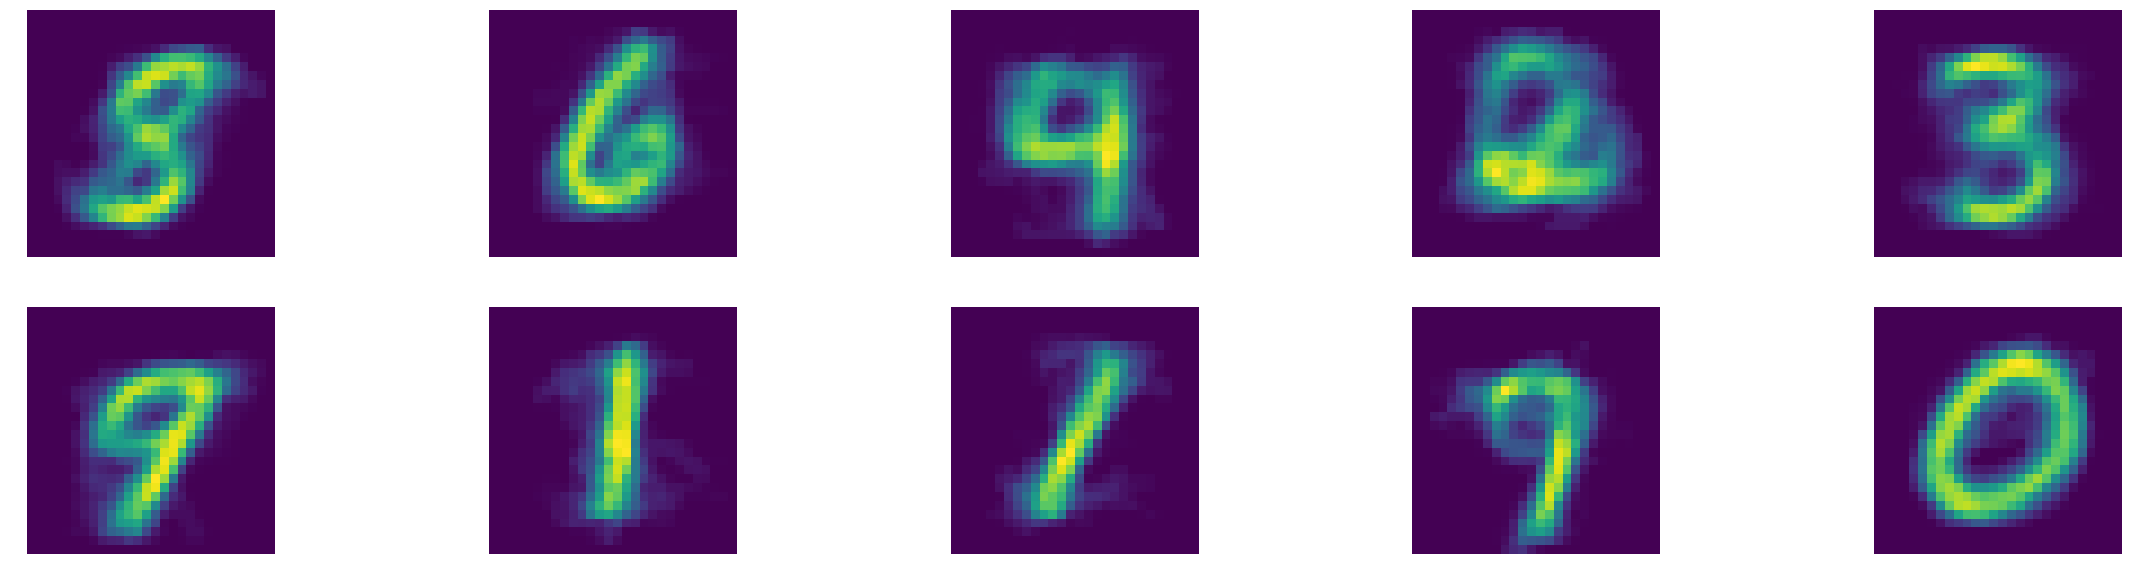

In [30]:
plt.figure(figsize=(40,10))
for i in range(gmm_eco.n_components):
    plt_idx = i + 1
    plt.subplot(2,5,plt_idx)
    plt.imshow(gmm_eco.means_[i].view(28, 28))
    plt.axis("off")
plt.show()


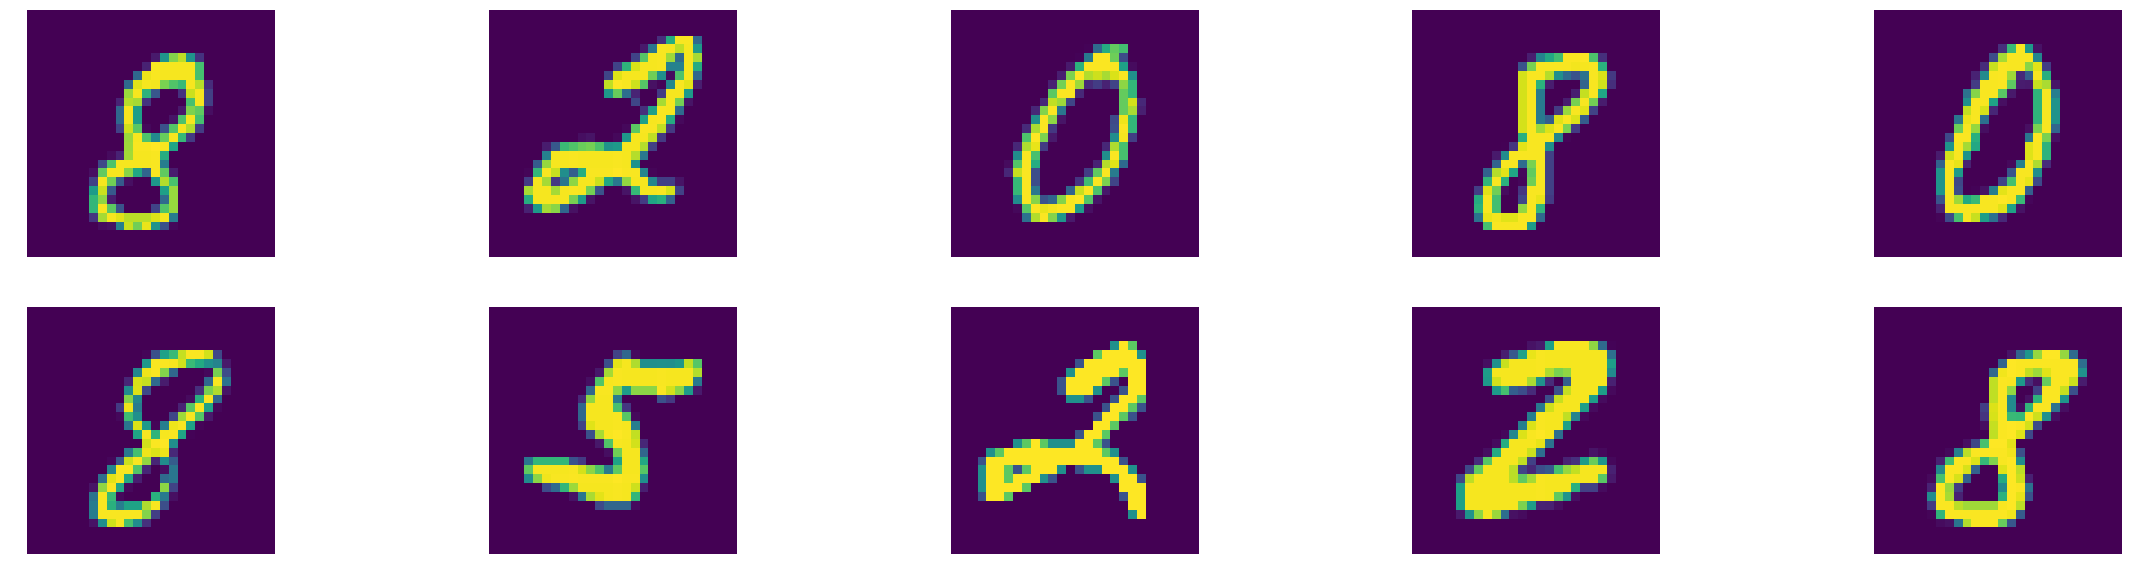

In [29]:
plt.figure(figsize=(40,10))
for i in range(10):
    plt_idx = i + 1
    plt.subplot(2,5,plt_idx)
    plt.imshow(gmm_eco.components[1][i+100].view(28, 28))
    plt.axis("off")
plt.show()

In [ ]:
gmm_sk = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=10)
gmm_sk.means_init = np.array([trainset.train_data.view(-1, 28 * 28).numpy()[trainset.train_labels.numpy() == i].mean(axis=0)
                                    for i in range(10)])
print(gmm_sk.means_init.shape)
gmm_sk.fit(trainset.train_data[:2000].view(-1, 28 * 28))

In [ ]:
print(np.average(testet.test_data.numpy() == gmm_sk.predict(X=testet.test_data.view(-1, 28 *28).numpy())))
print(gmm_sk.predict_proba(X=testet.test_data.view(-1, 28 *28).numpy()))
gmm_sk.weights_.sum()
gmm_sk.covariances_

In [ ]:
def multi_dims_cmp(x, y):
    assert x.shape == y.shape, 'mismatch shape'
    for i, item in enumerate(x):
        if item > y[i]:
            return False
    return True

def ECDF(x, xset):
    n = xset.shape[0]
    mol = 0
    for item in xset:
        if multi_dims_cmp(item, x):
            mol += 1
    return mol / n

def ks_distance(samples):
    P = lambda x: mvn.pdf(x)
    F = lambda x: mvn.cdf(x)
    Fn = lambda x: ECDF(x, samples)
    FF = lambda x: np.abs(Fn(x) - F(x)) / P(x)

    r = 0.0
    for x in samples:
        r += FF(x) / 1000
    return r

In [ ]:
from scipy.stats import multivariate_normal 
mean = np.array([1,5])
covariance = np.matrix([[1, 0.3 ],[0.3, 1]])
mvn = multivariate_normal(mean=mean, cov=covariance)
print ("CDF:", mvn.cdf(np.array([2,4])))

In [ ]:
samples = mvn.rvs(size=1000)
print(np.abs(ECDF(samples[0], samples) - mvn.cdf(samples[0])))
print(torch.tensor([10,10]).shape[0])

In [ ]:
P = lambda x: mvn.pdf(x)
F = lambda x: mvn.cdf(x)
Fn = lambda x: ECDF(x, samples)
FF = lambda x: np.abs(Fn(x) - F(x)) / P(x)

r = 0.0
for x in samples:
    r += FF(x) / 1000
print(r)

In [ ]:
print(1 if 1 > 2 else 0)

In [ ]:
class GMM(object):
    def __init__(self, n_components, gamma = 0.05, pi_threshold = 0.05, 
                 jsd_threshold = 0.05, l_threshold = 0.95, Td = 0.5,  
                 covariance_type = None):
        assert covariance_type is None, 'Not implemented!'
        self.n_components = n_components
        self.components = []
        self.gamma = gamma
        self.dataloader = None
        self.var_size = None
        self.covariance_matrix = None
        self.pi_threshold = pi_threshold
        self.jsd_threshold = jsd_threshold
        self.Td = Td
        self.l_threshold = l_threshold
    
    def fit(self, dataloader, var_size):
        self.dataloader = dataloader
        self.var_size = var_size
        self.covariance_matrix = torch.eye(var_size, dtype=torch.float)
    
    def update_weight(self, pi_sum):
        for item in self.components:
            item['pi'] = item['pi'] / pi_sum
    def restore_weight(self, pi_new):
        for item in self.components:
            item['pi'] = item['pi'] * (1 + pi_new)
    
    #GMM.update:
    #simplified version
    #initialize a component with pi = gamma and u = x where x is a sample
    #merge two components if jsd is less than a threshold
    #otherwise if number of components exceeds n_threshold then discard one whose pi is less than threshold
    def update(self, var):
        r = {'pi': self.gamma, 'u': var, 'cov': self.covariance_matrix}
        self.update_weight(1 + r['pi'])
        r['pi'] /= self.gamma + 1
        rIdx, m = 0, 9999999
        for i in range(len(self.components)):
#             jsd = self.js_divergence(mu_1=self.components[i]['u'], cov_1 = self.components[i]['cov'],
#                                 mu_2 = r['u'], cov_2 = r['cov'])
            jsd = self.dis(self.components[i]['u'], r['u'])
            if jsd.item() < m:
                rIdx, m = i, jsd.item()
        if m < self.jsd_threshold:
#             self.components[rIdx]['pi'] += r['pi']
#             self.components[rIdx]['u'] = (self.components[rIdx]['pi'] * self.components[rIdx]['u'] + r['pi'] * r['u']) / self.components[rIdx]['pi']
            _, rt = self.is_mergeable(m_1= r['u'], m_2 = self.components[rIdx]['u'],
                                     cov_1=r['cov'], cov_2 = self.components[rIdx]['cov'],
                                     pi_1 = r['pi'], pi_2 = self.components[rIdx]['pi'])
            print(rt)
            self.components.pop(rIdx)
            self.append(rt)
        else:
            self.components.append(r)
        if len(self.components) > self.n_components:
            for idx in range(len(self.components)):
                if self.components[idx]['pi'] < self.pi_threshold:
                    self.update_weight(1 - self.components[idx]['pi'])
                    self.components.pop(idx)
                    return
            l, r, m = 0, 0, 9999999
            for i in range(len(self.components)):
                for j in range(i+1, len(self.components)):
#                     jsd = self.js_divergence(mu_1=self.components[i]['u'], cov_1=self.components[i]['cov'],
#                                         mu_2=self.components[j]['u'], cov_2=self.components[j]['cov'])
                    jsd = self.dis(self.components[i]['u'], self.components[j]['u'])
#                     print(jsd)
                    if jsd.item() < m:
                        l, r = i, j
                        m = jsd.item()
            _, rt = self.is_mergeable(m_1= self.components[l]['u'], m_2 = self.components[r]['u'],
                                     cov_1=self.components[l]['cov'], cov_2 = self.components[r]['cov'],
                                     pi_1 = self.components[l]['pi'], pi_2 = self.components[r]['pi'])
#             print(l, r, m)
            self.components.pop(r)
            self.components.pop(l)
            self.components.append(rt)
        else:
            pass
        
    def predict(self, var):
        px = 0.0
        probs = []
        for item in self.components:
            
            p = item['pi'] * np.power(2, MultivariateNormal(loc = item['u'], covariance_matrix=item['cov']).log_prob(var).numpy())
            px += p
            print(multivariate_normal(mean = item['u'], cov=item['cov']).cdf(var))
            print(p)
            print(np.power(2, MultivariateNormal(loc = item['u'], covariance_matrix=item['cov']).log_prob(var).numpy()))
            probs.append(p)
        print(px)
        
        return np.array(probs) / px
    
    def js_divergence(self, mu_1, cov_1, mu_2, cov_2):
        assert mu_1.shape == mu_2.shape, 'mu shape mismatch'
        assert cov_1.shape == cov_2.shape, 'cov shape mismatch'

        # Monte Carlo samples
        MC_samples = 1000

        Pd = MultivariateNormal(loc = mu_1, covariance_matrix=cov_1)
        Qd = MultivariateNormal(loc = mu_2, covariance_matrix=cov_2)
        P_samples = Pd.sample((MC_samples,))
        Q_samples = Qd.sample((MC_samples,))

    #     print(Pd.log_prob(torch.tensor([1.,1.])).type())
        P = lambda x: torch.tensor(np.power(2, Pd.log_prob(x).numpy()))
        Q = lambda x: torch.tensor(np.power(2, Qd.log_prob(x).numpy()))
        M = lambda x: 0.5 * P(x) + 0.5 * Q(x)

        P_div_M = lambda x: P(x) / M(x)
        Q_div_M = lambda x: Q(x) / M(x)

        D_KL_approx_PM = lambda x: (1 / MC_samples) * sum(torch.log2(P_div_M(x)))
        D_KL_approx_QM = lambda x: (1 / MC_samples) * sum(torch.log2(Q_div_M(x)))

        return 0.5 * D_KL_approx_PM(P_samples) + 0.5 * D_KL_approx_QM(Q_samples)
    
    def kl_distance(self, samples: torch.tensor, mean: torch.tensor, cov: torch.tensor):
        mvn = multivariate_normal(mean=mean.numpy(), cov=cov.numpy())
        def multi_dims_cmp(x, y):
            assert x.shape == y.shape, 'mismatch shape'
            for i, item in enumerate(x):
                if item > y[i]:
                    return False
            return True

        def ECDF(x, xset):
            n = xset.shape[0]
            mol = 0
            for item in xset:
                if multi_dims_cmp(item, x):
                    mol += 1
            return mol / n
        
        P = lambda x: mvn.pdf(x)
        F = lambda x: mvn.cdf(x)
        Fn = lambda x: ECDF(x, samples)
        FF = lambda x: np.abs(Fn(x) - F(x)) / P(x)

        r = 0.0
        n = samples.shape[0]
        for x in samples:
            r += FF(x) / n
        return r
        
    
    def dis(self, m, n):
        return torch.sqrt((((m - n)*(m - n)).sum()).float())
    
    def merge(self, x):
        pass
    
    def is_mergeable(self, m_1: torch.tensor, m_2: torch.tensor, 
                     cov_1: torch.tensor, cov_2:torch.tensor,
                     pi_1, pi_2, n_samples = 50):
        m = multivariate_normal(mean=m_1.numpy(), cov=cov_1.numpy())
        n = multivariate_normal(mean=m_2.numpy(), cov=cov_2.numpy())
        samples_m = torch.tensor(m.rvs(size= n_samples))
        samples_n = torch.tensor(n.rvs(size= n_samples))
        samples = torch.cat((samples_m, samples_n), dim=0)
        pi = pi_1 + pi_2
        mean = (m_1 * pi_1 + m_2 * pi_2) / pi 
        cov = (pi_1 / pi) * ((cov_1 + ((m_1 - mean) ** 2).sum())) + (pi_2 / pi) * ((cov_2 + ((m_2 - mean) ** 2).sum()))
        kl_dis = self.kl_distance(samples=samples, mean=mean, cov=cov)
        if kl_dis > self.l_threshold:
            return True, {'pi': pi, 'u': mean, 'cov': cov}
        else:
            return False, {'pi': pi, 'u': mean, 'cov': cov}
        
    
    def fideity(kl_distance):
        return math.exp(- (math.pow(kl_distance, 2)) / math.pow(self.Td, 2))
    
    def initialization(self, dataset):
        gmm_sk = mixture.GaussianMixture(n_components=self.n_components, covariance_type='full', max_iter=5)
        l = dataset.size()[0]
        if l > 1000 :
            gmm_sk.fit(dataset[np.random.choice(len(dataset), 1000, replace=False)].view(-1, 28 * 28).numpy())
        else:
            gmm_sk.fit(dataset.view(-1, 28 * 28).numpy())
        for i in range(gmm_sk.means_.shape[0]):
            r = {}
            r['u'] = torch.tensor(gmm_sk.means_[i], dtype=torch.float)
#             r['cov'] = torch.tensor(gmm_sk.covariances_[i], dtype=torch.float)
            r['cov'] = self.covariance_matrix
            r['pi'] = torch.tensor(gmm_sk.weights_[i], dtype=torch.float)
            print(r['pi'])
            self.components.append(r)
        
        
        
        
        
        
        
        
        
            
    

In [ ]:
m = torch.tensor([1.,2.])
n = torch.tensor([1,2])
# torch.cat((m,n),dim=0)
# torch.stack((m,n), dim=0).squeeze()
m + (m ** 2).sum()

In [ ]:
gmm_t = GMM(n_components=10, gamma=0.11, pi_threshold=0.05)
var_size = trainset.train_data.size()
gmm_t.fit(dataloader=trainloader, var_size=var_size[1] * var_size[2])
gmm_t.initialization(dataset=trainset.train_data)

In [ ]:
m = torch.tensor([1,1],dtype=torch.float)
n = torch.tensor([2,2], dtype=torch.float)
cov = torch.eye(2,dtype=torch.float)
pi = 0.5
gmm_t.is_mergeable(m_1=m, m_2=n, cov_1=cov, cov_2=cov, pi_1=pi, pi_2=pi)

In [ ]:
for _ in range(5000):
    image, label = dataiter.next()
    gmm_t.update(var=image.view(28 * 28))
    print('--------')
    s = 0
    for i in range(len(gmm_t.components)):
        print(gmm_t.components[i]['pi'])
        s += gmm_t.components[i]['pi']
    print('s:', s)

In [ ]:
# image, label = dataiter.next()
image = trainset.train_data[1]
print(image.shape)
gmm_t.predict(var=image.view(28 * 28).numpy())